In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
from natsort import natsorted
import nibabel

In [6]:
data_path = "./ACDC/database/"

## Select the model to train

In [54]:
(EPOCHS, ADDITIONAL_TRANSFORMS, WARMUP_SCHEDULER) = (1200, False, False) # Model 1
# (EPOCHS, ADDITIONAL_TRANSFORMS, WARMUP_SCHEDULER) = (1200, True, False) # Model 2
# (EPOCHS, ADDITIONAL_TRANSFORMS, WARMUP_SCHEDULER) = (1200, True, True) # Model 3
# (EPOCHS, ADDITIONAL_TRANSFORMS, WARMUP_SCHEDULER) = (2400, True, True) # Model 4

## Build dictionaries for ACDC

In [7]:
VALIDATION_SET_SIZE = 4

def build_dict_ACDC(data_path, mode='train'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'MRI_sys', 'Label_sys', 'MRI_dias', 'Label_dias'
    that returns the path to the corresponding volume.

    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'train', 'val' or 'test'.

    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of volumes.
    """
    # test if mode is correct
    if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")

    mode_folder = ""
    if mode == "train":
      mode_folder = "training"
      filter_function = lambda x: (int(x[-3:]) - 1) % 20 >= VALIDATION_SET_SIZE
    elif mode == "test":
      mode_folder = "testing"
      filter_function = lambda x: True
    else:
      mode_folder = "training"
      filter_function = lambda x: (int(x[-3:]) - 1) % 20 < VALIDATION_SET_SIZE

    mode_path = os.path.join(data_path,mode_folder)

    # define empty dictionary
    dicts = []
    for file in sorted([f for f in os.listdir(mode_path) if f.startswith("patient") and filter_function(f)]):  ## Dit laatste deel had Michael in de code staan maar gaf errors  op Jupyter
        d = os.path.join(mode_path, file)
        if os.path.isdir(d):
        # reate a list of all useful nifty files
            patient_files = []
            for dir_list in os.listdir(d):
                #print(dir_list)
                if dir_list.endswith(".nii.gz") and not dir_list.endswith("4d.nii.gz"):
                     patient_files.append(dir_list)
                # sorts the files in order that the first file = systole MRI data, second = Systole labeled data, third = diastole MRI, fourth = diastole labeled.
                patient_files=natsorted(patient_files)

            if patient_files:  # Somehow empty folders orrur in the list, they are filtered out by this line of code.
                MRI_sys_path = os.path.join(d,patient_files[2])
                Label_sys_path = os.path.join(d,patient_files[3])
                MRI_dias_path = os.path.join(d,patient_files[0])
                Label_dias_path = os.path.join(d,patient_files[1])
                dicts.append({'MRI_sys': MRI_sys_path, 'Label_sys': Label_sys_path, 'MRI_dias': MRI_dias_path, 'Label_dias': Label_dias_path, 'patient': file})
    return dicts

val_data_list=build_dict_ACDC(data_path,"val")
train_data_list=build_dict_ACDC(data_path,"train")
test_data_list=build_dict_ACDC(data_path,"test")

## Load ACDC data

In [8]:
class LoadACDCData(monai.transforms.Transform):

    """
    This transform loads the volume data from the ACDC challenge to tensors.

    """

    def __init__(self, keys=None):
        self.reader = monai.data.NibabelReader()


    def __call__(self, item):
        MRI_sys = item['MRI_sys']
        Label_sys = item['Label_sys']
        MRI_dias = item['MRI_dias']
        Label_dias = item['Label_dias']

        [MRI_sys, MRI_sys_meta] = self.reader.get_data(self.reader.read(MRI_sys))
        [Label_sys, Label_sys_meta] = self.reader.get_data(self.reader.read(Label_sys))
        [MRI_dias, MRI_dias_meta] = self.reader.get_data(self.reader.read(MRI_dias))
        [Label_dias, Label_dias_meta] = self.reader.get_data(self.reader.read(Label_dias))

        return {
            'MRI_sys': monai.data.meta_tensor.MetaTensor(MRI_sys, meta=MRI_sys_meta),
            'Label_sys': monai.data.meta_tensor.MetaTensor(Label_sys, meta=Label_sys_meta),
            'MRI_dias': monai.data.meta_tensor.MetaTensor(MRI_dias, meta=MRI_dias_meta),
            'Label_dias': monai.data.meta_tensor.MetaTensor(Label_dias, meta=Label_dias_meta),
            'patient': item["patient"]
          }

## Custom Random Crop Transform

In [9]:
from monai.transforms import Transform
from monai.utils import ensure_tuple
import numpy as np
import torch

class CustomRandCropTransform(Transform):
    def __init__(self, keys, roi_size):
        self.keys = ensure_tuple(keys)
        self.roi_size = roi_size

    def __call__(self, data):
        d = dict(data)
        slice_idx = np.random.choice(data[self.keys[0]].shape[-1]) # choosing a random slice
        start_x = np.random.randint(0, data[self.keys[0]].shape[-3] - self.roi_size[0] + 1) # x-coordinate of the crop
        start_y = np.random.randint(0, data[self.keys[0]].shape[-2] - self.roi_size[1] + 1) # y-coordinate of the crop

        for key in self.keys:
            d[key] = d[key][...,start_x:start_x+self.roi_size[0],start_y:start_y+self.roi_size[1],slice_idx]

        return d

## Define transforms

In [56]:
DICT_KEYS = ['MRI_sys','Label_sys', 'MRI_dias', 'Label_dias']

static_transform = [
    LoadACDCData(),
    monai.transforms.AddChanneld(keys=DICT_KEYS),
    monai.transforms.Spacingd(keys=DICT_KEYS, pixdim=(1.4, 1.4, 10)),      # waarom deze spacing?
    monai.transforms.NormalizeIntensityD(keys=["MRI_sys", "MRI_dias"]),   # doe dit ook iets met 5% en 95% percentile?
]

random_transform = [
    monai.transforms.RandRotated(keys=DICT_KEYS, range_x=[1.1, 1.1], mode=("bilinear", "nearest","bilinear", "nearest"), prob=0.4), 
    CustomRandCropTransform(keys=DICT_KEYS, roi_size=(128,128)),
    monai.transforms.RandHistogramShiftd(keys=["MRI_sys", "MRI_dias"], prob=0.4, num_control_points=3)
]

additional_transform = [monai.transforms.RandShiftIntensity(offsets=10, safe=True, prob=1)] if ADDITIONAL_TRANSFORMS else []

val_transform = monai.transforms.Compose(static_transform)
train_transform = monai.transforms.Compose([
    *static_transform,
    *random_transform,
    *additional_transform
])
test_transform = monai.transforms.Compose(static_transform)

## Create dataloaders

In [57]:
val_dataset = monai.data.CacheDataset(val_data_list, transform=val_transform)
val_loader = monai.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

train_dataset = monai.data.CacheDataset(train_data_list, transform=train_transform)
train_loader = monai.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = monai.data.CacheDataset(test_data_list, transform=test_transform)
test_loader = monai.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

Loading dataset: 100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


In [58]:
def from_compose_to_list(transform_compose):
    """
    Transform an object monai.transforms.Compose in a list fully describing the transform.
    /!\ Random seed is not saved, then reproducibility is not enabled.
    """
    from copy import deepcopy

    if not isinstance(transform_compose, monai.transforms.Compose):
        raise TypeError("transform_compose should be a monai.transforms.Compose object.")

    output_list = list()
    for transform in transform_compose.transforms:
        kwargs = deepcopy(vars(transform))

        # Remove attributes which are not arguments
        args = list(transform.__init__.__code__.co_varnames[1: transform.__init__.__code__.co_argcount])
        for key, obj in vars(transform).items():
            if key not in args:
                del kwargs[key]

        output_list.append({"class": transform.__class__, "kwargs": kwargs})
    return output_list

def from_list_to_compose(transform_list):
    """
    Transform a list in the corresponding monai.transforms.Compose object.
    """

    if not isinstance(transform_list, list):
        raise TypeError("transform_list should be a list.")

    pre_compose_list = list()

    for transform_dict in transform_list:
        if not isinstance(transform_dict, dict) or 'class' not in transform_dict or 'kwargs' not in transform_dict:
            raise TypeError("transform_list should only contains dicts with keys ['class', 'kwargs']")

        try:
            transform = transform_dict['class'](**transform_dict['kwargs'])
        except TypeError: # Classes have been converted to str after saving
            transform = eval(transform_dict['class'].replace("__main__.", ""))(**transform_dict['kwargs'])

        # # Handle label mapping for specific transforms
        # if isinstance(transform, transforms.MapTransform) and 'keys' in transform_dict['kwargs']:
        #     keys = transform_dict['kwargs']['keys']
        #     if 'label' in keys:
        #         # Define the label mapping dictionary
        #         label_mapping = {0: 0, 1: 1, 2: 2, 3: 3}  # Modify this mapping based on your specific needs
        #         transform.label_map = label_mapping

        pre_compose_list.append(transform)

    return monai.transforms.Compose(pre_compose_list)

## Select device

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'
print(f'The used device is {device}')
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary(device=device,abbreviated=True))

The used device is cuda


## Initialize model, loss functions and optimizer

In [60]:
model = monai.networks.nets.SwinUNETR(img_size=(128,128), 
                                       in_channels=2,
                                       out_channels=8,
                                       spatial_dims=2,
                                       normalize='instance'
                                      ).to(device)

In [45]:
loss_function_sys =  monai.losses.DiceLoss(softmax=True, batch=True, to_onehot_y=True)
loss_function_dias =  monai.losses.DiceLoss(softmax=True, batch=True, to_onehot_y=True)

In [46]:
loss_function_lcc_sys =  monai.losses.DiceLoss(batch=True, to_onehot_y=False)
loss_function_lcc_dias =  monai.losses.DiceLoss(batch=True, to_onehot_y=False)



In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = None
if WARMUP_SCHEDULER:
    scheduler = monai.optimizers.WarmupCosineSchedule(optimizer=optimizer, warmup_steps=200, t_total=2400)

In [48]:
slice_inferer = monai.inferers.SliceInferer(roi_size=(128, 128), spatial_dim=2, sw_batch_size=1, cval=-1, progress=False, overlap=0.6, mode='gaussian')
postprocessing = monai.transforms.KeepLargestConnectedComponent(is_onehot=False, applied_labels=[1,2,3], independent=False)

## Training loop

In [41]:
def train_one_epoch():
    losses = []
    for d in train_loader:
        optimizer.zero_grad()
        
        img = torch.cat([d['MRI_sys'], d['MRI_dias']], dim=1).to(device)
        # print(img.shape)
        label_sys = d['Label_sys'].to(device)
        label_dias = d['Label_dias'].to(device)
        out = model(img)
        out_sys = out[:, :4]
        out_dias = out[:, 4:]

        loss = loss_function_sys(out_sys, label_sys) + loss_function_dias(out_dias, label_dias)
        loss.backward()

        optimizer.step()
        
        losses.append(loss.item())
    
    if WARMUP_SCHEDULER:
        scheduler.step()
    return sum(losses)/len(losses)

In [ ]:
from tqdm import tqdm
model.train()

ls = []

for e in tqdm(range(EPOCHS)):
    l = (train_one_epoch())
    print(l)
    ls.append(l)
    
print(ls)

  0%|          | 1/2400 [00:07<5:13:02,  7.83s/it]

1.7055533170700072


  0%|          | 2/2400 [00:11<3:35:14,  5.39s/it]

1.7091942310333252


  0%|          | 3/2400 [00:15<3:08:24,  4.72s/it]

1.7177260160446166


  0%|          | 4/2400 [00:20<3:06:58,  4.68s/it]

1.7206459999084474


  0%|          | 5/2400 [00:24<2:58:52,  4.48s/it]

1.7116246223449707


  0%|          | 6/2400 [00:29<3:03:25,  4.60s/it]

1.6946861267089843


  0%|          | 7/2400 [00:33<3:00:40,  4.53s/it]

1.7014032363891602


  0%|          | 8/2400 [00:38<3:02:52,  4.59s/it]

1.7134252071380616


  0%|          | 9/2400 [00:42<3:00:01,  4.52s/it]

1.6997119188308716


  0%|          | 10/2400 [00:48<3:15:59,  4.92s/it]

1.7007930755615235


  0%|          | 11/2400 [00:53<3:17:31,  4.96s/it]

1.7079121112823485


  0%|          | 12/2400 [00:57<3:12:27,  4.84s/it]

1.6988322734832764


  1%|          | 13/2400 [01:02<3:04:51,  4.65s/it]

1.6913938045501709


  1%|          | 14/2400 [01:06<2:56:09,  4.43s/it]

1.6931126594543457


  1%|          | 15/2400 [01:10<2:56:16,  4.43s/it]

1.6900273084640502


  1%|          | 16/2400 [01:14<2:53:37,  4.37s/it]

1.6885584354400636


  1%|          | 17/2400 [01:19<2:57:36,  4.47s/it]

1.6885566473007203


  1%|          | 18/2400 [01:24<3:00:28,  4.55s/it]

1.682541513442993


  1%|          | 19/2400 [01:28<2:56:40,  4.45s/it]

1.6936855554580688


  1%|          | 20/2400 [01:34<3:12:00,  4.84s/it]

1.6848789691925048


  1%|          | 21/2400 [01:39<3:18:03,  5.00s/it]

1.6892584800720214


  1%|          | 22/2400 [01:44<3:17:06,  4.97s/it]

1.681361150741577


  1%|          | 23/2400 [01:48<3:04:53,  4.67s/it]

1.6754756689071655


  1%|          | 24/2400 [01:52<2:55:26,  4.43s/it]

1.6830767154693604


  1%|          | 25/2400 [01:56<2:59:14,  4.53s/it]

1.6849809169769288


  1%|          | 26/2400 [02:01<3:02:28,  4.61s/it]

1.6829856157302856


  1%|          | 27/2400 [02:06<3:02:52,  4.62s/it]

1.669925904273987


  1%|          | 28/2400 [02:10<3:01:53,  4.60s/it]

1.6835984945297242


  1%|          | 29/2400 [02:16<3:14:46,  4.93s/it]

1.6580149412155152


  1%|▏         | 30/2400 [02:21<3:16:12,  4.97s/it]

1.6576148748397828


  1%|▏         | 31/2400 [02:26<3:17:29,  5.00s/it]

1.649942445755005


  1%|▏         | 32/2400 [02:30<3:05:16,  4.69s/it]

1.658350658416748


  1%|▏         | 33/2400 [02:34<2:57:22,  4.50s/it]

1.6469419956207276


  1%|▏         | 34/2400 [02:40<3:12:26,  4.88s/it]

1.65219304561615


  1%|▏         | 35/2400 [02:44<3:06:16,  4.73s/it]

1.6522952318191528


  2%|▏         | 36/2400 [02:49<3:01:15,  4.60s/it]

1.6340344667434692


  2%|▏         | 37/2400 [02:53<3:02:30,  4.63s/it]

1.6327197551727295


  2%|▏         | 38/2400 [03:00<3:27:19,  5.27s/it]

1.6320957660675048


  2%|▏         | 39/2400 [03:05<3:26:41,  5.25s/it]

1.6225921392440796


  2%|▏         | 40/2400 [03:10<3:13:13,  4.91s/it]

1.6286801815032959


  2%|▏         | 41/2400 [03:13<2:58:51,  4.55s/it]

1.6179288864135741


  2%|▏         | 42/2400 [03:16<2:43:07,  4.15s/it]

1.6285112380981446


  2%|▏         | 43/2400 [03:21<2:43:09,  4.15s/it]

1.6161258459091186


  2%|▏         | 44/2400 [03:25<2:41:31,  4.11s/it]

1.6146337032318114


  2%|▏         | 45/2400 [03:29<2:38:38,  4.04s/it]

1.6287867069244384


  2%|▏         | 46/2400 [03:32<2:33:20,  3.91s/it]

1.615912628173828


  2%|▏         | 47/2400 [03:36<2:28:30,  3.79s/it]

1.6103392124176026


  2%|▏         | 48/2400 [03:40<2:31:32,  3.87s/it]

1.600924015045166


  2%|▏         | 49/2400 [03:43<2:24:24,  3.69s/it]

1.5957639694213868


  2%|▏         | 50/2400 [03:47<2:26:44,  3.75s/it]

1.593167233467102


  2%|▏         | 51/2400 [03:50<2:21:41,  3.62s/it]

1.6067561388015748


  2%|▏         | 52/2400 [03:54<2:24:50,  3.70s/it]

1.587520170211792


  2%|▏         | 53/2400 [03:59<2:34:17,  3.94s/it]

1.590849018096924


  2%|▏         | 54/2400 [04:04<2:50:46,  4.37s/it]

1.5865186691284179


  2%|▏         | 55/2400 [04:09<2:54:21,  4.46s/it]

1.582384467124939


  2%|▏         | 56/2400 [04:12<2:47:06,  4.28s/it]

1.5692436218261718


  2%|▏         | 57/2400 [04:16<2:34:19,  3.95s/it]

1.5627322435379027


  2%|▏         | 58/2400 [04:20<2:34:45,  3.96s/it]

1.5529404163360596


  2%|▏         | 59/2400 [04:23<2:29:27,  3.83s/it]

1.577113723754883


  2%|▎         | 60/2400 [04:27<2:27:35,  3.78s/it]

1.5509879350662232


  3%|▎         | 61/2400 [04:31<2:28:32,  3.81s/it]

1.553558349609375


  3%|▎         | 62/2400 [04:35<2:32:45,  3.92s/it]

1.5550160169601441


  3%|▎         | 63/2400 [04:39<2:32:39,  3.92s/it]

1.5269891977310182


  3%|▎         | 64/2400 [04:43<2:33:55,  3.95s/it]

1.5574848651885986


  3%|▎         | 65/2400 [04:48<2:49:00,  4.34s/it]

1.547497534751892


  3%|▎         | 66/2400 [04:53<2:58:38,  4.59s/it]

1.5567468643188476


  3%|▎         | 67/2400 [04:58<2:56:25,  4.54s/it]

1.5295474767684936


  3%|▎         | 68/2400 [05:02<2:49:14,  4.35s/it]

1.5243928670883178


  3%|▎         | 69/2400 [05:05<2:43:30,  4.21s/it]

1.5130422115325928


  3%|▎         | 70/2400 [05:09<2:40:19,  4.13s/it]

1.5255513668060303


  3%|▎         | 71/2400 [05:14<2:42:29,  4.19s/it]

1.5423867225646972


  3%|▎         | 72/2400 [05:18<2:46:33,  4.29s/it]

1.5288713932037354


  3%|▎         | 73/2400 [05:23<2:49:07,  4.36s/it]

1.5175612449645997


  3%|▎         | 74/2400 [05:27<2:48:07,  4.34s/it]

1.533641481399536


  3%|▎         | 75/2400 [05:32<2:51:55,  4.44s/it]

1.483553910255432


  3%|▎         | 76/2400 [05:36<2:49:21,  4.37s/it]

1.4919797658920289


  3%|▎         | 77/2400 [05:40<2:48:30,  4.35s/it]

1.4758945465087892


  3%|▎         | 78/2400 [05:45<2:55:08,  4.53s/it]

1.4902607679367066


  3%|▎         | 79/2400 [05:49<2:48:01,  4.34s/it]

1.5024399280548095


  3%|▎         | 80/2400 [05:54<2:51:39,  4.44s/it]

1.45519700050354


  3%|▎         | 81/2400 [05:58<2:52:22,  4.46s/it]

1.4902727365493775


  3%|▎         | 82/2400 [06:02<2:46:47,  4.32s/it]

1.474399495124817


  3%|▎         | 83/2400 [06:07<2:52:17,  4.46s/it]

1.4724391222000122


  4%|▎         | 84/2400 [06:11<2:49:37,  4.39s/it]

1.4645881175994873


  4%|▎         | 85/2400 [06:15<2:46:19,  4.31s/it]

1.4692940711975098


  4%|▎         | 86/2400 [06:20<2:44:09,  4.26s/it]

1.4839384078979492


  4%|▎         | 87/2400 [06:24<2:42:20,  4.21s/it]

1.4799843072891234


  4%|▎         | 88/2400 [06:28<2:45:23,  4.29s/it]

1.476744246482849


  4%|▎         | 89/2400 [06:32<2:41:48,  4.20s/it]

1.4654241800308228


  4%|▍         | 90/2400 [06:37<2:46:05,  4.31s/it]

1.440839958190918


  4%|▍         | 91/2400 [06:41<2:45:04,  4.29s/it]

1.4581172227859498


  4%|▍         | 92/2400 [06:45<2:45:01,  4.29s/it]

1.435252857208252


  4%|▍         | 93/2400 [06:50<2:49:21,  4.40s/it]

1.4453946590423583


  4%|▍         | 94/2400 [06:56<3:11:46,  4.99s/it]

1.4397827625274657


  4%|▍         | 95/2400 [07:02<3:17:47,  5.15s/it]

1.4485764503479004


  4%|▍         | 96/2400 [07:06<3:02:15,  4.75s/it]

1.4182348489761352


  4%|▍         | 97/2400 [07:10<2:54:27,  4.55s/it]

1.3994686603546143


  4%|▍         | 98/2400 [07:14<2:54:30,  4.55s/it]

1.4622894525527954


  4%|▍         | 99/2400 [07:19<2:52:48,  4.51s/it]

1.4269605159759522


  4%|▍         | 100/2400 [07:23<2:54:40,  4.56s/it]

1.4247956991195678


  4%|▍         | 101/2400 [07:28<2:56:02,  4.59s/it]

1.4399933338165283


  4%|▍         | 102/2400 [07:33<3:04:20,  4.81s/it]

1.40522620677948


  4%|▍         | 103/2400 [07:38<2:58:59,  4.68s/it]

1.409645414352417


  4%|▍         | 104/2400 [07:42<2:53:51,  4.54s/it]

1.4272592782974243


  4%|▍         | 105/2400 [07:47<2:55:18,  4.58s/it]

1.3918547630310059


  4%|▍         | 106/2400 [07:50<2:45:47,  4.34s/it]

1.4007894039154052


  4%|▍         | 107/2400 [07:55<2:53:32,  4.54s/it]

1.362939214706421


  4%|▍         | 108/2400 [08:00<2:57:39,  4.65s/it]

1.3759127378463745


  5%|▍         | 109/2400 [08:04<2:51:04,  4.48s/it]

1.3781195878982544


  5%|▍         | 110/2400 [08:08<2:44:57,  4.32s/it]

1.3695405960083007


  5%|▍         | 111/2400 [08:13<2:49:20,  4.44s/it]

1.338493037223816


  5%|▍         | 112/2400 [08:17<2:44:15,  4.31s/it]

1.3673001527786255


  5%|▍         | 113/2400 [08:22<2:54:51,  4.59s/it]

1.372477078437805


  5%|▍         | 114/2400 [08:28<3:03:34,  4.82s/it]

1.3635758399963378


  5%|▍         | 115/2400 [08:33<3:07:45,  4.93s/it]

1.3996019124984742


  5%|▍         | 116/2400 [08:38<3:12:55,  5.07s/it]

1.3762072801589966


  5%|▍         | 117/2400 [08:44<3:16:43,  5.17s/it]

1.3642825365066529


  5%|▍         | 118/2400 [08:48<3:06:54,  4.91s/it]

1.3161592483520508


  5%|▍         | 119/2400 [08:54<3:16:57,  5.18s/it]

1.3590391397476196


  5%|▌         | 120/2400 [08:58<3:08:19,  4.96s/it]

1.326776099205017


  5%|▌         | 121/2400 [09:03<3:04:58,  4.87s/it]

1.3147292375564574


  5%|▌         | 122/2400 [09:07<2:56:43,  4.65s/it]

1.3269821405410767


  5%|▌         | 123/2400 [09:11<2:50:52,  4.50s/it]

1.3067886352539062


  5%|▌         | 124/2400 [09:15<2:47:42,  4.42s/it]

1.3113658666610717


  5%|▌         | 125/2400 [09:19<2:42:40,  4.29s/it]

1.3247269630432128


  5%|▌         | 126/2400 [09:23<2:33:25,  4.05s/it]

1.33871488571167


  5%|▌         | 127/2400 [09:27<2:31:38,  4.00s/it]

1.3159045696258544


  5%|▌         | 128/2400 [09:31<2:32:25,  4.03s/it]

1.330135178565979


  5%|▌         | 129/2400 [09:35<2:30:09,  3.97s/it]

1.2963256120681763


  5%|▌         | 130/2400 [09:40<2:51:28,  4.53s/it]

1.2880118846893311


  5%|▌         | 131/2400 [09:45<2:47:23,  4.43s/it]

1.3305481910705566


  6%|▌         | 132/2400 [09:49<2:47:57,  4.44s/it]

1.2932204961776734


  6%|▌         | 133/2400 [09:54<2:49:54,  4.50s/it]

1.3202534914016724


  6%|▌         | 134/2400 [09:57<2:39:20,  4.22s/it]

1.2866790533065795


  6%|▌         | 135/2400 [10:03<2:56:56,  4.69s/it]

1.2979383230209351


  6%|▌         | 136/2400 [10:09<3:07:11,  4.96s/it]

1.2565523386001587


  6%|▌         | 137/2400 [10:13<3:03:06,  4.85s/it]

1.297084093093872


  6%|▌         | 138/2400 [10:17<2:55:21,  4.65s/it]

1.257248878479004


  6%|▌         | 139/2400 [10:22<2:54:36,  4.63s/it]

1.2548264741897583


  6%|▌         | 140/2400 [10:27<3:00:23,  4.79s/it]

1.254649019241333


  6%|▌         | 141/2400 [10:33<3:08:13,  5.00s/it]

1.2583733558654786


  6%|▌         | 142/2400 [10:38<3:08:30,  5.01s/it]

1.2607573032379151


  6%|▌         | 143/2400 [10:43<3:06:53,  4.97s/it]

1.249794840812683


  6%|▌         | 144/2400 [10:47<2:54:57,  4.65s/it]

1.2461180210113525


  6%|▌         | 145/2400 [10:51<2:48:31,  4.48s/it]

1.2161688566207887


  6%|▌         | 146/2400 [10:55<2:51:25,  4.56s/it]

1.2195137023925782


  6%|▌         | 147/2400 [11:01<2:59:52,  4.79s/it]

1.2666918277740478


  6%|▌         | 148/2400 [11:05<2:49:45,  4.52s/it]

1.2237182140350342


  6%|▌         | 149/2400 [11:09<2:49:46,  4.53s/it]

1.231215524673462


  6%|▋         | 150/2400 [11:14<2:56:22,  4.70s/it]

1.2510231494903565


  6%|▋         | 151/2400 [11:19<3:00:45,  4.82s/it]

1.2430742263793946


  6%|▋         | 152/2400 [11:23<2:42:49,  4.35s/it]

1.2194082498550416


  6%|▋         | 153/2400 [11:26<2:33:05,  4.09s/it]

1.2204791069030763


  6%|▋         | 154/2400 [11:30<2:25:51,  3.90s/it]

1.2364839315414429


  6%|▋         | 155/2400 [11:35<2:38:20,  4.23s/it]

1.2313343048095704


  6%|▋         | 156/2400 [11:40<2:51:41,  4.59s/it]

1.2544527053833008


  7%|▋         | 157/2400 [11:45<3:00:10,  4.82s/it]

1.1973151922225953


  7%|▋         | 158/2400 [11:50<2:54:55,  4.68s/it]

1.1761106491088866


  7%|▋         | 159/2400 [11:53<2:42:39,  4.35s/it]

1.1718674182891846


  7%|▋         | 160/2400 [11:58<2:51:24,  4.59s/it]

1.216571307182312


  7%|▋         | 161/2400 [12:03<2:49:59,  4.56s/it]

1.2086961030960084


  7%|▋         | 162/2400 [12:07<2:40:33,  4.30s/it]

1.168570637702942


  7%|▋         | 163/2400 [12:10<2:28:21,  3.98s/it]

1.1731565237045287


  7%|▋         | 164/2400 [12:13<2:21:44,  3.80s/it]

1.2011375188827516


  7%|▋         | 165/2400 [12:17<2:19:22,  3.74s/it]

1.2028253316879272


  7%|▋         | 166/2400 [12:21<2:19:33,  3.75s/it]

1.141810369491577


  7%|▋         | 167/2400 [12:25<2:22:32,  3.83s/it]

1.1708267211914063


  7%|▋         | 168/2400 [12:28<2:20:45,  3.78s/it]

1.186181330680847


  7%|▋         | 169/2400 [12:32<2:23:55,  3.87s/it]

1.1552778482437134


  7%|▋         | 170/2400 [12:36<2:18:59,  3.74s/it]

1.1527317762374878


  7%|▋         | 171/2400 [12:39<2:12:14,  3.56s/it]

1.1356773853302002


  7%|▋         | 172/2400 [12:43<2:18:56,  3.74s/it]

1.1471107244491576


  7%|▋         | 173/2400 [12:48<2:35:48,  4.20s/it]

1.1410138130187988


  7%|▋         | 174/2400 [12:54<2:53:27,  4.68s/it]

1.1320178270339967


  7%|▋         | 175/2400 [12:59<2:53:06,  4.67s/it]

1.1295850038528443


  7%|▋         | 176/2400 [13:02<2:42:02,  4.37s/it]

1.1338497877120972


  7%|▋         | 177/2400 [13:07<2:47:36,  4.52s/it]

1.122698998451233


  7%|▋         | 178/2400 [13:11<2:42:24,  4.39s/it]

1.073085880279541


  7%|▋         | 179/2400 [13:16<2:43:50,  4.43s/it]

1.0717290401458741


  8%|▊         | 180/2400 [13:21<2:53:09,  4.68s/it]

1.1319967746734618


  8%|▊         | 181/2400 [13:26<2:51:50,  4.65s/it]

1.1226948022842407


  8%|▊         | 182/2400 [13:32<3:04:57,  5.00s/it]

1.0851580619812011


  8%|▊         | 183/2400 [13:36<2:55:51,  4.76s/it]

1.0841803908348084


  8%|▊         | 184/2400 [13:40<2:49:44,  4.60s/it]

1.1119228839874267


  8%|▊         | 185/2400 [13:44<2:41:52,  4.38s/it]

1.1207127809524535


  8%|▊         | 186/2400 [13:49<2:46:39,  4.52s/it]

1.1272941827774048


  8%|▊         | 187/2400 [13:53<2:49:14,  4.59s/it]

1.0672606468200683


  8%|▊         | 188/2400 [13:59<2:57:24,  4.81s/it]

1.0431378602981567


  8%|▊         | 189/2400 [14:03<2:49:14,  4.59s/it]

1.0167543292045593


  8%|▊         | 190/2400 [14:07<2:46:29,  4.52s/it]

1.0548923015594482


  8%|▊         | 191/2400 [14:11<2:42:24,  4.41s/it]

1.0569053888320923


  8%|▊         | 192/2400 [14:15<2:37:32,  4.28s/it]

1.086626982688904


  8%|▊         | 193/2400 [14:19<2:31:55,  4.13s/it]

1.0658440113067627


  8%|▊         | 194/2400 [14:24<2:43:03,  4.43s/it]

1.0205589652061462


  8%|▊         | 195/2400 [14:29<2:47:56,  4.57s/it]

1.0291561126708983


  8%|▊         | 196/2400 [14:34<2:51:39,  4.67s/it]

0.993650472164154


  8%|▊         | 197/2400 [14:38<2:39:59,  4.36s/it]

1.0088175177574157


  8%|▊         | 198/2400 [14:41<2:31:30,  4.13s/it]

1.0405513286590575


  8%|▊         | 199/2400 [14:46<2:32:44,  4.16s/it]

0.977936327457428


  8%|▊         | 200/2400 [14:49<2:27:53,  4.03s/it]

1.0255985617637635


  8%|▊         | 201/2400 [14:53<2:28:36,  4.05s/it]

0.9921168088912964


  8%|▊         | 202/2400 [14:57<2:20:13,  3.83s/it]

1.015425944328308


  8%|▊         | 203/2400 [15:00<2:18:45,  3.79s/it]

0.9968858480453491


  8%|▊         | 204/2400 [15:04<2:17:50,  3.77s/it]

0.9599727869033814


  9%|▊         | 205/2400 [15:08<2:14:37,  3.68s/it]

0.9914515852928162


  9%|▊         | 206/2400 [15:11<2:15:24,  3.70s/it]

0.967242419719696


  9%|▊         | 207/2400 [15:15<2:16:31,  3.74s/it]

1.0088971495628356


  9%|▊         | 208/2400 [15:19<2:14:36,  3.68s/it]

0.9678917169570923


  9%|▊         | 209/2400 [15:22<2:10:27,  3.57s/it]

0.9751584529876709


  9%|▉         | 210/2400 [15:26<2:10:13,  3.57s/it]

0.9348336935043335


  9%|▉         | 211/2400 [15:30<2:24:22,  3.96s/it]

0.9493812203407288


  9%|▉         | 212/2400 [15:35<2:26:19,  4.01s/it]

0.899635124206543


  9%|▉         | 213/2400 [15:40<2:39:22,  4.37s/it]

0.9898330092430114


  9%|▉         | 214/2400 [15:46<2:53:56,  4.77s/it]

0.9185941219329834


  9%|▉         | 215/2400 [15:51<2:58:22,  4.90s/it]

0.9928011655807495


  9%|▉         | 216/2400 [15:55<2:51:49,  4.72s/it]

0.9021939277648926


  9%|▉         | 217/2400 [15:59<2:45:26,  4.55s/it]

0.9484287977218628


  9%|▉         | 218/2400 [16:03<2:41:48,  4.45s/it]

0.9247016310691833


  9%|▉         | 219/2400 [16:08<2:44:32,  4.53s/it]

0.9074731230735779


  9%|▉         | 220/2400 [16:13<2:46:57,  4.60s/it]

0.921681547164917


  9%|▉         | 221/2400 [16:17<2:47:22,  4.61s/it]

0.8521006464958191


  9%|▉         | 222/2400 [16:21<2:38:32,  4.37s/it]

0.8919625043869018


  9%|▉         | 223/2400 [16:25<2:33:10,  4.22s/it]

0.9325097322463989


  9%|▉         | 224/2400 [16:29<2:25:51,  4.02s/it]

0.9017365097999572


  9%|▉         | 225/2400 [16:33<2:24:53,  4.00s/it]

0.9382744908332825


  9%|▉         | 226/2400 [16:36<2:18:31,  3.82s/it]

0.915506911277771


  9%|▉         | 227/2400 [16:40<2:24:49,  4.00s/it]

0.8851168751716614


 10%|▉         | 228/2400 [16:46<2:39:26,  4.40s/it]

0.9076104879379272


 10%|▉         | 229/2400 [16:50<2:33:12,  4.23s/it]

0.8843544483184814


 10%|▉         | 230/2400 [16:53<2:20:38,  3.89s/it]

0.8980232119560242


 10%|▉         | 231/2400 [16:57<2:25:22,  4.02s/it]

0.8283719897270203


 10%|▉         | 232/2400 [17:02<2:31:32,  4.19s/it]

0.9102811098098755


 10%|▉         | 233/2400 [17:06<2:29:50,  4.15s/it]

0.8520329356193542


 10%|▉         | 234/2400 [17:09<2:22:27,  3.95s/it]

0.8543926477432251


 10%|▉         | 235/2400 [17:13<2:20:29,  3.89s/it]

0.8396750092506409


 10%|▉         | 236/2400 [17:17<2:25:42,  4.04s/it]

0.8538729786872864


 10%|▉         | 237/2400 [17:21<2:20:30,  3.90s/it]

0.8167973637580872


 10%|▉         | 238/2400 [17:25<2:18:17,  3.84s/it]

0.8837896823883057


 10%|▉         | 239/2400 [17:28<2:17:40,  3.82s/it]

0.8368244647979737


 10%|█         | 240/2400 [17:32<2:16:00,  3.78s/it]

0.8519881844520569


 10%|█         | 241/2400 [17:36<2:14:12,  3.73s/it]

0.7954946994781494


 10%|█         | 242/2400 [17:40<2:16:18,  3.79s/it]

0.8430083513259887


 10%|█         | 243/2400 [17:43<2:14:42,  3.75s/it]

0.8259679675102234


 10%|█         | 244/2400 [17:47<2:17:10,  3.82s/it]

0.7913905024528504


 10%|█         | 245/2400 [17:51<2:18:05,  3.84s/it]

0.8223885774612427


 10%|█         | 246/2400 [17:55<2:14:31,  3.75s/it]

0.809360933303833


 10%|█         | 247/2400 [17:58<2:14:17,  3.74s/it]

0.7773746728897095


 10%|█         | 248/2400 [18:02<2:15:22,  3.77s/it]

0.7955180883407593


 10%|█         | 249/2400 [18:06<2:14:53,  3.76s/it]

0.759502398967743


 10%|█         | 250/2400 [18:09<2:10:08,  3.63s/it]

0.7897905111312866


 10%|█         | 251/2400 [18:13<2:11:18,  3.67s/it]

0.7810461401939393


 10%|█         | 252/2400 [18:17<2:14:24,  3.75s/it]

0.7643060803413391


 11%|█         | 253/2400 [18:21<2:15:43,  3.79s/it]

0.7758706331253051


 11%|█         | 254/2400 [18:25<2:17:05,  3.83s/it]

0.7595305681228638


 11%|█         | 255/2400 [18:29<2:16:37,  3.82s/it]

0.777103865146637


 11%|█         | 256/2400 [18:33<2:17:24,  3.85s/it]

0.7574347615242004


 11%|█         | 257/2400 [18:37<2:21:27,  3.96s/it]

0.7766324877738953


 11%|█         | 258/2400 [18:41<2:26:55,  4.12s/it]

0.7930823802947998


 11%|█         | 259/2400 [18:45<2:21:26,  3.96s/it]

0.6819051027297973


 11%|█         | 260/2400 [18:49<2:22:45,  4.00s/it]

0.7168124437332153


 11%|█         | 261/2400 [18:52<2:17:33,  3.86s/it]

0.7511638164520263


 11%|█         | 262/2400 [18:56<2:17:07,  3.85s/it]

0.7527956008911133


 11%|█         | 263/2400 [19:00<2:19:48,  3.93s/it]

0.7034350395202636


 11%|█         | 264/2400 [19:04<2:14:20,  3.77s/it]

0.6904069066047669


 11%|█         | 265/2400 [19:08<2:13:40,  3.76s/it]

0.7095199942588806


 11%|█         | 266/2400 [19:11<2:11:54,  3.71s/it]

0.7267614364624023


 11%|█         | 267/2400 [19:15<2:12:56,  3.74s/it]

0.7086763739585876


 11%|█         | 268/2400 [19:19<2:13:45,  3.76s/it]

0.690433144569397


 11%|█         | 269/2400 [19:23<2:15:27,  3.81s/it]

0.7051553845405578


 11%|█▏        | 270/2400 [19:27<2:15:24,  3.81s/it]

0.7002642512321472


 11%|█▏        | 271/2400 [19:31<2:24:04,  4.06s/it]

0.701602041721344


 11%|█▏        | 272/2400 [19:37<2:42:54,  4.59s/it]

0.6985129833221435


 11%|█▏        | 273/2400 [19:42<2:43:45,  4.62s/it]

0.6545233249664306


 11%|█▏        | 274/2400 [19:46<2:37:23,  4.44s/it]

0.7076232314109803


 11%|█▏        | 275/2400 [19:50<2:39:48,  4.51s/it]

0.7180981397628784


 12%|█▏        | 276/2400 [19:55<2:39:15,  4.50s/it]

0.6485135912895202


 12%|█▏        | 277/2400 [19:59<2:34:14,  4.36s/it]

0.6234695434570312


 12%|█▏        | 278/2400 [20:03<2:33:53,  4.35s/it]

0.6446046829223633


 12%|█▏        | 279/2400 [20:08<2:35:42,  4.40s/it]

0.6392522096633911


 12%|█▏        | 280/2400 [20:12<2:34:44,  4.38s/it]

0.6415263652801514


 12%|█▏        | 281/2400 [20:16<2:31:25,  4.29s/it]

0.6305150508880615


 12%|█▏        | 282/2400 [20:20<2:30:51,  4.27s/it]

0.6381017208099365


 12%|█▏        | 283/2400 [20:25<2:31:31,  4.29s/it]

0.6289819955825806


 12%|█▏        | 284/2400 [20:29<2:26:16,  4.15s/it]

0.5971495032310485


 12%|█▏        | 285/2400 [20:33<2:34:56,  4.40s/it]

0.618917977809906


 12%|█▏        | 286/2400 [20:38<2:31:33,  4.30s/it]

0.5949283480644226


 12%|█▏        | 287/2400 [20:41<2:24:35,  4.11s/it]

0.5711333394050598


 12%|█▏        | 288/2400 [20:45<2:23:40,  4.08s/it]

0.6265807032585144


 12%|█▏        | 289/2400 [20:50<2:30:25,  4.28s/it]

0.6407469630241394


 12%|█▏        | 290/2400 [20:54<2:27:43,  4.20s/it]

0.5699007034301757


 12%|█▏        | 291/2400 [20:59<2:34:47,  4.40s/it]

0.5982844471931458


 12%|█▏        | 292/2400 [21:03<2:31:34,  4.31s/it]

0.5862109780311584


 12%|█▏        | 293/2400 [21:08<2:33:59,  4.39s/it]

0.5964914083480835


 12%|█▏        | 294/2400 [21:12<2:31:04,  4.30s/it]

0.6008676648139953


 12%|█▏        | 295/2400 [21:15<2:22:26,  4.06s/it]

0.574358606338501


 12%|█▏        | 296/2400 [21:19<2:21:18,  4.03s/it]

0.5469110250473023


 12%|█▏        | 297/2400 [21:24<2:25:21,  4.15s/it]

0.5679613709449768


 12%|█▏        | 298/2400 [21:28<2:26:57,  4.19s/it]

0.5893786191940308


 12%|█▏        | 299/2400 [21:32<2:26:52,  4.19s/it]

0.603429639339447


 12%|█▎        | 300/2400 [21:36<2:28:03,  4.23s/it]

0.5777176976203918


 13%|█▎        | 301/2400 [21:40<2:25:31,  4.16s/it]

0.526222825050354


 13%|█▎        | 302/2400 [21:45<2:26:22,  4.19s/it]

0.5599018573760987


 13%|█▎        | 303/2400 [21:48<2:22:41,  4.08s/it]

0.553446638584137


 13%|█▎        | 304/2400 [21:52<2:21:33,  4.05s/it]

0.5396518349647522


 13%|█▎        | 305/2400 [21:57<2:22:50,  4.09s/it]

0.58294677734375


 13%|█▎        | 306/2400 [22:01<2:29:28,  4.28s/it]

0.6103684067726135


 13%|█▎        | 307/2400 [22:06<2:31:24,  4.34s/it]

0.5759586095809937


 13%|█▎        | 308/2400 [22:10<2:27:24,  4.23s/it]

0.5478268384933471


 13%|█▎        | 309/2400 [22:15<2:38:24,  4.55s/it]

0.5494738519191742


 13%|█▎        | 310/2400 [22:19<2:33:17,  4.40s/it]

0.5100027322769165


 13%|█▎        | 311/2400 [22:24<2:35:54,  4.48s/it]

0.5357193112373352


 13%|█▎        | 312/2400 [22:28<2:33:58,  4.42s/it]

0.5469884395599365


 13%|█▎        | 313/2400 [22:33<2:34:06,  4.43s/it]

0.5690791487693787


 13%|█▎        | 314/2400 [22:37<2:37:31,  4.53s/it]

0.5802034616470337


 13%|█▎        | 315/2400 [22:42<2:39:54,  4.60s/it]

0.5677550435066223


 13%|█▎        | 316/2400 [22:46<2:34:32,  4.45s/it]

0.555122584104538


 13%|█▎        | 317/2400 [22:51<2:35:52,  4.49s/it]

0.5310603678226471


 13%|█▎        | 318/2400 [22:56<2:43:35,  4.71s/it]

0.5517264127731323


 13%|█▎        | 319/2400 [23:00<2:36:25,  4.51s/it]

0.5110173463821411


 13%|█▎        | 320/2400 [23:05<2:42:51,  4.70s/it]

0.522111052274704


 13%|█▎        | 321/2400 [23:10<2:49:18,  4.89s/it]

0.5475441575050354


 13%|█▎        | 322/2400 [23:15<2:44:16,  4.74s/it]

0.5581509947776795


 13%|█▎        | 323/2400 [23:20<2:52:58,  5.00s/it]

0.4931239187717438


 14%|█▎        | 324/2400 [23:25<2:48:18,  4.86s/it]

0.4979977190494537


 14%|█▎        | 325/2400 [23:29<2:40:23,  4.64s/it]

0.5501228094100952


 14%|█▎        | 326/2400 [23:33<2:34:06,  4.46s/it]

0.5155890464782715


 14%|█▎        | 327/2400 [23:38<2:36:00,  4.52s/it]

0.5524478554725647


 14%|█▎        | 328/2400 [23:43<2:45:01,  4.78s/it]

0.5662510395050049


 14%|█▎        | 329/2400 [23:48<2:45:50,  4.80s/it]

0.5646427214145661


 14%|█▍        | 330/2400 [23:52<2:41:40,  4.69s/it]

0.5053617656230927


 14%|█▍        | 331/2400 [23:57<2:36:27,  4.54s/it]

0.5256583452224731


 14%|█▍        | 332/2400 [24:01<2:33:18,  4.45s/it]

0.5447803258895874


 14%|█▍        | 333/2400 [24:05<2:25:50,  4.23s/it]

0.49796130657196047


 14%|█▍        | 334/2400 [24:09<2:24:37,  4.20s/it]

0.5380087256431579


 14%|█▍        | 335/2400 [24:13<2:28:50,  4.32s/it]

0.525314199924469


 14%|█▍        | 336/2400 [24:18<2:30:23,  4.37s/it]

0.533282482624054


 14%|█▍        | 337/2400 [24:22<2:25:36,  4.23s/it]

0.508820402622223


 14%|█▍        | 338/2400 [24:27<2:32:44,  4.44s/it]

0.5073826968669891


 14%|█▍        | 339/2400 [24:30<2:24:44,  4.21s/it]

0.47942855954170227


 14%|█▍        | 340/2400 [24:36<2:37:52,  4.60s/it]

0.5395301938056946


 14%|█▍        | 341/2400 [24:41<2:41:00,  4.69s/it]

0.5225489854812622


 14%|█▍        | 342/2400 [24:45<2:32:59,  4.46s/it]

0.5155844449996948


 14%|█▍        | 343/2400 [24:49<2:31:02,  4.41s/it]

0.509652292728424


 14%|█▍        | 344/2400 [24:53<2:22:19,  4.15s/it]

0.47435826659202573


 14%|█▍        | 345/2400 [24:57<2:21:20,  4.13s/it]

0.49509947299957274


 14%|█▍        | 346/2400 [25:01<2:24:50,  4.23s/it]

0.5183767795562744


 14%|█▍        | 347/2400 [25:06<2:33:46,  4.49s/it]

0.4944737672805786


 14%|█▍        | 348/2400 [25:11<2:40:42,  4.70s/it]

0.4791247069835663


 15%|█▍        | 349/2400 [25:16<2:39:41,  4.67s/it]

0.4773768723011017


 15%|█▍        | 350/2400 [25:20<2:35:16,  4.54s/it]

0.4719880521297455


 15%|█▍        | 351/2400 [25:25<2:33:45,  4.50s/it]

0.4684823215007782


 15%|█▍        | 352/2400 [25:30<2:39:35,  4.68s/it]

0.48275989294052124


 15%|█▍        | 353/2400 [25:34<2:33:58,  4.51s/it]

0.4777502179145813


 15%|█▍        | 354/2400 [25:38<2:25:50,  4.28s/it]

0.44358882308006287


 15%|█▍        | 355/2400 [25:42<2:27:29,  4.33s/it]

0.4595420598983765


 15%|█▍        | 356/2400 [25:46<2:27:08,  4.32s/it]

0.4643019437789917


 15%|█▍        | 357/2400 [25:50<2:21:54,  4.17s/it]

0.43934101462364195


 15%|█▍        | 358/2400 [25:55<2:26:14,  4.30s/it]

0.4779153108596802


 15%|█▍        | 359/2400 [25:59<2:25:31,  4.28s/it]

0.45329925417900085


 15%|█▌        | 360/2400 [26:03<2:24:27,  4.25s/it]

0.42922736406326295


 15%|█▌        | 361/2400 [26:07<2:20:36,  4.14s/it]

0.45716500878334043


 15%|█▌        | 362/2400 [26:11<2:23:27,  4.22s/it]

0.4638940691947937


 15%|█▌        | 363/2400 [26:16<2:23:48,  4.24s/it]

0.5186589121818542


 15%|█▌        | 364/2400 [26:20<2:22:20,  4.19s/it]

0.4579767644405365


 15%|█▌        | 365/2400 [26:24<2:24:06,  4.25s/it]

0.45876519083976747


 15%|█▌        | 366/2400 [26:28<2:22:41,  4.21s/it]

0.44283671379089357


 15%|█▌        | 367/2400 [26:32<2:21:52,  4.19s/it]

0.4413552939891815


 15%|█▌        | 368/2400 [26:37<2:22:09,  4.20s/it]

0.46772983074188235


 15%|█▌        | 369/2400 [26:41<2:24:06,  4.26s/it]

0.43744711875915526


 15%|█▌        | 370/2400 [26:45<2:20:21,  4.15s/it]

0.4669249653816223


 15%|█▌        | 371/2400 [26:49<2:23:39,  4.25s/it]

0.41743879914283755


 16%|█▌        | 372/2400 [26:53<2:17:21,  4.06s/it]

0.44425386786460874


 16%|█▌        | 373/2400 [26:58<2:25:52,  4.32s/it]

0.4879031181335449


 16%|█▌        | 374/2400 [27:02<2:23:26,  4.25s/it]

0.45357767939567567


 16%|█▌        | 375/2400 [27:06<2:19:42,  4.14s/it]

0.45741778016090395


 16%|█▌        | 376/2400 [27:10<2:16:27,  4.05s/it]

0.4781262516975403


 16%|█▌        | 377/2400 [27:14<2:15:05,  4.01s/it]

0.4438774883747101


 16%|█▌        | 378/2400 [27:18<2:17:12,  4.07s/it]

0.5001047849655151


 16%|█▌        | 379/2400 [27:22<2:15:23,  4.02s/it]

0.49267282485961916


 16%|█▌        | 380/2400 [27:26<2:13:26,  3.96s/it]

0.4707161128520966


 16%|█▌        | 381/2400 [27:29<2:12:01,  3.92s/it]

0.4456504940986633


 16%|█▌        | 382/2400 [27:33<2:09:41,  3.86s/it]

0.45976948738098145


 16%|█▌        | 383/2400 [27:38<2:23:22,  4.27s/it]

0.434040242433548


 16%|█▌        | 384/2400 [27:44<2:34:31,  4.60s/it]

0.4301273226737976


 16%|█▌        | 385/2400 [27:48<2:33:50,  4.58s/it]

0.45151724815368655


 16%|█▌        | 386/2400 [27:53<2:31:43,  4.52s/it]

0.45790820121765136


 16%|█▌        | 387/2400 [27:58<2:35:46,  4.64s/it]

0.41733396649360655


 16%|█▌        | 388/2400 [28:01<2:27:46,  4.41s/it]

0.44286115765571593


 16%|█▌        | 389/2400 [28:05<2:22:21,  4.25s/it]

0.47689855098724365


 16%|█▋        | 390/2400 [28:08<2:11:17,  3.92s/it]

0.41049965023994445


 16%|█▋        | 391/2400 [28:12<2:11:07,  3.92s/it]

0.4188158571720123


 16%|█▋        | 392/2400 [28:16<2:05:00,  3.74s/it]

0.4266964614391327


 16%|█▋        | 393/2400 [28:21<2:19:39,  4.17s/it]

0.43891034126281736


 16%|█▋        | 394/2400 [28:25<2:18:21,  4.14s/it]

0.4117978274822235


 16%|█▋        | 395/2400 [28:29<2:21:30,  4.23s/it]

0.4338644206523895


 16%|█▋        | 396/2400 [28:35<2:30:44,  4.51s/it]

0.4428362786769867


 17%|█▋        | 397/2400 [28:39<2:30:20,  4.50s/it]

0.4234240174293518


 17%|█▋        | 398/2400 [28:45<2:42:49,  4.88s/it]

0.4286609947681427


 17%|█▋        | 399/2400 [28:50<2:45:02,  4.95s/it]

0.44033575654029844


 17%|█▋        | 400/2400 [28:55<2:41:33,  4.85s/it]

0.41347151398658755


 17%|█▋        | 401/2400 [28:59<2:38:49,  4.77s/it]

0.4135334253311157


 17%|█▋        | 402/2400 [29:04<2:36:43,  4.71s/it]

0.41866888999938967


 17%|█▋        | 403/2400 [29:08<2:31:58,  4.57s/it]

0.44306483268737795


 17%|█▋        | 404/2400 [29:13<2:36:45,  4.71s/it]

0.4367892980575562


 17%|█▋        | 405/2400 [29:17<2:27:51,  4.45s/it]

0.41404181718826294


 17%|█▋        | 406/2400 [29:21<2:25:05,  4.37s/it]

0.46311100125312804


 17%|█▋        | 407/2400 [29:24<2:16:05,  4.10s/it]

0.40838343501091


 17%|█▋        | 408/2400 [29:28<2:13:42,  4.03s/it]

0.4686651587486267


 17%|█▋        | 409/2400 [29:32<2:10:13,  3.92s/it]

0.4205076515674591


 17%|█▋        | 410/2400 [29:38<2:25:59,  4.40s/it]

0.4343806028366089


 17%|█▋        | 411/2400 [29:43<2:40:37,  4.85s/it]

0.3935816824436188


 17%|█▋        | 412/2400 [29:49<2:46:00,  5.01s/it]

0.44808489084243774


 17%|█▋        | 413/2400 [29:53<2:36:54,  4.74s/it]

0.44316046237945556


 17%|█▋        | 414/2400 [29:57<2:29:01,  4.50s/it]

0.4199267983436584


 17%|█▋        | 415/2400 [30:01<2:20:47,  4.26s/it]

0.3809229075908661


 17%|█▋        | 416/2400 [30:06<2:30:03,  4.54s/it]

0.4322868883609772


 17%|█▋        | 417/2400 [30:10<2:24:58,  4.39s/it]

0.4102130591869354


 17%|█▋        | 418/2400 [30:13<2:12:47,  4.02s/it]

0.39361287355422975


 17%|█▋        | 419/2400 [30:17<2:10:05,  3.94s/it]

0.3954163372516632


 18%|█▊        | 420/2400 [30:21<2:11:04,  3.97s/it]

0.40181074738502504


 18%|█▊        | 421/2400 [30:25<2:12:30,  4.02s/it]

0.3971703052520752


 18%|█▊        | 422/2400 [30:29<2:14:52,  4.09s/it]

0.4315307319164276


 18%|█▊        | 423/2400 [30:34<2:18:35,  4.21s/it]

0.408602899312973


 18%|█▊        | 424/2400 [30:38<2:23:57,  4.37s/it]

0.43583173155784605


 18%|█▊        | 425/2400 [30:44<2:35:55,  4.74s/it]

0.41260520219802854


 18%|█▊        | 426/2400 [30:50<2:47:13,  5.08s/it]

0.40671988725662234


 18%|█▊        | 427/2400 [30:55<2:43:29,  4.97s/it]

0.3999085187911987


 18%|█▊        | 428/2400 [31:00<2:43:41,  4.98s/it]

0.4209015429019928


 18%|█▊        | 429/2400 [31:04<2:40:03,  4.87s/it]

0.40046794414520265


 18%|█▊        | 430/2400 [31:08<2:34:38,  4.71s/it]

0.42948718667030333


 18%|█▊        | 431/2400 [31:14<2:37:50,  4.81s/it]

0.41697423458099364


 18%|█▊        | 432/2400 [31:18<2:30:02,  4.57s/it]

0.39602805972099303


 18%|█▊        | 433/2400 [31:22<2:31:39,  4.63s/it]

0.430124032497406


 18%|█▊        | 434/2400 [31:26<2:27:08,  4.49s/it]

0.4033940553665161


 18%|█▊        | 435/2400 [31:31<2:31:12,  4.62s/it]

0.3794016718864441


 18%|█▊        | 436/2400 [31:36<2:26:18,  4.47s/it]

0.40119577646255494


 18%|█▊        | 437/2400 [31:40<2:24:33,  4.42s/it]

0.4308550715446472


 18%|█▊        | 438/2400 [31:45<2:28:18,  4.54s/it]

0.4048463761806488


 18%|█▊        | 439/2400 [31:49<2:26:49,  4.49s/it]

0.41548781394958495


 18%|█▊        | 440/2400 [31:54<2:30:58,  4.62s/it]

0.4080902457237244


 18%|█▊        | 441/2400 [32:00<2:41:05,  4.93s/it]

0.3563649594783783


 18%|█▊        | 442/2400 [32:04<2:40:11,  4.91s/it]

0.40853402614593504


 18%|█▊        | 443/2400 [32:09<2:37:06,  4.82s/it]

0.4217463433742523


 18%|█▊        | 444/2400 [32:13<2:30:46,  4.63s/it]

0.4098981857299805


 19%|█▊        | 445/2400 [32:17<2:24:03,  4.42s/it]

0.3782096266746521


 19%|█▊        | 446/2400 [32:21<2:20:06,  4.30s/it]

0.39912502765655516


 19%|█▊        | 447/2400 [32:26<2:25:40,  4.48s/it]

0.41798059940338134


 19%|█▊        | 448/2400 [32:30<2:22:21,  4.38s/it]

0.4337143063545227


 19%|█▊        | 449/2400 [32:35<2:22:06,  4.37s/it]

0.418833863735199


 19%|█▉        | 450/2400 [32:39<2:21:36,  4.36s/it]

0.3954287230968475


 19%|█▉        | 451/2400 [32:44<2:31:49,  4.67s/it]

0.4161000967025757


 19%|█▉        | 452/2400 [32:50<2:39:59,  4.93s/it]

0.4031400740146637


 19%|█▉        | 453/2400 [32:54<2:30:22,  4.63s/it]

0.3767737627029419


 19%|█▉        | 454/2400 [32:59<2:31:08,  4.66s/it]

0.3899315059185028


 19%|█▉        | 455/2400 [33:03<2:25:19,  4.48s/it]

0.4113143980503082


 19%|█▉        | 456/2400 [33:07<2:20:39,  4.34s/it]

0.38262043595314027


 19%|█▉        | 457/2400 [33:11<2:19:38,  4.31s/it]

0.3897188067436218


 19%|█▉        | 458/2400 [33:15<2:21:11,  4.36s/it]

0.40501701831817627


 19%|█▉        | 459/2400 [33:20<2:23:50,  4.45s/it]

0.37015144228935243


 19%|█▉        | 460/2400 [33:24<2:23:28,  4.44s/it]

0.3655270397663116


 19%|█▉        | 461/2400 [33:28<2:19:53,  4.33s/it]

0.3870536208152771


 19%|█▉        | 462/2400 [33:33<2:20:59,  4.36s/it]

0.38000028133392333


 19%|█▉        | 463/2400 [33:37<2:22:13,  4.41s/it]

0.4042526423931122


 19%|█▉        | 464/2400 [33:41<2:17:34,  4.26s/it]

0.4148384690284729


 19%|█▉        | 465/2400 [33:46<2:16:47,  4.24s/it]

0.3689049005508423


 19%|█▉        | 466/2400 [33:50<2:18:20,  4.29s/it]

0.39125001430511475


 19%|█▉        | 467/2400 [33:54<2:17:27,  4.27s/it]

0.4206880271434784


 20%|█▉        | 468/2400 [33:59<2:24:14,  4.48s/it]

0.4129491984844208


 20%|█▉        | 469/2400 [34:04<2:24:00,  4.47s/it]

0.4062568128108978


 20%|█▉        | 470/2400 [34:08<2:20:34,  4.37s/it]

0.397467839717865


 20%|█▉        | 471/2400 [34:13<2:27:52,  4.60s/it]

0.41840711832046507


 20%|█▉        | 472/2400 [34:17<2:25:55,  4.54s/it]

0.3944025278091431


 20%|█▉        | 473/2400 [34:22<2:25:08,  4.52s/it]

0.3752953350543976


 20%|█▉        | 474/2400 [34:26<2:21:32,  4.41s/it]

0.4155272006988525


 20%|█▉        | 475/2400 [34:30<2:21:08,  4.40s/it]

0.3848943769931793


 20%|█▉        | 476/2400 [34:35<2:22:49,  4.45s/it]

0.40675976872444153


 20%|█▉        | 477/2400 [34:39<2:20:29,  4.38s/it]

0.35744149684906007


 20%|█▉        | 478/2400 [34:44<2:21:43,  4.42s/it]

0.3726792991161346


 20%|█▉        | 479/2400 [34:48<2:23:04,  4.47s/it]

0.36359392404556273


 20%|██        | 480/2400 [34:52<2:17:09,  4.29s/it]

0.39247426986694334


 20%|██        | 481/2400 [34:56<2:17:46,  4.31s/it]

0.3868673801422119


 20%|██        | 482/2400 [35:01<2:20:21,  4.39s/it]

0.36538468599319457


 20%|██        | 483/2400 [35:06<2:29:56,  4.69s/it]

0.36930986642837527


 20%|██        | 484/2400 [35:11<2:26:50,  4.60s/it]

0.34778276085853577


 20%|██        | 485/2400 [35:14<2:18:06,  4.33s/it]

0.35732659697532654


 20%|██        | 486/2400 [35:19<2:20:34,  4.41s/it]

0.41463273763656616


 20%|██        | 487/2400 [35:23<2:20:42,  4.41s/it]

0.3651623010635376


 20%|██        | 488/2400 [35:28<2:18:19,  4.34s/it]

0.37363672256469727


 20%|██        | 489/2400 [35:32<2:18:27,  4.35s/it]

0.3784141719341278


 20%|██        | 490/2400 [35:36<2:17:31,  4.32s/it]

0.38395713567733764


 20%|██        | 491/2400 [35:41<2:24:52,  4.55s/it]

0.36883810758590696


 20%|██        | 492/2400 [35:45<2:16:48,  4.30s/it]

0.3682217597961426


 21%|██        | 493/2400 [35:50<2:18:53,  4.37s/it]

0.34089942574501036


 21%|██        | 494/2400 [35:55<2:26:43,  4.62s/it]

0.35215680599212645


 21%|██        | 495/2400 [35:59<2:25:26,  4.58s/it]

0.35667693614959717


 21%|██        | 496/2400 [36:04<2:23:18,  4.52s/it]

0.3795302927494049


 21%|██        | 497/2400 [36:08<2:22:28,  4.49s/it]

0.42553119659423827


 21%|██        | 498/2400 [36:12<2:15:03,  4.26s/it]

0.36477842926979065


 21%|██        | 499/2400 [36:16<2:12:53,  4.19s/it]

0.3381494522094727


 21%|██        | 500/2400 [36:21<2:17:36,  4.35s/it]

0.4028765678405762


 21%|██        | 501/2400 [36:25<2:19:01,  4.39s/it]

0.365726113319397


 21%|██        | 502/2400 [36:30<2:21:20,  4.47s/it]

0.3735660970211029


 21%|██        | 503/2400 [36:34<2:21:41,  4.48s/it]

0.3752255916595459


 21%|██        | 504/2400 [36:39<2:23:05,  4.53s/it]

0.363115131855011


 21%|██        | 505/2400 [36:44<2:28:04,  4.69s/it]

0.3783689558506012


 21%|██        | 506/2400 [36:49<2:35:06,  4.91s/it]

0.3581899404525757


 21%|██        | 507/2400 [36:54<2:28:36,  4.71s/it]

0.37222856283187866


 21%|██        | 508/2400 [36:58<2:25:25,  4.61s/it]

0.37596559524536133


 21%|██        | 509/2400 [37:03<2:30:02,  4.76s/it]

0.36651214957237244


 21%|██▏       | 510/2400 [37:08<2:28:39,  4.72s/it]

0.35172364115715027


 21%|██▏       | 511/2400 [37:11<2:19:57,  4.45s/it]

0.33093700408935545


 21%|██▏       | 512/2400 [37:16<2:19:23,  4.43s/it]

0.3835296809673309


 21%|██▏       | 513/2400 [37:20<2:13:36,  4.25s/it]

0.37209656834602356


 21%|██▏       | 514/2400 [37:24<2:09:30,  4.12s/it]

0.34000155329704285


 21%|██▏       | 515/2400 [37:27<2:05:18,  3.99s/it]

0.3641935527324677


 22%|██▏       | 516/2400 [37:31<2:05:51,  4.01s/it]

0.3558270752429962


 22%|██▏       | 517/2400 [37:35<2:04:41,  3.97s/it]

0.39935571551322935


 22%|██▏       | 518/2400 [37:39<2:01:29,  3.87s/it]

0.3192147582769394


 22%|██▏       | 519/2400 [37:42<1:56:09,  3.71s/it]

0.3344704508781433


 22%|██▏       | 520/2400 [37:46<1:55:55,  3.70s/it]

0.34042736887931824


 22%|██▏       | 521/2400 [37:50<2:00:38,  3.85s/it]

0.3165818989276886


 22%|██▏       | 522/2400 [37:54<1:58:39,  3.79s/it]

0.35166271328926085


 22%|██▏       | 523/2400 [37:57<1:56:39,  3.73s/it]

0.3711263120174408


 22%|██▏       | 524/2400 [38:00<1:51:55,  3.58s/it]

0.3351731538772583


 22%|██▏       | 525/2400 [38:04<1:53:28,  3.63s/it]

0.34934871196746825


 22%|██▏       | 526/2400 [38:08<1:57:03,  3.75s/it]

0.37182303667068484


 22%|██▏       | 527/2400 [38:12<1:56:32,  3.73s/it]

0.34912689924240115


 22%|██▏       | 528/2400 [38:16<1:57:00,  3.75s/it]

0.33792203664779663


 22%|██▏       | 529/2400 [38:19<1:53:44,  3.65s/it]

0.37193050384521487


 22%|██▏       | 530/2400 [38:22<1:50:34,  3.55s/it]

0.3466309070587158


 22%|██▏       | 531/2400 [38:26<1:47:49,  3.46s/it]

0.3447266578674316


 22%|██▏       | 532/2400 [38:30<1:51:24,  3.58s/it]

0.33532899618148804


 22%|██▏       | 533/2400 [38:33<1:49:40,  3.52s/it]

0.3031140506267548


 22%|██▏       | 534/2400 [38:37<1:52:30,  3.62s/it]

0.35557382106781005


 22%|██▏       | 535/2400 [38:41<1:56:51,  3.76s/it]

0.35792232751846315


 22%|██▏       | 536/2400 [38:45<1:59:25,  3.84s/it]

0.360707426071167


 22%|██▏       | 537/2400 [38:49<2:04:09,  4.00s/it]

0.3540430247783661


 22%|██▏       | 538/2400 [38:52<1:54:58,  3.70s/it]

0.3266632378101349


 22%|██▏       | 539/2400 [38:56<1:55:21,  3.72s/it]

0.3828878879547119


 22%|██▎       | 540/2400 [39:00<1:54:44,  3.70s/it]

0.3475455462932587


 23%|██▎       | 541/2400 [39:04<1:58:29,  3.82s/it]

0.3736093819141388


 23%|██▎       | 542/2400 [39:07<1:54:26,  3.70s/it]

0.3535994470119476


 23%|██▎       | 543/2400 [39:11<1:56:07,  3.75s/it]

0.33839191794395446


 23%|██▎       | 544/2400 [39:14<1:52:43,  3.64s/it]

0.3270596444606781


 23%|██▎       | 545/2400 [39:18<1:52:08,  3.63s/it]

0.33672967553138733


 23%|██▎       | 546/2400 [39:21<1:49:26,  3.54s/it]

0.32223598957061766


 23%|██▎       | 547/2400 [39:25<1:47:36,  3.48s/it]

0.34952483177185056


 23%|██▎       | 548/2400 [39:28<1:48:15,  3.51s/it]

0.3483319342136383


 23%|██▎       | 549/2400 [39:33<1:57:51,  3.82s/it]

0.345982426404953


 23%|██▎       | 550/2400 [39:37<2:03:06,  3.99s/it]

0.3849553883075714


 23%|██▎       | 551/2400 [39:42<2:14:02,  4.35s/it]

0.37726613879203796


 23%|██▎       | 552/2400 [39:46<2:10:49,  4.25s/it]

0.34193230271339414


 23%|██▎       | 553/2400 [39:50<2:08:20,  4.17s/it]

0.3498322606086731


 23%|██▎       | 554/2400 [39:55<2:11:14,  4.27s/it]

0.3497611224651337


 23%|██▎       | 555/2400 [39:58<2:02:20,  3.98s/it]

0.3297042727470398


 23%|██▎       | 556/2400 [40:03<2:06:59,  4.13s/it]

0.34989582896232607


 23%|██▎       | 557/2400 [40:07<2:06:07,  4.11s/it]

0.342265909910202


 23%|██▎       | 558/2400 [40:12<2:15:49,  4.42s/it]

0.33108922839164734


 23%|██▎       | 559/2400 [40:16<2:11:54,  4.30s/it]

0.3357954978942871


 23%|██▎       | 560/2400 [40:19<2:04:10,  4.05s/it]

0.2940264880657196


 23%|██▎       | 561/2400 [40:24<2:12:31,  4.32s/it]

0.33657982349395754


 23%|██▎       | 562/2400 [40:29<2:19:00,  4.54s/it]

0.34779614210128784


 23%|██▎       | 563/2400 [40:33<2:11:30,  4.30s/it]

0.31720997095108033


 24%|██▎       | 564/2400 [40:37<2:06:19,  4.13s/it]

0.3565172553062439


 24%|██▎       | 565/2400 [40:42<2:15:09,  4.42s/it]

0.32283352613449096


 24%|██▎       | 566/2400 [40:48<2:29:01,  4.88s/it]

0.34727107882499697


 24%|██▎       | 567/2400 [40:53<2:29:05,  4.88s/it]

0.33178791403770447


 24%|██▎       | 568/2400 [40:57<2:22:11,  4.66s/it]

0.34389069080352785


 24%|██▎       | 569/2400 [41:01<2:14:44,  4.42s/it]

0.3374397695064545


 24%|██▍       | 570/2400 [41:05<2:11:47,  4.32s/it]

0.29959661364555357


 24%|██▍       | 571/2400 [41:09<2:11:56,  4.33s/it]

0.31720622181892394


 24%|██▍       | 572/2400 [41:13<2:08:46,  4.23s/it]

0.34295799732208254


 24%|██▍       | 573/2400 [41:18<2:11:08,  4.31s/it]

0.32206244468688966


 24%|██▍       | 574/2400 [41:22<2:10:17,  4.28s/it]

0.31115155220031737


 24%|██▍       | 575/2400 [41:26<2:08:54,  4.24s/it]

0.32306295037269595


 24%|██▍       | 576/2400 [41:30<2:04:42,  4.10s/it]

0.33603143095970156


 24%|██▍       | 577/2400 [41:35<2:16:29,  4.49s/it]

0.3143669843673706


 24%|██▍       | 578/2400 [41:39<2:08:55,  4.25s/it]

0.3218465209007263


 24%|██▍       | 579/2400 [41:43<2:02:52,  4.05s/it]

0.3297291398048401


 24%|██▍       | 580/2400 [41:46<2:01:27,  4.00s/it]

0.35319685339927676


 24%|██▍       | 581/2400 [41:51<2:07:23,  4.20s/it]

0.3045353263616562


 24%|██▍       | 582/2400 [41:56<2:17:26,  4.54s/it]

0.3310478270053864


 24%|██▍       | 583/2400 [42:01<2:13:19,  4.40s/it]

0.3311309278011322


 24%|██▍       | 584/2400 [42:04<2:02:45,  4.06s/it]

0.3188436448574066


 24%|██▍       | 585/2400 [42:07<1:54:50,  3.80s/it]

0.30832217931747435


 24%|██▍       | 586/2400 [42:11<1:53:39,  3.76s/it]

0.3210055112838745


 24%|██▍       | 587/2400 [42:15<1:56:42,  3.86s/it]

0.31480625867843626


 24%|██▍       | 588/2400 [42:18<1:53:22,  3.75s/it]

0.31619095206260683


 25%|██▍       | 589/2400 [42:22<1:54:04,  3.78s/it]

0.3557880222797394


 25%|██▍       | 590/2400 [42:26<1:56:56,  3.88s/it]

0.3283985912799835


 25%|██▍       | 591/2400 [42:30<1:53:55,  3.78s/it]

0.3344014048576355


 25%|██▍       | 592/2400 [42:33<1:49:58,  3.65s/it]

0.3371574282646179


 25%|██▍       | 593/2400 [42:37<1:49:17,  3.63s/it]

0.32551456689834596


 25%|██▍       | 594/2400 [42:41<1:56:06,  3.86s/it]

0.32640185952186584


 25%|██▍       | 595/2400 [42:45<1:56:30,  3.87s/it]

0.33546175956726076


 25%|██▍       | 596/2400 [42:49<1:54:32,  3.81s/it]

0.34606875777244567


 25%|██▍       | 597/2400 [42:55<2:17:29,  4.58s/it]

0.32608056664466856


 25%|██▍       | 598/2400 [42:59<2:14:58,  4.49s/it]

0.32915241122245786


 25%|██▍       | 599/2400 [43:04<2:13:13,  4.44s/it]

0.31410226225852966


 25%|██▌       | 600/2400 [43:08<2:16:59,  4.57s/it]

0.3206023097038269


 25%|██▌       | 601/2400 [43:13<2:19:40,  4.66s/it]

0.3338750243186951


 25%|██▌       | 602/2400 [43:18<2:19:45,  4.66s/it]

0.33884409070014954


 25%|██▌       | 603/2400 [43:23<2:23:54,  4.80s/it]

0.32155014872550963


 25%|██▌       | 604/2400 [43:28<2:21:21,  4.72s/it]

0.30307668447494507


 25%|██▌       | 605/2400 [43:32<2:20:14,  4.69s/it]

0.3287500262260437


 25%|██▌       | 606/2400 [43:36<2:14:07,  4.49s/it]

0.29900261759757996


 25%|██▌       | 607/2400 [43:40<2:09:33,  4.34s/it]

0.32252137660980223


 25%|██▌       | 608/2400 [43:45<2:10:42,  4.38s/it]

0.3102867603302002


 25%|██▌       | 609/2400 [43:49<2:12:33,  4.44s/it]

0.30260764956474306


 25%|██▌       | 610/2400 [43:53<2:09:40,  4.35s/it]

0.2839945197105408


 25%|██▌       | 611/2400 [43:58<2:09:09,  4.33s/it]

0.33868088722229006


 26%|██▌       | 612/2400 [44:02<2:03:55,  4.16s/it]

0.31673470735549925


 26%|██▌       | 613/2400 [44:06<2:03:18,  4.14s/it]

0.28722636103630067


 26%|██▌       | 614/2400 [44:09<1:59:28,  4.01s/it]

0.29721721410751345


 26%|██▌       | 615/2400 [44:14<2:03:28,  4.15s/it]

0.27964829504489896


 26%|██▌       | 616/2400 [44:19<2:08:23,  4.32s/it]

0.34859158396720885


 26%|██▌       | 617/2400 [44:23<2:11:49,  4.44s/it]

0.3236216366291046


 26%|██▌       | 618/2400 [44:28<2:10:58,  4.41s/it]

0.3322808802127838


 26%|██▌       | 619/2400 [44:32<2:10:22,  4.39s/it]

0.287325382232666


 26%|██▌       | 620/2400 [44:36<2:10:13,  4.39s/it]

0.31917994618415835


 26%|██▌       | 621/2400 [44:40<2:06:19,  4.26s/it]

0.30505231618881223


 26%|██▌       | 622/2400 [44:45<2:11:32,  4.44s/it]

0.31888091564178467


 26%|██▌       | 623/2400 [44:50<2:11:22,  4.44s/it]

0.344111955165863


 26%|██▌       | 624/2400 [44:54<2:12:20,  4.47s/it]

0.32084342241287234


 26%|██▌       | 625/2400 [44:58<2:07:45,  4.32s/it]

0.30834890007972715


 26%|██▌       | 626/2400 [45:03<2:13:27,  4.51s/it]

0.33405831456184387


 26%|██▌       | 627/2400 [45:08<2:16:16,  4.61s/it]

0.3230373919010162


 26%|██▌       | 628/2400 [45:12<2:11:45,  4.46s/it]

0.30762899518013


 26%|██▌       | 629/2400 [45:18<2:27:49,  5.01s/it]

0.33199758529663087


 26%|██▋       | 630/2400 [45:23<2:21:10,  4.79s/it]

0.34292048811912534


 26%|██▋       | 631/2400 [45:28<2:26:59,  4.99s/it]

0.34937159419059755


 26%|██▋       | 632/2400 [45:34<2:31:59,  5.16s/it]

0.3080787301063538


 26%|██▋       | 633/2400 [45:39<2:33:00,  5.20s/it]

0.31640665233135223


 26%|██▋       | 634/2400 [45:43<2:27:12,  5.00s/it]

0.2925901174545288


 26%|██▋       | 635/2400 [45:47<2:16:10,  4.63s/it]

0.2830675482749939


 26%|██▋       | 636/2400 [45:52<2:14:51,  4.59s/it]

0.3094683289527893


 27%|██▋       | 637/2400 [45:56<2:12:53,  4.52s/it]

0.31802833676338194


 27%|██▋       | 638/2400 [46:00<2:10:38,  4.45s/it]

0.3209304094314575


 27%|██▋       | 639/2400 [46:05<2:14:45,  4.59s/it]

0.3485633373260498


 27%|██▋       | 640/2400 [46:09<2:11:04,  4.47s/it]

0.2978816866874695


 27%|██▋       | 641/2400 [46:13<2:05:55,  4.30s/it]

0.30076375007629397


 27%|██▋       | 642/2400 [46:18<2:11:04,  4.47s/it]

0.3164039015769958


 27%|██▋       | 643/2400 [46:23<2:12:16,  4.52s/it]

0.32160778641700744


 27%|██▋       | 644/2400 [46:27<2:10:59,  4.48s/it]

0.3230022668838501


 27%|██▋       | 645/2400 [46:32<2:11:19,  4.49s/it]

0.3335267663002014


 27%|██▋       | 646/2400 [46:36<2:12:24,  4.53s/it]

0.3202203750610352


 27%|██▋       | 647/2400 [46:40<2:07:27,  4.36s/it]

0.31709840297698977


 27%|██▋       | 648/2400 [46:44<2:04:50,  4.28s/it]

0.3061719357967377


 27%|██▋       | 649/2400 [46:49<2:05:26,  4.30s/it]

0.3109647691249847


 27%|██▋       | 650/2400 [46:53<2:08:59,  4.42s/it]

0.3507124543190002


 27%|██▋       | 651/2400 [46:59<2:14:50,  4.63s/it]

0.3299417942762375


 27%|██▋       | 652/2400 [47:02<2:05:48,  4.32s/it]

0.30458890795707705


 27%|██▋       | 653/2400 [47:06<2:05:23,  4.31s/it]

0.3020768702030182


 27%|██▋       | 654/2400 [47:10<2:01:23,  4.17s/it]

0.2809991717338562


 27%|██▋       | 655/2400 [47:15<2:06:09,  4.34s/it]

0.29265831112861634


 27%|██▋       | 656/2400 [47:19<2:05:38,  4.32s/it]

0.2982417672872543


 27%|██▋       | 657/2400 [47:24<2:09:04,  4.44s/it]

0.28827317953109743


 27%|██▋       | 658/2400 [47:29<2:11:43,  4.54s/it]

0.32840064764022825


 27%|██▋       | 659/2400 [47:33<2:06:43,  4.37s/it]

0.27915744185447694


 28%|██▊       | 660/2400 [47:37<2:01:56,  4.20s/it]

0.3171461999416351


 28%|██▊       | 661/2400 [47:41<2:03:39,  4.27s/it]

0.3055363088846207


 28%|██▊       | 662/2400 [47:45<2:05:48,  4.34s/it]

0.276984503865242


 28%|██▊       | 663/2400 [47:50<2:07:09,  4.39s/it]

0.30692594051361083


 28%|██▊       | 664/2400 [47:54<2:06:15,  4.36s/it]

0.29311765134334566


 28%|██▊       | 665/2400 [47:58<2:01:59,  4.22s/it]

0.27506358325481417


 28%|██▊       | 666/2400 [48:02<2:01:57,  4.22s/it]

0.2891446828842163


 28%|██▊       | 667/2400 [48:07<2:05:48,  4.36s/it]

0.305007141828537


 28%|██▊       | 668/2400 [48:12<2:10:40,  4.53s/it]

0.3147050321102142


 28%|██▊       | 669/2400 [48:16<2:05:06,  4.34s/it]

0.2786859214305878


 28%|██▊       | 670/2400 [48:20<2:03:35,  4.29s/it]

0.28284611105918883


 28%|██▊       | 671/2400 [48:24<1:57:35,  4.08s/it]

0.2746987223625183


 28%|██▊       | 672/2400 [48:27<1:50:00,  3.82s/it]

0.29090601205825806


 28%|██▊       | 673/2400 [48:30<1:47:04,  3.72s/it]

0.25809422731399534


 28%|██▊       | 674/2400 [48:34<1:45:49,  3.68s/it]

0.28952614665031434


 28%|██▊       | 675/2400 [48:38<1:45:10,  3.66s/it]

0.29743691086769103


 28%|██▊       | 676/2400 [48:41<1:42:33,  3.57s/it]

0.2836352914571762


 28%|██▊       | 677/2400 [48:44<1:41:22,  3.53s/it]

0.31223477721214293


 28%|██▊       | 678/2400 [48:48<1:42:57,  3.59s/it]

0.30092578530311587


 28%|██▊       | 679/2400 [48:53<1:57:52,  4.11s/it]

0.32074575424194335


 28%|██▊       | 680/2400 [48:58<2:00:47,  4.21s/it]

0.2826059401035309


 28%|██▊       | 681/2400 [49:02<1:56:27,  4.06s/it]

0.3172094613313675


 28%|██▊       | 682/2400 [49:08<2:15:51,  4.75s/it]

0.33195907473564146


 28%|██▊       | 683/2400 [49:12<2:13:12,  4.65s/it]

0.31412396430969236


 28%|██▊       | 684/2400 [49:18<2:21:53,  4.96s/it]

0.3060260832309723


 29%|██▊       | 685/2400 [49:23<2:18:39,  4.85s/it]

0.29466488361358645


 29%|██▊       | 686/2400 [49:27<2:11:32,  4.60s/it]

0.3019177258014679


 29%|██▊       | 687/2400 [49:31<2:11:16,  4.60s/it]

0.3277382791042328


 29%|██▊       | 688/2400 [49:35<2:07:56,  4.48s/it]

0.30653895139694215


 29%|██▊       | 689/2400 [49:40<2:06:00,  4.42s/it]

0.33325199484825135


 29%|██▉       | 690/2400 [49:44<2:03:17,  4.33s/it]

0.3338713884353638


 29%|██▉       | 691/2400 [49:48<1:58:20,  4.15s/it]

0.2803435266017914


 29%|██▉       | 692/2400 [49:52<2:01:46,  4.28s/it]

0.3010786771774292


 29%|██▉       | 693/2400 [49:56<2:02:26,  4.30s/it]

0.3050958693027496


 29%|██▉       | 694/2400 [50:00<1:57:49,  4.14s/it]

0.2768341422080994


 29%|██▉       | 695/2400 [50:04<1:57:46,  4.14s/it]

0.2918137967586517


 29%|██▉       | 696/2400 [50:08<1:54:34,  4.03s/it]

0.27907424569129946


 29%|██▉       | 697/2400 [50:13<1:58:37,  4.18s/it]

0.30033156275749207


 29%|██▉       | 698/2400 [50:18<2:06:00,  4.44s/it]

0.29701253175735476


 29%|██▉       | 699/2400 [50:22<2:01:55,  4.30s/it]

0.28114005625247956


 29%|██▉       | 700/2400 [50:27<2:12:10,  4.67s/it]

0.3011471927165985


 29%|██▉       | 701/2400 [50:31<2:07:53,  4.52s/it]

0.2899914473295212


 29%|██▉       | 702/2400 [50:35<2:03:40,  4.37s/it]

0.29406113624572755


 29%|██▉       | 703/2400 [50:40<2:07:15,  4.50s/it]

0.2954812467098236


 29%|██▉       | 704/2400 [50:45<2:08:53,  4.56s/it]

0.2893963038921356


 29%|██▉       | 705/2400 [50:49<2:06:17,  4.47s/it]

0.2912114500999451


 29%|██▉       | 706/2400 [50:54<2:09:30,  4.59s/it]

0.2811986327171326


 29%|██▉       | 707/2400 [50:58<2:05:32,  4.45s/it]

0.28049175143241883


 30%|██▉       | 708/2400 [51:03<2:05:20,  4.44s/it]

0.29409863948822024


 30%|██▉       | 709/2400 [51:06<1:59:05,  4.23s/it]

0.26687935590744016


 30%|██▉       | 710/2400 [51:10<1:57:57,  4.19s/it]

0.29552739560604097


 30%|██▉       | 711/2400 [51:15<1:58:36,  4.21s/it]

0.2860681563615799


 30%|██▉       | 712/2400 [51:19<1:59:44,  4.26s/it]

0.3173685669898987


 30%|██▉       | 713/2400 [51:23<1:56:25,  4.14s/it]

0.29915412664413454


 30%|██▉       | 714/2400 [51:28<2:00:04,  4.27s/it]

0.2887478739023209


 30%|██▉       | 715/2400 [51:32<2:01:38,  4.33s/it]

0.29606408476829527


 30%|██▉       | 716/2400 [51:36<2:00:16,  4.29s/it]

0.29937119483947755


 30%|██▉       | 717/2400 [51:40<1:59:32,  4.26s/it]

0.2900290787220001


 30%|██▉       | 718/2400 [51:45<1:58:46,  4.24s/it]

0.26543262004852297


 30%|██▉       | 719/2400 [51:48<1:53:41,  4.06s/it]

0.31800447702407836


 30%|███       | 720/2400 [51:53<1:56:19,  4.15s/it]

0.3452288508415222


 30%|███       | 721/2400 [51:56<1:51:31,  3.99s/it]

0.28142967224121096


 30%|███       | 722/2400 [52:00<1:53:37,  4.06s/it]

0.28355171978473664


 30%|███       | 723/2400 [52:04<1:53:26,  4.06s/it]

0.27978179454803465


 30%|███       | 724/2400 [52:09<1:53:29,  4.06s/it]

0.2732638746500015


 30%|███       | 725/2400 [52:12<1:51:38,  4.00s/it]

0.28683955371379855


 30%|███       | 726/2400 [52:16<1:51:28,  4.00s/it]

0.29763766527175906


 30%|███       | 727/2400 [52:21<1:53:29,  4.07s/it]

0.26102917790412905


 30%|███       | 728/2400 [52:26<2:01:03,  4.34s/it]

0.32389516830444337


 30%|███       | 729/2400 [52:30<2:00:58,  4.34s/it]

0.2894433856010437


 30%|███       | 730/2400 [52:34<1:57:45,  4.23s/it]

0.26455511450767516


 30%|███       | 731/2400 [52:39<2:01:48,  4.38s/it]

0.29203409552574155


 30%|███       | 732/2400 [52:43<2:03:56,  4.46s/it]

0.2779269635677338


 31%|███       | 733/2400 [52:47<1:59:58,  4.32s/it]

0.2884509712457657


 31%|███       | 734/2400 [52:51<1:58:56,  4.28s/it]

0.27974963188171387


 31%|███       | 735/2400 [52:55<1:53:56,  4.11s/it]

0.251774799823761


 31%|███       | 736/2400 [53:00<1:56:33,  4.20s/it]

0.3009322643280029


 31%|███       | 737/2400 [53:05<2:05:51,  4.54s/it]

0.29671226143836976


 31%|███       | 738/2400 [53:09<2:03:56,  4.47s/it]

0.284699884057045


 31%|███       | 739/2400 [53:13<2:00:59,  4.37s/it]

0.294980525970459


 31%|███       | 740/2400 [53:18<2:02:22,  4.42s/it]

0.3202889323234558


 31%|███       | 741/2400 [53:22<2:01:47,  4.40s/it]

0.28713987171649935


 31%|███       | 742/2400 [53:28<2:10:31,  4.72s/it]

0.29132400155067445


 31%|███       | 743/2400 [53:32<2:09:02,  4.67s/it]

0.26882520914077757


 31%|███       | 744/2400 [53:37<2:05:36,  4.55s/it]

0.3130295515060425


 31%|███       | 745/2400 [53:40<1:59:26,  4.33s/it]

0.2636663943529129


 31%|███       | 746/2400 [53:45<2:02:33,  4.45s/it]

0.2731574684381485


 31%|███       | 747/2400 [53:50<2:06:41,  4.60s/it]

0.289176344871521


 31%|███       | 748/2400 [53:54<2:03:02,  4.47s/it]

0.2859731256961823


 31%|███       | 749/2400 [53:59<2:07:03,  4.62s/it]

0.2685156434774399


 31%|███▏      | 750/2400 [54:04<2:04:42,  4.53s/it]

0.28985602855682374


 31%|███▏      | 751/2400 [54:07<1:54:53,  4.18s/it]

0.26787333786487577


 31%|███▏      | 752/2400 [54:11<1:56:05,  4.23s/it]

0.25788783729076387


 31%|███▏      | 753/2400 [54:15<1:55:07,  4.19s/it]

0.27532632648944855


 31%|███▏      | 754/2400 [54:20<1:58:19,  4.31s/it]

0.2861758232116699


 31%|███▏      | 755/2400 [54:24<1:55:00,  4.19s/it]

0.28929908871650695


 32%|███▏      | 756/2400 [54:28<1:51:08,  4.06s/it]

0.26404294967651365


 32%|███▏      | 757/2400 [54:32<1:50:27,  4.03s/it]

0.2697491407394409


 32%|███▏      | 758/2400 [54:35<1:48:45,  3.97s/it]

0.2776471197605133


 32%|███▏      | 759/2400 [54:40<1:50:44,  4.05s/it]

0.3010081321001053


 32%|███▏      | 760/2400 [54:43<1:48:37,  3.97s/it]

0.2959987878799438


 32%|███▏      | 761/2400 [54:48<1:49:48,  4.02s/it]

0.285986003279686


 32%|███▏      | 762/2400 [54:51<1:48:39,  3.98s/it]

0.27940395176410676


 32%|███▏      | 763/2400 [54:56<1:51:43,  4.10s/it]

0.2989549219608307


 32%|███▏      | 764/2400 [55:00<1:51:14,  4.08s/it]

0.2716886639595032


 32%|███▏      | 765/2400 [55:04<1:53:32,  4.17s/it]

0.29043671786785125


 32%|███▏      | 766/2400 [55:09<1:55:01,  4.22s/it]

0.265722981095314


 32%|███▏      | 767/2400 [55:13<1:55:36,  4.25s/it]

0.2762743055820465


 32%|███▏      | 768/2400 [55:18<2:06:21,  4.65s/it]

0.30236699879169465


 32%|███▏      | 769/2400 [55:23<2:07:46,  4.70s/it]

0.31990115642547606


 32%|███▏      | 770/2400 [55:28<2:07:20,  4.69s/it]

0.3113718777894974


 32%|███▏      | 771/2400 [55:33<2:07:08,  4.68s/it]

0.347446608543396


 32%|███▏      | 772/2400 [55:37<2:05:45,  4.63s/it]

0.3203200280666351


 32%|███▏      | 773/2400 [55:42<2:05:42,  4.64s/it]

0.29625038504600526


 32%|███▏      | 774/2400 [55:46<2:04:50,  4.61s/it]

0.30349588096141816


 32%|███▏      | 775/2400 [55:51<2:08:12,  4.73s/it]

0.3127157032489777


 32%|███▏      | 776/2400 [55:56<2:03:57,  4.58s/it]

0.30690681338310244


 32%|███▏      | 777/2400 [56:00<2:04:55,  4.62s/it]

0.29017600119113923


 32%|███▏      | 778/2400 [56:05<2:07:50,  4.73s/it]

0.30001899898052214


 32%|███▏      | 779/2400 [56:10<2:06:56,  4.70s/it]

0.2926605314016342


 32%|███▎      | 780/2400 [56:15<2:09:55,  4.81s/it]

0.27848306596279143


 33%|███▎      | 781/2400 [56:19<2:02:24,  4.54s/it]

0.2933498710393906


 33%|███▎      | 782/2400 [56:23<1:59:55,  4.45s/it]

0.26984509229660036


 33%|███▎      | 783/2400 [56:27<1:58:37,  4.40s/it]

0.28875558376312255


 33%|███▎      | 784/2400 [56:32<1:56:51,  4.34s/it]

0.27954865992069244


 33%|███▎      | 785/2400 [56:37<2:03:23,  4.58s/it]

0.28400996029376985


 33%|███▎      | 786/2400 [56:41<2:01:20,  4.51s/it]

0.2671669661998749


 33%|███▎      | 787/2400 [56:45<2:00:39,  4.49s/it]

0.27971630692481997


 33%|███▎      | 788/2400 [56:52<2:14:28,  5.01s/it]

0.2993400305509567


 33%|███▎      | 789/2400 [56:56<2:11:40,  4.90s/it]

0.28556695580482483


 33%|███▎      | 790/2400 [57:01<2:11:07,  4.89s/it]

0.2850567936897278


 33%|███▎      | 791/2400 [57:05<2:05:08,  4.67s/it]

0.2775487780570984


 33%|███▎      | 792/2400 [57:10<2:06:02,  4.70s/it]

0.2669363558292389


 33%|███▎      | 793/2400 [57:14<1:59:39,  4.47s/it]

0.2606393039226532


 33%|███▎      | 794/2400 [57:19<2:02:28,  4.58s/it]

0.3161512315273285


 33%|███▎      | 795/2400 [57:23<2:00:44,  4.51s/it]

0.25518466532230377


 33%|███▎      | 796/2400 [57:27<1:55:46,  4.33s/it]

0.2787888526916504


 33%|███▎      | 797/2400 [57:31<1:48:15,  4.05s/it]

0.22789277136325836


 33%|███▎      | 798/2400 [57:36<1:55:10,  4.31s/it]

0.28577396273612976


 33%|███▎      | 799/2400 [57:40<1:56:01,  4.35s/it]

0.2834193080663681


 33%|███▎      | 800/2400 [57:44<1:56:30,  4.37s/it]

0.26641018092632296


 33%|███▎      | 801/2400 [57:50<2:03:04,  4.62s/it]

0.26367674469947816


 33%|███▎      | 802/2400 [57:53<1:54:21,  4.29s/it]

0.2697649717330933


 33%|███▎      | 803/2400 [57:57<1:49:33,  4.12s/it]

0.2846784830093384


 34%|███▎      | 804/2400 [58:01<1:47:47,  4.05s/it]

0.2634723365306854


 34%|███▎      | 805/2400 [58:04<1:42:56,  3.87s/it]

0.2842284649610519


 34%|███▎      | 806/2400 [58:08<1:39:52,  3.76s/it]

0.2895633339881897


 34%|███▎      | 807/2400 [58:11<1:37:35,  3.68s/it]

0.29524006247520446


 34%|███▎      | 808/2400 [58:15<1:37:54,  3.69s/it]

0.2920414417982101


 34%|███▎      | 809/2400 [58:19<1:37:42,  3.68s/it]

0.2688601553440094


 34%|███▍      | 810/2400 [58:22<1:33:57,  3.55s/it]

0.2859572619199753


 34%|███▍      | 811/2400 [58:26<1:37:41,  3.69s/it]

0.26671150624752044


 34%|███▍      | 812/2400 [58:29<1:36:44,  3.66s/it]

0.24469081461429595


 34%|███▍      | 813/2400 [58:32<1:32:22,  3.49s/it]

0.26977142691612244


 34%|███▍      | 814/2400 [58:37<1:37:01,  3.67s/it]

0.2922073543071747


 34%|███▍      | 815/2400 [58:40<1:36:20,  3.65s/it]

0.25815029740333556


 34%|███▍      | 816/2400 [58:45<1:42:39,  3.89s/it]

0.2676574349403381


 34%|███▍      | 817/2400 [58:48<1:39:58,  3.79s/it]

0.23328807950019836


 34%|███▍      | 818/2400 [58:52<1:41:43,  3.86s/it]

0.2877044498920441


 34%|███▍      | 819/2400 [58:58<1:56:02,  4.40s/it]

0.2682210862636566


 34%|███▍      | 820/2400 [59:01<1:49:40,  4.17s/it]

0.26215516924858095


 34%|███▍      | 821/2400 [59:05<1:45:45,  4.02s/it]

0.2568561226129532


 34%|███▍      | 822/2400 [59:09<1:45:03,  3.99s/it]

0.275257283449173


 34%|███▍      | 823/2400 [59:13<1:41:19,  3.85s/it]

0.2532386422157288


 34%|███▍      | 824/2400 [59:16<1:37:28,  3.71s/it]

0.28112287223339083


 34%|███▍      | 825/2400 [59:19<1:32:56,  3.54s/it]

0.2714555859565735


 34%|███▍      | 826/2400 [59:22<1:31:16,  3.48s/it]

0.26211489737033844


 34%|███▍      | 827/2400 [59:27<1:36:28,  3.68s/it]

0.2878740668296814


 34%|███▍      | 828/2400 [59:30<1:36:44,  3.69s/it]

0.27315557897090914


 35%|███▍      | 829/2400 [59:34<1:38:26,  3.76s/it]

0.253325754404068


 35%|███▍      | 830/2400 [59:38<1:36:49,  3.70s/it]

0.25857914984226227


 35%|███▍      | 831/2400 [59:41<1:36:33,  3.69s/it]

0.26281493306159975


 35%|███▍      | 832/2400 [59:45<1:37:49,  3.74s/it]

0.2703052669763565


 35%|███▍      | 833/2400 [59:50<1:41:09,  3.87s/it]

0.26129117608070374


 35%|███▍      | 834/2400 [59:53<1:37:31,  3.74s/it]

0.27249144315719603


 35%|███▍      | 835/2400 [59:56<1:34:42,  3.63s/it]

0.27444123327732084


 35%|███▍      | 836/2400 [1:00:00<1:34:43,  3.63s/it]

0.27726387679576875


 35%|███▍      | 837/2400 [1:00:04<1:34:10,  3.62s/it]

0.2530744135379791


 35%|███▍      | 838/2400 [1:00:07<1:32:32,  3.55s/it]

0.26641530096530913


 35%|███▍      | 839/2400 [1:00:11<1:38:40,  3.79s/it]

0.2595154792070389


 35%|███▌      | 840/2400 [1:00:16<1:45:14,  4.05s/it]

0.27295381128787993


 35%|███▌      | 841/2400 [1:00:20<1:43:05,  3.97s/it]

0.29401618242263794


 35%|███▌      | 842/2400 [1:00:23<1:40:46,  3.88s/it]

0.2900164991617203


 35%|███▌      | 843/2400 [1:00:26<1:33:24,  3.60s/it]

0.2655014663934708


 35%|███▌      | 844/2400 [1:00:30<1:31:33,  3.53s/it]

0.2571967452764511


 35%|███▌      | 845/2400 [1:00:34<1:34:16,  3.64s/it]

0.2855982601642609


 35%|███▌      | 846/2400 [1:00:37<1:34:26,  3.65s/it]

0.2834522366523743


 35%|███▌      | 847/2400 [1:00:41<1:33:56,  3.63s/it]

0.27372334003448484


 35%|███▌      | 848/2400 [1:00:44<1:31:08,  3.52s/it]

0.2809320867061615


 35%|███▌      | 849/2400 [1:00:48<1:30:16,  3.49s/it]

0.2785495102405548


 35%|███▌      | 850/2400 [1:00:52<1:34:17,  3.65s/it]

0.2836007297039032


 35%|███▌      | 851/2400 [1:00:55<1:33:34,  3.62s/it]

0.2510292887687683


 36%|███▌      | 852/2400 [1:00:58<1:31:20,  3.54s/it]

0.29452132284641264


 36%|███▌      | 853/2400 [1:01:02<1:31:00,  3.53s/it]

0.2671195149421692


 36%|███▌      | 854/2400 [1:01:06<1:32:36,  3.59s/it]

0.2682857125997543


 36%|███▌      | 855/2400 [1:01:09<1:32:15,  3.58s/it]

0.2655064582824707


 36%|███▌      | 856/2400 [1:01:13<1:30:05,  3.50s/it]

0.2669018477201462


 36%|███▌      | 857/2400 [1:01:16<1:29:14,  3.47s/it]

0.252770671248436


 36%|███▌      | 858/2400 [1:01:20<1:30:05,  3.51s/it]

0.25018548369407656


 36%|███▌      | 859/2400 [1:01:23<1:31:45,  3.57s/it]

0.24849388301372527


 36%|███▌      | 860/2400 [1:01:28<1:44:13,  4.06s/it]

0.303528305888176


 36%|███▌      | 861/2400 [1:01:33<1:46:18,  4.14s/it]

0.25228627026081085


 36%|███▌      | 862/2400 [1:01:37<1:45:10,  4.10s/it]

0.27499198317527773


 36%|███▌      | 863/2400 [1:01:41<1:45:03,  4.10s/it]

0.271120610833168


 36%|███▌      | 864/2400 [1:01:45<1:46:57,  4.18s/it]

0.26409523785114286


 36%|███▌      | 865/2400 [1:01:49<1:43:11,  4.03s/it]

0.2393326997756958


 36%|███▌      | 866/2400 [1:01:52<1:37:05,  3.80s/it]

0.2481449604034424


 36%|███▌      | 867/2400 [1:01:56<1:34:54,  3.71s/it]

0.2575314700603485


 36%|███▌      | 868/2400 [1:02:00<1:35:58,  3.76s/it]

0.2531029224395752


 36%|███▌      | 869/2400 [1:02:04<1:38:26,  3.86s/it]

0.26652375757694247


 36%|███▋      | 870/2400 [1:02:09<1:46:15,  4.17s/it]

0.255720379948616


 36%|███▋      | 871/2400 [1:02:14<1:52:07,  4.40s/it]

0.2565807640552521


 36%|███▋      | 872/2400 [1:02:18<1:49:58,  4.32s/it]

0.26892692148685454


 36%|███▋      | 873/2400 [1:02:22<1:53:02,  4.44s/it]

0.26989311575889585


 36%|███▋      | 874/2400 [1:02:28<1:58:35,  4.66s/it]

0.2527216047048569


 36%|███▋      | 875/2400 [1:02:33<2:03:46,  4.87s/it]

0.25819461345672606


 36%|███▋      | 876/2400 [1:02:37<1:59:12,  4.69s/it]

0.25762961208820345


 37%|███▋      | 877/2400 [1:02:42<2:03:04,  4.85s/it]

0.27082338333129885


 37%|███▋      | 878/2400 [1:02:46<1:55:01,  4.53s/it]

0.2611634969711304


 37%|███▋      | 879/2400 [1:02:50<1:52:09,  4.42s/it]

0.26695837676525114


 37%|███▋      | 880/2400 [1:02:54<1:49:20,  4.32s/it]

0.24731885492801667


 37%|███▋      | 881/2400 [1:02:59<1:47:37,  4.25s/it]

0.26545279026031493


 37%|███▋      | 882/2400 [1:03:03<1:46:59,  4.23s/it]

0.25627254545688627


 37%|███▋      | 883/2400 [1:03:08<1:52:28,  4.45s/it]

0.23744983971118927


 37%|███▋      | 884/2400 [1:03:12<1:50:32,  4.38s/it]

0.24201224446296693


 37%|███▋      | 885/2400 [1:03:17<1:53:54,  4.51s/it]

0.26037818789482114


 37%|███▋      | 886/2400 [1:03:20<1:46:14,  4.21s/it]

0.24887363314628602


 37%|███▋      | 887/2400 [1:03:24<1:45:39,  4.19s/it]

0.28506290912628174


 37%|███▋      | 888/2400 [1:03:28<1:41:38,  4.03s/it]

0.2521763950586319


 37%|███▋      | 889/2400 [1:03:32<1:41:49,  4.04s/it]

0.28618909120559693


 37%|███▋      | 890/2400 [1:03:36<1:40:35,  4.00s/it]

0.23683515191078186


 37%|███▋      | 891/2400 [1:03:40<1:40:40,  4.00s/it]

0.25715716779232023


 37%|███▋      | 892/2400 [1:03:44<1:41:01,  4.02s/it]

0.26263012290000914


 37%|███▋      | 893/2400 [1:03:48<1:38:36,  3.93s/it]

0.2670403033494949


 37%|███▋      | 894/2400 [1:03:53<1:46:29,  4.24s/it]

0.24940541982650757


 37%|███▋      | 895/2400 [1:03:58<1:51:38,  4.45s/it]

0.2563808441162109


 37%|███▋      | 896/2400 [1:04:03<2:01:29,  4.85s/it]

0.2802537053823471


 37%|███▋      | 897/2400 [1:04:08<1:59:36,  4.78s/it]

0.25947611033916473


 37%|███▋      | 898/2400 [1:04:14<2:11:02,  5.23s/it]

0.24021045863628387


 37%|███▋      | 899/2400 [1:04:19<2:06:22,  5.05s/it]

0.25709561109542844


 38%|███▊      | 900/2400 [1:04:23<1:58:57,  4.76s/it]

0.2586034595966339


 38%|███▊      | 901/2400 [1:04:27<1:54:25,  4.58s/it]

0.2410858690738678


 38%|███▊      | 902/2400 [1:04:32<1:52:24,  4.50s/it]

0.254527872800827


 38%|███▊      | 903/2400 [1:04:36<1:53:27,  4.55s/it]

0.2523578226566315


 38%|███▊      | 904/2400 [1:04:41<1:51:44,  4.48s/it]

0.2583366870880127


 38%|███▊      | 905/2400 [1:04:46<2:00:14,  4.83s/it]

0.2660327345132828


 38%|███▊      | 906/2400 [1:04:52<2:10:12,  5.23s/it]

0.24999878108501433


 38%|███▊      | 907/2400 [1:04:57<2:05:18,  5.04s/it]

0.2904937446117401


 38%|███▊      | 908/2400 [1:05:01<1:59:35,  4.81s/it]

0.25089952945709226


 38%|███▊      | 909/2400 [1:05:05<1:52:04,  4.51s/it]

0.240828475356102


 38%|███▊      | 910/2400 [1:05:09<1:50:34,  4.45s/it]

0.25619417428970337


 38%|███▊      | 911/2400 [1:05:14<1:48:17,  4.36s/it]

0.2584842652082443


 38%|███▊      | 912/2400 [1:05:18<1:48:12,  4.36s/it]

0.24769441783428192


 38%|███▊      | 913/2400 [1:05:23<1:55:36,  4.66s/it]

0.27339566349983213


 38%|███▊      | 914/2400 [1:05:28<1:59:02,  4.81s/it]

0.26902290880680085


 38%|███▊      | 915/2400 [1:05:33<1:55:10,  4.65s/it]

0.2799539268016815


 38%|███▊      | 916/2400 [1:05:37<1:55:50,  4.68s/it]

0.25535673201084136


 38%|███▊      | 917/2400 [1:05:42<1:51:59,  4.53s/it]

0.24985641241073608


 38%|███▊      | 918/2400 [1:05:47<2:00:22,  4.87s/it]

0.2404106855392456


 38%|███▊      | 919/2400 [1:05:52<1:56:36,  4.72s/it]

0.23622570037841797


 38%|███▊      | 920/2400 [1:05:57<1:58:16,  4.80s/it]

0.25935865342617037


 38%|███▊      | 921/2400 [1:06:01<1:55:37,  4.69s/it]

0.25811642706394194


 38%|███▊      | 922/2400 [1:06:05<1:51:39,  4.53s/it]

0.28719566762447357


 38%|███▊      | 923/2400 [1:06:10<1:51:52,  4.54s/it]

0.26699080765247346


 38%|███▊      | 924/2400 [1:06:15<1:59:51,  4.87s/it]

0.25372557938098905


 39%|███▊      | 925/2400 [1:06:20<1:57:33,  4.78s/it]

0.23037344813346863


 39%|███▊      | 926/2400 [1:06:24<1:54:44,  4.67s/it]

0.25561176240444183


 39%|███▊      | 927/2400 [1:06:30<1:58:55,  4.84s/it]

0.2566553920507431


 39%|███▊      | 928/2400 [1:06:34<1:58:24,  4.83s/it]

0.26562876999378204


 39%|███▊      | 929/2400 [1:06:39<1:55:42,  4.72s/it]

0.24927933514118195


 39%|███▉      | 930/2400 [1:06:43<1:53:28,  4.63s/it]

0.25393744111061095


 39%|███▉      | 931/2400 [1:06:48<1:55:22,  4.71s/it]

0.25771719217300415


 39%|███▉      | 932/2400 [1:06:52<1:50:25,  4.51s/it]

0.24954500198364257


 39%|███▉      | 933/2400 [1:06:56<1:47:17,  4.39s/it]

0.2771137148141861


 39%|███▉      | 934/2400 [1:07:01<1:46:07,  4.34s/it]

0.2600042551755905


 39%|███▉      | 935/2400 [1:07:05<1:46:01,  4.34s/it]

0.2676159828901291


 39%|███▉      | 936/2400 [1:07:10<1:53:38,  4.66s/it]

0.24151730239391328


 39%|███▉      | 937/2400 [1:07:15<1:53:47,  4.67s/it]

0.25621913075447084


 39%|███▉      | 938/2400 [1:07:20<1:57:49,  4.84s/it]

0.26809386610984803


 39%|███▉      | 939/2400 [1:07:25<1:57:25,  4.82s/it]

0.2486027240753174


 39%|███▉      | 940/2400 [1:07:30<1:56:43,  4.80s/it]

0.2704395741224289


 39%|███▉      | 941/2400 [1:07:34<1:52:11,  4.61s/it]

0.25449413657188413


 39%|███▉      | 942/2400 [1:07:39<1:53:41,  4.68s/it]

0.26168978214263916


 39%|███▉      | 943/2400 [1:07:43<1:51:41,  4.60s/it]

0.26160562932491305


 39%|███▉      | 944/2400 [1:07:47<1:43:51,  4.28s/it]

0.2585218846797943


 39%|███▉      | 945/2400 [1:07:51<1:42:30,  4.23s/it]

0.2350218266248703


 39%|███▉      | 946/2400 [1:07:54<1:37:41,  4.03s/it]

0.24775134325027465


 39%|███▉      | 947/2400 [1:07:58<1:37:18,  4.02s/it]

0.23416920602321625


 40%|███▉      | 948/2400 [1:08:03<1:38:35,  4.07s/it]

0.26004334092140197


 40%|███▉      | 949/2400 [1:08:06<1:33:18,  3.86s/it]

0.2696947783231735


 40%|███▉      | 950/2400 [1:08:10<1:34:14,  3.90s/it]

0.23347805440425873


 40%|███▉      | 951/2400 [1:08:14<1:36:34,  4.00s/it]

0.2540244162082672


 40%|███▉      | 952/2400 [1:08:19<1:43:33,  4.29s/it]

0.247313791513443


 40%|███▉      | 953/2400 [1:08:23<1:43:30,  4.29s/it]

0.24648562371730803


 40%|███▉      | 954/2400 [1:08:28<1:43:43,  4.30s/it]

0.2658363401889801


 40%|███▉      | 955/2400 [1:08:32<1:40:22,  4.17s/it]

0.2512846887111664


 40%|███▉      | 956/2400 [1:08:36<1:39:22,  4.13s/it]

0.23954344689846038


 40%|███▉      | 957/2400 [1:08:40<1:41:24,  4.22s/it]

0.24413501918315889


 40%|███▉      | 958/2400 [1:08:46<1:53:46,  4.73s/it]

0.27865793406963346


 40%|███▉      | 959/2400 [1:08:50<1:49:19,  4.55s/it]

0.24496083259582518


 40%|████      | 960/2400 [1:08:54<1:44:14,  4.34s/it]

0.24250380992889403


 40%|████      | 961/2400 [1:08:59<1:46:12,  4.43s/it]

0.25201077163219454


 40%|████      | 962/2400 [1:09:03<1:43:13,  4.31s/it]

0.23057416081428528


 40%|████      | 963/2400 [1:09:07<1:41:19,  4.23s/it]

0.25554968416690826


 40%|████      | 964/2400 [1:09:12<1:46:28,  4.45s/it]

0.2369744211435318


 40%|████      | 965/2400 [1:09:17<1:51:56,  4.68s/it]

0.2482799232006073


 40%|████      | 966/2400 [1:09:21<1:47:59,  4.52s/it]

0.23867916762828828


 40%|████      | 967/2400 [1:09:27<1:56:00,  4.86s/it]

0.26081600189208987


 40%|████      | 968/2400 [1:09:31<1:50:07,  4.61s/it]

0.24541972875595092


 40%|████      | 969/2400 [1:09:35<1:47:18,  4.50s/it]

0.2451543927192688


 40%|████      | 970/2400 [1:09:40<1:47:49,  4.52s/it]

0.21085474789142608


 40%|████      | 971/2400 [1:09:44<1:48:13,  4.54s/it]

0.24732361733913422


 40%|████      | 972/2400 [1:09:49<1:48:22,  4.55s/it]

0.2531816840171814


 41%|████      | 973/2400 [1:09:53<1:48:53,  4.58s/it]

0.24240849614143373


 41%|████      | 974/2400 [1:09:58<1:46:56,  4.50s/it]

0.2713193207979202


 41%|████      | 975/2400 [1:10:02<1:48:48,  4.58s/it]

0.2566027224063873


 41%|████      | 976/2400 [1:10:08<1:56:28,  4.91s/it]

0.22956786751747132


 41%|████      | 977/2400 [1:10:13<1:57:46,  4.97s/it]

0.2532581686973572


 41%|████      | 978/2400 [1:10:17<1:50:54,  4.68s/it]

0.23475232124328613


 41%|████      | 979/2400 [1:10:21<1:46:53,  4.51s/it]

0.2465866267681122


 41%|████      | 980/2400 [1:10:26<1:50:22,  4.66s/it]

0.26514933705329896


 41%|████      | 981/2400 [1:10:31<1:50:10,  4.66s/it]

0.2631084233522415


 41%|████      | 982/2400 [1:10:36<1:49:20,  4.63s/it]

0.2619354873895645


 41%|████      | 983/2400 [1:10:40<1:44:45,  4.44s/it]

0.23098036050796508


 41%|████      | 984/2400 [1:10:45<1:55:02,  4.87s/it]

0.2680590122938156


 41%|████      | 985/2400 [1:10:50<1:49:15,  4.63s/it]

0.2544225066900253


 41%|████      | 986/2400 [1:10:55<1:52:23,  4.77s/it]

0.236908420920372


 41%|████      | 987/2400 [1:11:00<1:55:57,  4.92s/it]

0.2775647550821304


 41%|████      | 988/2400 [1:11:04<1:50:08,  4.68s/it]

0.22603178322315215


 41%|████      | 989/2400 [1:11:07<1:40:34,  4.28s/it]

0.23952146470546723


 41%|████▏     | 990/2400 [1:11:11<1:36:10,  4.09s/it]

0.2490421086549759


 41%|████▏     | 991/2400 [1:11:15<1:33:31,  3.98s/it]

0.2394603043794632


 41%|████▏     | 992/2400 [1:11:19<1:36:14,  4.10s/it]

0.23495950996875764


 41%|████▏     | 993/2400 [1:11:22<1:30:46,  3.87s/it]

0.260564973950386


 41%|████▏     | 994/2400 [1:11:26<1:29:20,  3.81s/it]

0.26942081153392794


 41%|████▏     | 995/2400 [1:11:30<1:28:57,  3.80s/it]

0.27322282195091246


 42%|████▏     | 996/2400 [1:11:33<1:27:02,  3.72s/it]

0.23458389341831207


 42%|████▏     | 997/2400 [1:11:37<1:27:21,  3.74s/it]

0.250315660238266


 42%|████▏     | 998/2400 [1:11:41<1:26:34,  3.70s/it]

0.2526303708553314


 42%|████▏     | 999/2400 [1:11:44<1:22:47,  3.55s/it]

0.22370725870132446


 42%|████▏     | 1000/2400 [1:11:48<1:24:12,  3.61s/it]

0.24568457007408143


 42%|████▏     | 1001/2400 [1:11:52<1:26:37,  3.72s/it]

0.2695253849029541


 42%|████▏     | 1002/2400 [1:11:55<1:25:24,  3.67s/it]

0.23623244762420653


 42%|████▏     | 1003/2400 [1:11:59<1:25:09,  3.66s/it]

0.2458192527294159


 42%|████▏     | 1004/2400 [1:12:04<1:36:51,  4.16s/it]

0.2230049192905426


 42%|████▏     | 1005/2400 [1:12:10<1:44:47,  4.51s/it]

0.2563295513391495


 42%|████▏     | 1006/2400 [1:12:15<1:47:42,  4.64s/it]

0.2538927227258682


 42%|████▏     | 1007/2400 [1:12:20<1:50:09,  4.75s/it]

0.25724848806858064


 42%|████▏     | 1008/2400 [1:12:24<1:46:33,  4.59s/it]

0.24300215244293213


 42%|████▏     | 1009/2400 [1:12:28<1:42:03,  4.40s/it]

0.2452877163887024


 42%|████▏     | 1010/2400 [1:12:32<1:39:10,  4.28s/it]

0.23541609048843384


 42%|████▏     | 1011/2400 [1:12:36<1:40:04,  4.32s/it]

0.2612768143415451


 42%|████▏     | 1012/2400 [1:12:40<1:35:34,  4.13s/it]

0.2463246464729309


 42%|████▏     | 1013/2400 [1:12:44<1:38:41,  4.27s/it]

0.2533758103847504


 42%|████▏     | 1014/2400 [1:12:48<1:35:36,  4.14s/it]

0.2691482573747635


 42%|████▏     | 1015/2400 [1:12:52<1:35:16,  4.13s/it]

0.22835182547569274


 42%|████▏     | 1016/2400 [1:12:57<1:37:11,  4.21s/it]

0.24241480529308318


 42%|████▏     | 1017/2400 [1:13:01<1:37:21,  4.22s/it]

0.2510822594165802


 42%|████▏     | 1018/2400 [1:13:05<1:35:56,  4.17s/it]

0.24574110507965088


 42%|████▏     | 1019/2400 [1:13:09<1:32:55,  4.04s/it]

0.22334212064743042


 42%|████▎     | 1020/2400 [1:13:14<1:38:41,  4.29s/it]

0.2407723307609558


 43%|████▎     | 1021/2400 [1:13:18<1:38:02,  4.27s/it]

0.25214108228683474


 43%|████▎     | 1022/2400 [1:13:21<1:32:36,  4.03s/it]

0.23334046602249145


 43%|████▎     | 1023/2400 [1:13:27<1:40:30,  4.38s/it]

0.25101802945137025


 43%|████▎     | 1024/2400 [1:13:32<1:46:11,  4.63s/it]

0.26696738600730896


 43%|████▎     | 1025/2400 [1:13:36<1:46:21,  4.64s/it]

0.24697698950767516


 43%|████▎     | 1026/2400 [1:13:41<1:43:08,  4.50s/it]

0.2462717592716217


 43%|████▎     | 1027/2400 [1:13:46<1:52:02,  4.90s/it]

0.23803470134735108


 43%|████▎     | 1028/2400 [1:13:50<1:44:57,  4.59s/it]

0.24918186962604522


 43%|████▎     | 1029/2400 [1:13:55<1:46:38,  4.67s/it]

0.24711257815361024


 43%|████▎     | 1030/2400 [1:13:58<1:36:53,  4.24s/it]

0.2333800435066223


 43%|████▎     | 1031/2400 [1:14:03<1:41:06,  4.43s/it]

0.2537144899368286


 43%|████▎     | 1032/2400 [1:14:09<1:48:15,  4.75s/it]

0.26039217710494994


 43%|████▎     | 1033/2400 [1:14:13<1:43:06,  4.53s/it]

0.23345874845981598


 43%|████▎     | 1034/2400 [1:14:17<1:39:26,  4.37s/it]

0.25220525562763213


 43%|████▎     | 1035/2400 [1:14:21<1:36:32,  4.24s/it]

0.23592793345451354


 43%|████▎     | 1036/2400 [1:14:24<1:30:51,  4.00s/it]

0.2416486918926239


 43%|████▎     | 1037/2400 [1:14:29<1:33:21,  4.11s/it]

0.2626083493232727


 43%|████▎     | 1038/2400 [1:14:33<1:36:28,  4.25s/it]

0.23191793859004975


 43%|████▎     | 1039/2400 [1:14:37<1:34:39,  4.17s/it]

0.22981031537055968


 43%|████▎     | 1040/2400 [1:14:40<1:28:30,  3.90s/it]

0.22184999883174897


 43%|████▎     | 1041/2400 [1:14:44<1:24:05,  3.71s/it]

0.2404269129037857


 43%|████▎     | 1042/2400 [1:14:47<1:24:37,  3.74s/it]

0.2385461986064911


 43%|████▎     | 1043/2400 [1:14:51<1:23:55,  3.71s/it]

0.25617755949497223


 44%|████▎     | 1044/2400 [1:14:55<1:22:51,  3.67s/it]

0.22896413803100585


 44%|████▎     | 1045/2400 [1:14:58<1:23:07,  3.68s/it]

0.235353484749794


 44%|████▎     | 1046/2400 [1:15:02<1:24:31,  3.75s/it]

0.23158966600894929


 44%|████▎     | 1047/2400 [1:15:05<1:20:29,  3.57s/it]

0.22827130258083345


 44%|████▎     | 1048/2400 [1:15:09<1:22:18,  3.65s/it]

0.22961674630641937


 44%|████▎     | 1049/2400 [1:15:13<1:24:10,  3.74s/it]

0.22909398674964904


 44%|████▍     | 1050/2400 [1:15:17<1:24:37,  3.76s/it]

0.2326211541891098


 44%|████▍     | 1051/2400 [1:15:22<1:30:13,  4.01s/it]

0.2388856440782547


 44%|████▍     | 1052/2400 [1:15:26<1:33:45,  4.17s/it]

0.2361299842596054


 44%|████▍     | 1053/2400 [1:15:30<1:29:16,  3.98s/it]

0.22251234650611879


 44%|████▍     | 1054/2400 [1:15:33<1:27:08,  3.88s/it]

0.23054162859916688


 44%|████▍     | 1055/2400 [1:15:38<1:31:17,  4.07s/it]

0.2464814454317093


 44%|████▍     | 1056/2400 [1:15:42<1:30:19,  4.03s/it]

0.22629939019680023


 44%|████▍     | 1057/2400 [1:15:46<1:31:49,  4.10s/it]

0.22311203479766845


 44%|████▍     | 1058/2400 [1:15:51<1:36:57,  4.34s/it]

0.20700999796390535


 44%|████▍     | 1059/2400 [1:15:56<1:42:03,  4.57s/it]

0.25124514997005465


 44%|████▍     | 1060/2400 [1:16:00<1:36:19,  4.31s/it]

0.2145365595817566


 44%|████▍     | 1061/2400 [1:16:04<1:34:08,  4.22s/it]

0.22986300587654113


 44%|████▍     | 1062/2400 [1:16:07<1:29:55,  4.03s/it]

0.23860547244548796


 44%|████▍     | 1063/2400 [1:16:11<1:28:31,  3.97s/it]

0.2286874383687973


 44%|████▍     | 1064/2400 [1:16:15<1:26:23,  3.88s/it]

0.23262564837932587


 44%|████▍     | 1065/2400 [1:16:20<1:31:22,  4.11s/it]

0.24459840059280397


 44%|████▍     | 1066/2400 [1:16:23<1:25:57,  3.87s/it]

0.21366908252239228


 44%|████▍     | 1067/2400 [1:16:27<1:27:16,  3.93s/it]

0.23946807384490967


 44%|████▍     | 1068/2400 [1:16:30<1:24:14,  3.79s/it]

0.23619267344474792


 45%|████▍     | 1069/2400 [1:16:34<1:21:16,  3.66s/it]

0.23376915752887725


 45%|████▍     | 1070/2400 [1:16:37<1:18:52,  3.56s/it]

0.24858757853507996


 45%|████▍     | 1071/2400 [1:16:41<1:20:23,  3.63s/it]

0.22045003175735473


 45%|████▍     | 1072/2400 [1:16:46<1:28:22,  3.99s/it]

0.21518132388591765


 45%|████▍     | 1073/2400 [1:16:51<1:34:32,  4.27s/it]

0.24137473702430726


 45%|████▍     | 1074/2400 [1:16:56<1:40:09,  4.53s/it]

0.23992261588573455


 45%|████▍     | 1075/2400 [1:17:00<1:36:01,  4.35s/it]

0.22779174149036407


 45%|████▍     | 1076/2400 [1:17:04<1:36:33,  4.38s/it]

0.23313030004501342


 45%|████▍     | 1077/2400 [1:17:08<1:30:41,  4.11s/it]

0.23832185864448546


 45%|████▍     | 1078/2400 [1:17:11<1:26:12,  3.91s/it]

0.20019888281822204


 45%|████▍     | 1079/2400 [1:17:15<1:23:56,  3.81s/it]

0.22693586349487305


 45%|████▌     | 1080/2400 [1:17:19<1:24:27,  3.84s/it]

0.23163236677646637


 45%|████▌     | 1081/2400 [1:17:22<1:21:38,  3.71s/it]

0.25597532987594607


 45%|████▌     | 1082/2400 [1:17:26<1:21:48,  3.72s/it]

0.25185972154140474


 45%|████▌     | 1083/2400 [1:17:30<1:25:26,  3.89s/it]

0.22535702288150788


 45%|████▌     | 1084/2400 [1:17:34<1:25:38,  3.90s/it]

0.250743106007576


 45%|████▌     | 1085/2400 [1:17:38<1:28:30,  4.04s/it]

0.2241775155067444


 45%|████▌     | 1086/2400 [1:17:42<1:24:55,  3.88s/it]

0.2532353013753891


 45%|████▌     | 1087/2400 [1:17:47<1:36:32,  4.41s/it]

0.23577266037464142


 45%|████▌     | 1088/2400 [1:17:52<1:34:50,  4.34s/it]

0.2548272103071213


 45%|████▌     | 1089/2400 [1:17:56<1:32:31,  4.23s/it]

0.2282277077436447


 45%|████▌     | 1090/2400 [1:17:59<1:26:55,  3.98s/it]

0.2388203263282776


 45%|████▌     | 1091/2400 [1:18:03<1:27:11,  4.00s/it]

0.24780720472335815


 46%|████▌     | 1092/2400 [1:18:07<1:27:11,  4.00s/it]

0.24126280844211578


 46%|████▌     | 1093/2400 [1:18:12<1:31:39,  4.21s/it]

0.20525789856910706


 46%|████▌     | 1094/2400 [1:18:16<1:33:35,  4.30s/it]

0.2221612125635147


 46%|████▌     | 1095/2400 [1:18:20<1:29:14,  4.10s/it]

0.22891405820846558


 46%|████▌     | 1096/2400 [1:18:24<1:27:19,  4.02s/it]

0.27522230744361875


 46%|████▌     | 1097/2400 [1:18:28<1:26:04,  3.96s/it]

0.23484723567962645


 46%|████▌     | 1098/2400 [1:18:31<1:24:37,  3.90s/it]

0.2378211110830307


 46%|████▌     | 1099/2400 [1:18:35<1:26:05,  3.97s/it]

0.21534518599510194


 46%|████▌     | 1100/2400 [1:18:41<1:36:15,  4.44s/it]

0.26606099009513856


 46%|████▌     | 1101/2400 [1:18:46<1:37:03,  4.48s/it]

0.22611782252788543


 46%|████▌     | 1102/2400 [1:18:50<1:37:47,  4.52s/it]

0.23167806565761567


 46%|████▌     | 1103/2400 [1:18:54<1:34:33,  4.37s/it]

0.2619601309299469


 46%|████▌     | 1104/2400 [1:18:58<1:32:58,  4.30s/it]

0.2381230413913727


 46%|████▌     | 1105/2400 [1:19:02<1:27:47,  4.07s/it]

0.22592388689517975


 46%|████▌     | 1106/2400 [1:19:06<1:27:10,  4.04s/it]

0.22376164197921752


 46%|████▌     | 1107/2400 [1:19:10<1:25:03,  3.95s/it]

0.23404733538627626


 46%|████▌     | 1108/2400 [1:19:14<1:26:28,  4.02s/it]

0.21864282488822936


 46%|████▌     | 1109/2400 [1:19:19<1:34:39,  4.40s/it]

0.22681031227111817


 46%|████▋     | 1110/2400 [1:19:24<1:37:33,  4.54s/it]

0.24577860534191132


 46%|████▋     | 1111/2400 [1:19:28<1:37:20,  4.53s/it]

0.2227342128753662


 46%|████▋     | 1112/2400 [1:19:33<1:35:18,  4.44s/it]

0.2015948235988617


 46%|████▋     | 1113/2400 [1:19:37<1:34:33,  4.41s/it]

0.21804546415805817


 46%|████▋     | 1114/2400 [1:19:41<1:34:55,  4.43s/it]

0.21441310048103332


 46%|████▋     | 1115/2400 [1:19:46<1:37:09,  4.54s/it]

0.24618666470050812


 46%|████▋     | 1116/2400 [1:19:50<1:32:31,  4.32s/it]

0.20232659876346587


 47%|████▋     | 1117/2400 [1:19:56<1:42:46,  4.81s/it]

0.25325081050395964


 47%|████▋     | 1118/2400 [1:20:01<1:43:00,  4.82s/it]

0.2410748451948166


 47%|████▋     | 1119/2400 [1:20:05<1:40:20,  4.70s/it]

0.23608829081058502


 47%|████▋     | 1120/2400 [1:20:09<1:32:59,  4.36s/it]

0.2307584911584854


 47%|████▋     | 1121/2400 [1:20:13<1:29:02,  4.18s/it]

0.24176120162010192


 47%|████▋     | 1122/2400 [1:20:18<1:36:30,  4.53s/it]

0.21836577951908112


 47%|████▋     | 1123/2400 [1:20:23<1:39:24,  4.67s/it]

0.24558231830596924


 47%|████▋     | 1124/2400 [1:20:26<1:32:26,  4.35s/it]

0.22456079721450806


 47%|████▋     | 1125/2400 [1:20:30<1:25:46,  4.04s/it]

0.24267643690109253


 47%|████▋     | 1126/2400 [1:20:33<1:23:00,  3.91s/it]

0.2350907176733017


 47%|████▋     | 1127/2400 [1:20:37<1:21:59,  3.86s/it]

0.22459534108638762


 47%|████▋     | 1128/2400 [1:20:41<1:19:40,  3.76s/it]

0.23177792131900787


 47%|████▋     | 1129/2400 [1:20:44<1:18:16,  3.70s/it]

0.2279211848974228


 47%|████▋     | 1130/2400 [1:20:48<1:19:23,  3.75s/it]

0.24910539090633393


 47%|████▋     | 1131/2400 [1:20:54<1:32:36,  4.38s/it]

0.22725250720977783


 47%|████▋     | 1132/2400 [1:20:59<1:34:45,  4.48s/it]

0.22698650658130645


 47%|████▋     | 1133/2400 [1:21:03<1:36:30,  4.57s/it]

0.2122029334306717


 47%|████▋     | 1134/2400 [1:21:07<1:28:18,  4.19s/it]

0.2244729906320572


 47%|████▋     | 1135/2400 [1:21:10<1:23:53,  3.98s/it]

0.21382436156272888


 47%|████▋     | 1136/2400 [1:21:13<1:17:42,  3.69s/it]

0.23500241935253144


 47%|████▋     | 1137/2400 [1:21:18<1:23:48,  3.98s/it]

0.25667969286441805


 47%|████▋     | 1138/2400 [1:21:22<1:21:52,  3.89s/it]

0.22882614731788636


 47%|████▋     | 1139/2400 [1:21:25<1:20:34,  3.83s/it]

0.2596684813499451


 48%|████▊     | 1140/2400 [1:21:29<1:21:03,  3.86s/it]

0.21608032584190368


 48%|████▊     | 1141/2400 [1:21:33<1:19:18,  3.78s/it]

0.21397943496704103


 48%|████▊     | 1142/2400 [1:21:38<1:28:02,  4.20s/it]

0.22601034343242646


 48%|████▊     | 1143/2400 [1:21:42<1:27:32,  4.18s/it]

0.22490012347698213


 48%|████▊     | 1144/2400 [1:21:46<1:28:34,  4.23s/it]

0.230601704120636


 48%|████▊     | 1145/2400 [1:21:50<1:26:27,  4.13s/it]

0.227778559923172


 48%|████▊     | 1146/2400 [1:21:55<1:28:55,  4.25s/it]

0.23329533338546754


 48%|████▊     | 1147/2400 [1:22:00<1:31:12,  4.37s/it]

0.21733035445213317


 48%|████▊     | 1148/2400 [1:22:05<1:34:58,  4.55s/it]

0.22766806483268737


 48%|████▊     | 1149/2400 [1:22:09<1:34:55,  4.55s/it]

0.23438042402267456


 48%|████▊     | 1150/2400 [1:22:13<1:28:56,  4.27s/it]

0.1977900505065918


 48%|████▊     | 1151/2400 [1:22:17<1:26:39,  4.16s/it]

0.22334563434123994


 48%|████▊     | 1152/2400 [1:22:21<1:25:32,  4.11s/it]

0.23126774430274963


 48%|████▊     | 1153/2400 [1:22:25<1:26:25,  4.16s/it]

0.22417070865631103


 48%|████▊     | 1154/2400 [1:22:30<1:33:17,  4.49s/it]

0.20163176953792572


 48%|████▊     | 1155/2400 [1:22:34<1:27:28,  4.22s/it]

0.2175721198320389


 48%|████▊     | 1156/2400 [1:22:38<1:26:55,  4.19s/it]

0.23512309789657593


 48%|████▊     | 1157/2400 [1:22:41<1:23:07,  4.01s/it]

0.218208384513855


 48%|████▊     | 1158/2400 [1:22:45<1:19:45,  3.85s/it]

0.21016665697097778


 48%|████▊     | 1159/2400 [1:22:49<1:19:58,  3.87s/it]

0.21474791467189788


 48%|████▊     | 1160/2400 [1:22:53<1:22:33,  3.99s/it]

0.2428198605775833


 48%|████▊     | 1161/2400 [1:22:57<1:19:24,  3.85s/it]

0.21783893406391144


 48%|████▊     | 1162/2400 [1:23:01<1:21:21,  3.94s/it]

0.23920305371284484


 48%|████▊     | 1163/2400 [1:23:06<1:31:52,  4.46s/it]

0.23132264614105225


 48%|████▊     | 1164/2400 [1:23:12<1:41:17,  4.92s/it]

0.2564866662025452


 49%|████▊     | 1165/2400 [1:23:17<1:35:57,  4.66s/it]

0.24485424160957336


 49%|████▊     | 1166/2400 [1:23:21<1:33:39,  4.55s/it]

0.22610619962215422


 49%|████▊     | 1167/2400 [1:23:28<1:50:25,  5.37s/it]

0.23625403344631196


 49%|████▊     | 1168/2400 [1:23:33<1:50:24,  5.38s/it]

0.24258484840393066


 49%|████▊     | 1169/2400 [1:23:38<1:45:15,  5.13s/it]

0.21651653051376343


 49%|████▉     | 1170/2400 [1:23:43<1:41:12,  4.94s/it]

0.24822990894317626


 49%|████▉     | 1171/2400 [1:23:47<1:36:28,  4.71s/it]

0.22477469742298126


 49%|████▉     | 1172/2400 [1:23:51<1:36:22,  4.71s/it]

0.2332511216402054


 49%|████▉     | 1173/2400 [1:23:56<1:34:24,  4.62s/it]

0.24395711421966554


 49%|████▉     | 1174/2400 [1:24:00<1:33:22,  4.57s/it]

0.22416479289531707


 49%|████▉     | 1175/2400 [1:24:05<1:32:53,  4.55s/it]

0.20554779469966888


 49%|████▉     | 1176/2400 [1:24:09<1:30:48,  4.45s/it]

0.22207797169685364


 49%|████▉     | 1177/2400 [1:24:13<1:29:30,  4.39s/it]

0.24123780131340028


 49%|████▉     | 1178/2400 [1:24:18<1:29:11,  4.38s/it]

0.2219462662935257


 49%|████▉     | 1179/2400 [1:24:22<1:28:45,  4.36s/it]

0.24732216000556945


 49%|████▉     | 1180/2400 [1:24:32<2:01:56,  6.00s/it]

0.22867071330547334


 49%|████▉     | 1181/2400 [1:24:38<2:02:08,  6.01s/it]

0.216571244597435


 49%|████▉     | 1182/2400 [1:24:44<2:04:18,  6.12s/it]

0.22280380725860596


 49%|████▉     | 1183/2400 [1:24:48<1:50:23,  5.44s/it]

0.22236742377281188


 49%|████▉     | 1184/2400 [1:24:52<1:42:35,  5.06s/it]

0.21496903896331787


 49%|████▉     | 1185/2400 [1:24:56<1:32:51,  4.59s/it]

0.22530881464481353


 49%|████▉     | 1186/2400 [1:25:00<1:31:08,  4.50s/it]

0.22111587822437287


 49%|████▉     | 1187/2400 [1:25:04<1:27:08,  4.31s/it]

0.1971280962228775


 50%|████▉     | 1188/2400 [1:25:10<1:36:03,  4.76s/it]

0.23842014372348785


 50%|████▉     | 1189/2400 [1:25:13<1:28:04,  4.36s/it]

0.23475106954574584


 50%|████▉     | 1190/2400 [1:25:19<1:35:27,  4.73s/it]

0.23018526434898376


 50%|████▉     | 1191/2400 [1:25:23<1:30:32,  4.49s/it]

0.23936179280281067


 50%|████▉     | 1192/2400 [1:25:29<1:41:37,  5.05s/it]

0.2283458173274994


 50%|████▉     | 1193/2400 [1:25:33<1:36:56,  4.82s/it]

0.20353471636772155


 50%|████▉     | 1194/2400 [1:25:39<1:45:28,  5.25s/it]

0.21451446115970613


 50%|████▉     | 1195/2400 [1:25:46<1:51:36,  5.56s/it]

0.22867002785205842


 50%|████▉     | 1196/2400 [1:25:50<1:44:06,  5.19s/it]

0.21811397969722748


 50%|████▉     | 1197/2400 [1:25:54<1:39:09,  4.95s/it]

0.2367497503757477


 50%|████▉     | 1198/2400 [1:26:00<1:43:30,  5.17s/it]

0.2389315187931061


 50%|████▉     | 1199/2400 [1:26:07<1:50:39,  5.53s/it]

0.21596145927906035


 50%|█████     | 1200/2400 [1:26:11<1:46:04,  5.30s/it]

0.2238824635744095


 50%|█████     | 1201/2400 [1:26:16<1:41:30,  5.08s/it]

0.2431347995996475


 50%|█████     | 1202/2400 [1:26:21<1:40:08,  5.02s/it]

0.20756202340126037


 50%|█████     | 1203/2400 [1:26:25<1:37:03,  4.86s/it]

0.2190146654844284


 50%|█████     | 1204/2400 [1:26:31<1:43:15,  5.18s/it]

0.22593455612659455


 50%|█████     | 1205/2400 [1:26:36<1:42:36,  5.15s/it]

0.2096383035182953


 50%|█████     | 1206/2400 [1:26:40<1:36:12,  4.83s/it]

0.23214427828788758


 50%|█████     | 1207/2400 [1:26:45<1:33:22,  4.70s/it]

0.22096554636955262


 50%|█████     | 1208/2400 [1:26:49<1:30:58,  4.58s/it]

0.21008675098419188


 50%|█████     | 1209/2400 [1:26:53<1:24:44,  4.27s/it]

0.21308231651782988


 50%|█████     | 1210/2400 [1:26:56<1:21:41,  4.12s/it]

0.2142234891653061


 50%|█████     | 1211/2400 [1:27:01<1:25:51,  4.33s/it]

0.21011596024036408


 50%|█████     | 1212/2400 [1:27:07<1:33:08,  4.70s/it]

0.22619279026985167


 51%|█████     | 1213/2400 [1:27:11<1:29:52,  4.54s/it]

0.23065061271190643


 51%|█████     | 1214/2400 [1:27:16<1:31:06,  4.61s/it]

0.20437223613262176


 51%|█████     | 1215/2400 [1:27:20<1:28:51,  4.50s/it]

0.2129268616437912


 51%|█████     | 1216/2400 [1:27:24<1:27:09,  4.42s/it]

0.22928889989852905


 51%|█████     | 1217/2400 [1:27:29<1:31:57,  4.66s/it]

0.22059551179409026


 51%|█████     | 1218/2400 [1:27:34<1:31:31,  4.65s/it]

0.2263071656227112


 51%|█████     | 1219/2400 [1:27:38<1:30:39,  4.61s/it]

0.20788843631744386


 51%|█████     | 1220/2400 [1:27:43<1:31:32,  4.65s/it]

0.23898597955703735


 51%|█████     | 1221/2400 [1:27:48<1:30:42,  4.62s/it]

0.2308338075876236


 51%|█████     | 1222/2400 [1:27:52<1:30:40,  4.62s/it]

0.20548807978630065


 51%|█████     | 1223/2400 [1:27:59<1:40:33,  5.13s/it]

0.22326237559318543


 51%|█████     | 1224/2400 [1:28:04<1:39:44,  5.09s/it]

0.21408091485500336


 51%|█████     | 1225/2400 [1:28:09<1:38:38,  5.04s/it]

0.22869332134723663


 51%|█████     | 1226/2400 [1:28:14<1:38:21,  5.03s/it]

0.23644808828830718


 51%|█████     | 1227/2400 [1:28:21<1:50:22,  5.65s/it]

0.22532615959644317


 51%|█████     | 1228/2400 [1:28:26<1:49:10,  5.59s/it]

0.2155086576938629


 51%|█████     | 1229/2400 [1:28:32<1:52:17,  5.75s/it]

0.22957501113414763


 51%|█████▏    | 1230/2400 [1:28:37<1:47:38,  5.52s/it]

0.24612581133842468


 51%|█████▏    | 1231/2400 [1:28:42<1:42:33,  5.26s/it]

0.22889344394207


 51%|█████▏    | 1232/2400 [1:28:45<1:32:21,  4.74s/it]

0.19283751547336578


 51%|█████▏    | 1233/2400 [1:28:49<1:26:47,  4.46s/it]

0.21657451391220092


 51%|█████▏    | 1234/2400 [1:28:55<1:33:28,  4.81s/it]

0.24715421497821807


 51%|█████▏    | 1235/2400 [1:28:59<1:27:18,  4.50s/it]

0.2071297883987427


 52%|█████▏    | 1236/2400 [1:29:03<1:26:28,  4.46s/it]

0.21785989105701448


 52%|█████▏    | 1237/2400 [1:29:07<1:24:06,  4.34s/it]

0.2068137437105179


 52%|█████▏    | 1238/2400 [1:29:13<1:32:24,  4.77s/it]

0.20654664635658265


 52%|█████▏    | 1239/2400 [1:29:17<1:31:16,  4.72s/it]

0.2031136006116867


 52%|█████▏    | 1240/2400 [1:29:22<1:30:40,  4.69s/it]

0.21176828145980836


 52%|█████▏    | 1241/2400 [1:29:26<1:28:44,  4.59s/it]

0.2177418828010559


 52%|█████▏    | 1242/2400 [1:29:31<1:27:47,  4.55s/it]

0.22896691858768464


 52%|█████▏    | 1243/2400 [1:29:35<1:27:52,  4.56s/it]

0.22668491005897523


 52%|█████▏    | 1244/2400 [1:29:40<1:27:59,  4.57s/it]

0.20694325268268585


 52%|█████▏    | 1245/2400 [1:29:46<1:33:58,  4.88s/it]

0.22168971002101898


 52%|█████▏    | 1246/2400 [1:29:50<1:29:37,  4.66s/it]

0.21564005613327025


 52%|█████▏    | 1247/2400 [1:29:54<1:24:55,  4.42s/it]

0.22746109664440156


 52%|█████▏    | 1248/2400 [1:29:58<1:23:40,  4.36s/it]

0.21694226562976837


 52%|█████▏    | 1249/2400 [1:30:01<1:18:29,  4.09s/it]

0.21938681602478027


 52%|█████▏    | 1250/2400 [1:30:05<1:15:52,  3.96s/it]

0.20395854413509368


 52%|█████▏    | 1251/2400 [1:30:10<1:19:25,  4.15s/it]

0.22082169055938722


 52%|█████▏    | 1252/2400 [1:30:14<1:18:43,  4.11s/it]

0.23366031050682068


 52%|█████▏    | 1253/2400 [1:30:17<1:16:02,  3.98s/it]

0.221086785197258


 52%|█████▏    | 1254/2400 [1:30:22<1:18:23,  4.10s/it]

0.20667936205863952


 52%|█████▏    | 1255/2400 [1:30:26<1:21:30,  4.27s/it]

0.20911087989807128


 52%|█████▏    | 1256/2400 [1:30:31<1:25:17,  4.47s/it]

0.2156523883342743


 52%|█████▏    | 1257/2400 [1:30:35<1:19:34,  4.18s/it]

0.20132285058498384


 52%|█████▏    | 1258/2400 [1:30:40<1:26:37,  4.55s/it]

0.1874377489089966


 52%|█████▏    | 1259/2400 [1:30:45<1:30:29,  4.76s/it]

0.2223812997341156


 52%|█████▎    | 1260/2400 [1:30:53<1:48:39,  5.72s/it]

0.21807611286640166


 53%|█████▎    | 1261/2400 [1:30:57<1:38:52,  5.21s/it]

0.2360711872577667


 53%|█████▎    | 1262/2400 [1:31:01<1:31:47,  4.84s/it]

0.2029208540916443


 53%|█████▎    | 1263/2400 [1:31:06<1:30:22,  4.77s/it]

0.2297549694776535


 53%|█████▎    | 1264/2400 [1:31:11<1:29:20,  4.72s/it]

0.20617877840995788


 53%|█████▎    | 1265/2400 [1:31:15<1:25:42,  4.53s/it]

0.202105912566185


 53%|█████▎    | 1266/2400 [1:31:19<1:23:37,  4.42s/it]

0.20113817155361174


 53%|█████▎    | 1267/2400 [1:31:23<1:22:45,  4.38s/it]

0.21878199875354767


 53%|█████▎    | 1268/2400 [1:31:29<1:33:11,  4.94s/it]

0.2391792893409729


 53%|█████▎    | 1269/2400 [1:31:34<1:30:21,  4.79s/it]

0.22068759500980378


 53%|█████▎    | 1270/2400 [1:31:38<1:25:47,  4.55s/it]

0.20969674587249756


 53%|█████▎    | 1271/2400 [1:31:45<1:42:28,  5.45s/it]

0.20469909012317658


 53%|█████▎    | 1272/2400 [1:31:50<1:38:31,  5.24s/it]

0.2099902391433716


 53%|█████▎    | 1273/2400 [1:31:55<1:33:28,  4.98s/it]

0.23063178956508637


 53%|█████▎    | 1274/2400 [1:31:58<1:26:54,  4.63s/it]

0.21632041931152343


 53%|█████▎    | 1275/2400 [1:32:03<1:27:35,  4.67s/it]

0.1988941252231598


 53%|█████▎    | 1276/2400 [1:32:07<1:24:52,  4.53s/it]

0.21041500866413115


 53%|█████▎    | 1277/2400 [1:32:12<1:23:07,  4.44s/it]

0.19896332025527955


 53%|█████▎    | 1278/2400 [1:32:15<1:19:57,  4.28s/it]

0.19917449951171876


 53%|█████▎    | 1279/2400 [1:32:19<1:17:08,  4.13s/it]

0.2136790156364441


 53%|█████▎    | 1280/2400 [1:32:24<1:18:05,  4.18s/it]

0.22108832001686096


 53%|█████▎    | 1281/2400 [1:32:28<1:18:37,  4.22s/it]

0.21431806683540344


 53%|█████▎    | 1282/2400 [1:32:32<1:16:35,  4.11s/it]

0.2348863124847412


 53%|█████▎    | 1283/2400 [1:32:37<1:22:33,  4.43s/it]

0.22110386788845063


 54%|█████▎    | 1284/2400 [1:32:41<1:21:11,  4.36s/it]

0.2009393811225891


 54%|█████▎    | 1285/2400 [1:32:45<1:21:12,  4.37s/it]

0.19817899763584138


 54%|█████▎    | 1286/2400 [1:32:51<1:27:54,  4.73s/it]

0.2241132974624634


 54%|█████▎    | 1287/2400 [1:32:56<1:30:37,  4.89s/it]

0.24922272562980652


 54%|█████▎    | 1288/2400 [1:33:01<1:27:43,  4.73s/it]

0.223611518740654


 54%|█████▎    | 1289/2400 [1:33:05<1:26:17,  4.66s/it]

0.24304046332836152


 54%|█████▍    | 1290/2400 [1:33:09<1:23:47,  4.53s/it]

0.21190405189990996


 54%|█████▍    | 1291/2400 [1:33:13<1:20:42,  4.37s/it]

0.22436050772666932


 54%|█████▍    | 1292/2400 [1:33:18<1:22:34,  4.47s/it]

0.20444378554821013


 54%|█████▍    | 1293/2400 [1:33:23<1:26:15,  4.68s/it]

0.21931739151477814


 54%|█████▍    | 1294/2400 [1:33:27<1:20:52,  4.39s/it]

0.20366942882537842


 54%|█████▍    | 1295/2400 [1:33:31<1:18:02,  4.24s/it]

0.21957822740077973


 54%|█████▍    | 1296/2400 [1:33:35<1:16:25,  4.15s/it]

0.21643758714199066


 54%|█████▍    | 1297/2400 [1:33:40<1:23:24,  4.54s/it]

0.19874005913734435


 54%|█████▍    | 1298/2400 [1:33:45<1:26:18,  4.70s/it]

0.24027883112430573


 54%|█████▍    | 1299/2400 [1:33:50<1:23:44,  4.56s/it]

0.19998264610767363


 54%|█████▍    | 1300/2400 [1:33:54<1:21:15,  4.43s/it]

0.20490148961544036


 54%|█████▍    | 1301/2400 [1:33:58<1:18:22,  4.28s/it]

0.20994644463062287


 54%|█████▍    | 1302/2400 [1:34:02<1:20:28,  4.40s/it]

0.21271026134490967


 54%|█████▍    | 1303/2400 [1:34:06<1:17:27,  4.24s/it]

0.20424295365810394


 54%|█████▍    | 1304/2400 [1:34:10<1:16:58,  4.21s/it]

0.2060873180627823


 54%|█████▍    | 1305/2400 [1:34:15<1:18:50,  4.32s/it]

0.2115718275308609


 54%|█████▍    | 1306/2400 [1:34:19<1:15:46,  4.16s/it]

0.21268731355667114


 54%|█████▍    | 1307/2400 [1:34:23<1:14:24,  4.08s/it]

0.19247467517852784


 55%|█████▍    | 1308/2400 [1:34:27<1:14:21,  4.09s/it]

0.2040846586227417


 55%|█████▍    | 1309/2400 [1:34:32<1:23:23,  4.59s/it]

0.21112753450870514


 55%|█████▍    | 1310/2400 [1:34:36<1:17:12,  4.25s/it]

0.20197983980178832


 55%|█████▍    | 1311/2400 [1:34:40<1:15:52,  4.18s/it]

0.21808009147644042


 55%|█████▍    | 1312/2400 [1:34:45<1:21:02,  4.47s/it]

0.2051914155483246


 55%|█████▍    | 1313/2400 [1:34:49<1:19:39,  4.40s/it]

0.23385459780693055


 55%|█████▍    | 1314/2400 [1:34:54<1:20:11,  4.43s/it]

0.22042046189308168


 55%|█████▍    | 1315/2400 [1:34:58<1:20:05,  4.43s/it]

0.21605781018733977


 55%|█████▍    | 1316/2400 [1:35:03<1:20:18,  4.44s/it]

0.20197258591651918


 55%|█████▍    | 1317/2400 [1:35:07<1:17:06,  4.27s/it]

0.21053094565868377


 55%|█████▍    | 1318/2400 [1:35:11<1:19:37,  4.42s/it]

0.22470081150531768


 55%|█████▍    | 1319/2400 [1:35:16<1:18:35,  4.36s/it]

0.2413524717092514


 55%|█████▌    | 1320/2400 [1:35:20<1:18:06,  4.34s/it]

0.20986776947975158


 55%|█████▌    | 1321/2400 [1:35:24<1:15:41,  4.21s/it]

0.21113769710063934


 55%|█████▌    | 1322/2400 [1:35:29<1:19:17,  4.41s/it]

0.21965749561786652


 55%|█████▌    | 1323/2400 [1:35:33<1:21:02,  4.51s/it]

0.19513162076473237


 55%|█████▌    | 1324/2400 [1:35:38<1:20:25,  4.48s/it]

0.21407814919948578


 55%|█████▌    | 1325/2400 [1:35:41<1:16:04,  4.25s/it]

0.19395086765289307


 55%|█████▌    | 1326/2400 [1:35:46<1:18:10,  4.37s/it]

0.2002918541431427


 55%|█████▌    | 1327/2400 [1:35:51<1:19:31,  4.45s/it]

0.20269132852554322


 55%|█████▌    | 1328/2400 [1:35:55<1:19:45,  4.46s/it]

0.23500953912734984


 55%|█████▌    | 1329/2400 [1:35:59<1:16:23,  4.28s/it]

0.211070516705513


 55%|█████▌    | 1330/2400 [1:36:03<1:14:35,  4.18s/it]

0.21766851842403412


 55%|█████▌    | 1331/2400 [1:36:08<1:16:58,  4.32s/it]

0.20445764660835267


 56%|█████▌    | 1332/2400 [1:36:12<1:18:43,  4.42s/it]

0.20577824711799622


 56%|█████▌    | 1333/2400 [1:36:17<1:18:51,  4.43s/it]

0.2141921639442444


 56%|█████▌    | 1334/2400 [1:36:22<1:21:41,  4.60s/it]

0.20997688472270964


 56%|█████▌    | 1335/2400 [1:36:26<1:17:19,  4.36s/it]

0.19472132623195648


 56%|█████▌    | 1336/2400 [1:36:29<1:14:24,  4.20s/it]

0.1875538021326065


 56%|█████▌    | 1337/2400 [1:36:35<1:20:30,  4.54s/it]

0.21478297114372252


 56%|█████▌    | 1338/2400 [1:36:39<1:17:24,  4.37s/it]

0.21260078847408295


 56%|█████▌    | 1339/2400 [1:36:43<1:18:34,  4.44s/it]

0.20681354105472566


 56%|█████▌    | 1340/2400 [1:36:49<1:25:33,  4.84s/it]

0.21155379116535186


 56%|█████▌    | 1341/2400 [1:36:53<1:21:50,  4.64s/it]

0.22817757725715637


 56%|█████▌    | 1342/2400 [1:36:59<1:25:43,  4.86s/it]

0.19808566570281982


 56%|█████▌    | 1343/2400 [1:37:04<1:26:12,  4.89s/it]

0.2316584527492523


 56%|█████▌    | 1344/2400 [1:37:08<1:22:51,  4.71s/it]

0.20051209926605223


 56%|█████▌    | 1345/2400 [1:37:12<1:20:57,  4.60s/it]

0.2070176988840103


 56%|█████▌    | 1346/2400 [1:37:16<1:18:34,  4.47s/it]

0.2182287484407425


 56%|█████▌    | 1347/2400 [1:37:24<1:32:27,  5.27s/it]

0.2325775295495987


 56%|█████▌    | 1348/2400 [1:37:28<1:27:44,  5.00s/it]

0.20333187580108641


 56%|█████▌    | 1349/2400 [1:37:32<1:25:02,  4.85s/it]

0.2139838993549347


 56%|█████▋    | 1350/2400 [1:37:36<1:19:44,  4.56s/it]

0.19571224451065064


 56%|█████▋    | 1351/2400 [1:37:42<1:22:57,  4.74s/it]

0.20354437232017517


 56%|█████▋    | 1352/2400 [1:37:46<1:19:59,  4.58s/it]

0.21536699831485748


 56%|█████▋    | 1353/2400 [1:37:50<1:20:58,  4.64s/it]

0.2123901665210724


 56%|█████▋    | 1354/2400 [1:37:54<1:15:32,  4.33s/it]

0.23082534372806549


 56%|█████▋    | 1355/2400 [1:37:59<1:16:34,  4.40s/it]

0.1858453184366226


 56%|█████▋    | 1356/2400 [1:38:04<1:19:53,  4.59s/it]

0.2112760841846466


 57%|█████▋    | 1357/2400 [1:38:08<1:19:16,  4.56s/it]

0.20637415945529938


 57%|█████▋    | 1358/2400 [1:38:13<1:18:28,  4.52s/it]

0.2125350534915924


 57%|█████▋    | 1359/2400 [1:38:16<1:14:22,  4.29s/it]

0.22015065252780913


 57%|█████▋    | 1360/2400 [1:38:20<1:13:19,  4.23s/it]

0.24414608478546143


 57%|█████▋    | 1361/2400 [1:38:25<1:14:38,  4.31s/it]

0.20313424468040467


 57%|█████▋    | 1362/2400 [1:38:29<1:14:04,  4.28s/it]

0.19464251697063445


 57%|█████▋    | 1363/2400 [1:38:33<1:13:16,  4.24s/it]

0.19367510080337524


 57%|█████▋    | 1364/2400 [1:38:38<1:13:34,  4.26s/it]

0.22156598865985871


 57%|█████▋    | 1365/2400 [1:38:42<1:15:00,  4.35s/it]

0.19367212653160096


 57%|█████▋    | 1366/2400 [1:38:47<1:18:04,  4.53s/it]

0.2202616661787033


 57%|█████▋    | 1367/2400 [1:38:51<1:14:00,  4.30s/it]

0.20836736857891083


 57%|█████▋    | 1368/2400 [1:38:56<1:19:18,  4.61s/it]

0.20402756035327912


 57%|█████▋    | 1369/2400 [1:39:00<1:14:50,  4.36s/it]

0.23002806305885315


 57%|█████▋    | 1370/2400 [1:39:04<1:13:44,  4.30s/it]

0.19934957921504975


 57%|█████▋    | 1371/2400 [1:39:08<1:12:35,  4.23s/it]

0.19210887849330902


 57%|█████▋    | 1372/2400 [1:39:13<1:13:38,  4.30s/it]

0.1865272581577301


 57%|█████▋    | 1373/2400 [1:39:17<1:15:59,  4.44s/it]

0.20578364431858062


 57%|█████▋    | 1374/2400 [1:39:22<1:14:18,  4.35s/it]

0.19246167540550232


 57%|█████▋    | 1375/2400 [1:39:28<1:24:55,  4.97s/it]

0.19062824547290802


 57%|█████▋    | 1376/2400 [1:39:32<1:18:58,  4.63s/it]

0.1929607629776001


 57%|█████▋    | 1377/2400 [1:39:36<1:17:52,  4.57s/it]

0.20764118432998657


 57%|█████▋    | 1378/2400 [1:39:40<1:13:48,  4.33s/it]

0.20033048391342162


 57%|█████▋    | 1379/2400 [1:39:45<1:14:33,  4.38s/it]

0.2092837005853653


 57%|█████▊    | 1380/2400 [1:39:49<1:14:10,  4.36s/it]

0.2206369310617447


 58%|█████▊    | 1381/2400 [1:39:53<1:12:14,  4.25s/it]

0.2179979681968689


 58%|█████▊    | 1382/2400 [1:39:56<1:07:45,  3.99s/it]

0.19244493544101715


 58%|█████▊    | 1383/2400 [1:40:01<1:11:57,  4.24s/it]

0.2189602732658386


 58%|█████▊    | 1384/2400 [1:40:05<1:11:05,  4.20s/it]

0.20885683000087737


 58%|█████▊    | 1385/2400 [1:40:10<1:13:32,  4.35s/it]

0.21449702978134155


 58%|█████▊    | 1386/2400 [1:40:14<1:13:07,  4.33s/it]

0.21187471151351928


 58%|█████▊    | 1387/2400 [1:40:19<1:13:49,  4.37s/it]

0.22710665166378022


 58%|█████▊    | 1388/2400 [1:40:23<1:14:23,  4.41s/it]

0.22334775626659392


 58%|█████▊    | 1389/2400 [1:40:29<1:19:34,  4.72s/it]

0.23833647072315217


 58%|█████▊    | 1390/2400 [1:40:35<1:26:15,  5.12s/it]

0.19095322191715242


 58%|█████▊    | 1391/2400 [1:40:39<1:20:45,  4.80s/it]

0.20795828104019165


 58%|█████▊    | 1392/2400 [1:40:44<1:20:48,  4.81s/it]

0.20682659447193147


 58%|█████▊    | 1393/2400 [1:40:50<1:28:05,  5.25s/it]

0.21020544767379762


 58%|█████▊    | 1394/2400 [1:40:54<1:23:33,  4.98s/it]

0.19374642372131348


 58%|█████▊    | 1395/2400 [1:41:00<1:28:18,  5.27s/it]

0.1880997270345688


 58%|█████▊    | 1396/2400 [1:41:08<1:43:57,  6.21s/it]

0.20288871824741364


 58%|█████▊    | 1397/2400 [1:41:13<1:37:06,  5.81s/it]

0.24648199379444122


 58%|█████▊    | 1398/2400 [1:41:18<1:29:05,  5.34s/it]

0.2213410884141922


 58%|█████▊    | 1399/2400 [1:41:22<1:23:28,  5.00s/it]

0.1950010508298874


 58%|█████▊    | 1400/2400 [1:41:26<1:20:17,  4.82s/it]

0.18880834877490998


 58%|█████▊    | 1401/2400 [1:41:32<1:26:49,  5.21s/it]

0.20613763630390167


 58%|█████▊    | 1402/2400 [1:41:36<1:20:12,  4.82s/it]

0.19808861017227172


 58%|█████▊    | 1403/2400 [1:41:41<1:21:17,  4.89s/it]

0.2171258419752121


 58%|█████▊    | 1404/2400 [1:41:46<1:18:46,  4.75s/it]

0.20398387908935547


 59%|█████▊    | 1405/2400 [1:41:50<1:17:51,  4.70s/it]

0.20252324938774108


 59%|█████▊    | 1406/2400 [1:41:55<1:17:41,  4.69s/it]

0.20118728578090667


 59%|█████▊    | 1407/2400 [1:42:00<1:17:14,  4.67s/it]

0.20014401972293855


 59%|█████▊    | 1408/2400 [1:42:04<1:14:06,  4.48s/it]

0.1817975878715515


 59%|█████▊    | 1409/2400 [1:42:08<1:11:41,  4.34s/it]

0.20459143817424774


 59%|█████▉    | 1410/2400 [1:42:12<1:10:38,  4.28s/it]

0.1974693864583969


 59%|█████▉    | 1411/2400 [1:42:16<1:11:33,  4.34s/it]

0.2085440844297409


 59%|█████▉    | 1412/2400 [1:42:21<1:11:26,  4.34s/it]

0.2160876989364624


 59%|█████▉    | 1413/2400 [1:42:25<1:13:28,  4.47s/it]

0.21520994901657103


 59%|█████▉    | 1414/2400 [1:42:30<1:12:45,  4.43s/it]

0.2011661559343338


 59%|█████▉    | 1415/2400 [1:42:36<1:19:31,  4.84s/it]

0.1990160495042801


 59%|█████▉    | 1416/2400 [1:42:40<1:18:22,  4.78s/it]

0.20792514383792876


 59%|█████▉    | 1417/2400 [1:42:45<1:17:34,  4.73s/it]

0.20473570823669435


 59%|█████▉    | 1418/2400 [1:42:48<1:12:29,  4.43s/it]

0.18873017728328706


 59%|█████▉    | 1419/2400 [1:42:53<1:11:23,  4.37s/it]

0.21836893558502196


 59%|█████▉    | 1420/2400 [1:42:58<1:14:38,  4.57s/it]

0.19413714706897736


 59%|█████▉    | 1421/2400 [1:43:02<1:12:19,  4.43s/it]

0.19727576971054078


 59%|█████▉    | 1422/2400 [1:43:06<1:10:49,  4.34s/it]

0.19127672910690308


 59%|█████▉    | 1423/2400 [1:43:10<1:10:08,  4.31s/it]

0.20060350000858307


 59%|█████▉    | 1424/2400 [1:43:18<1:28:03,  5.41s/it]

0.20770098268985748


 59%|█████▉    | 1425/2400 [1:43:23<1:27:13,  5.37s/it]

0.20034211575984956


 59%|█████▉    | 1426/2400 [1:43:28<1:23:06,  5.12s/it]

0.20538523197174072


 59%|█████▉    | 1427/2400 [1:43:33<1:22:07,  5.06s/it]

0.2263520985841751


 60%|█████▉    | 1428/2400 [1:43:39<1:24:23,  5.21s/it]

0.20152004361152648


 60%|█████▉    | 1429/2400 [1:43:43<1:23:09,  5.14s/it]

0.2083251804113388


 60%|█████▉    | 1430/2400 [1:43:49<1:25:27,  5.29s/it]

0.20564027428627013


 60%|█████▉    | 1431/2400 [1:43:54<1:23:38,  5.18s/it]

0.21379846930503846


 60%|█████▉    | 1432/2400 [1:43:59<1:22:14,  5.10s/it]

0.20640111565589905


 60%|█████▉    | 1433/2400 [1:44:04<1:19:54,  4.96s/it]

0.21322531402111053


 60%|█████▉    | 1434/2400 [1:44:08<1:18:13,  4.86s/it]

0.21066076159477234


 60%|█████▉    | 1435/2400 [1:44:13<1:15:47,  4.71s/it]

0.1876468002796173


 60%|█████▉    | 1436/2400 [1:44:17<1:14:59,  4.67s/it]

0.20140964090824126


 60%|█████▉    | 1437/2400 [1:44:21<1:12:25,  4.51s/it]

0.19113608002662658


 60%|█████▉    | 1438/2400 [1:44:25<1:09:35,  4.34s/it]

0.20366811752319336


 60%|█████▉    | 1439/2400 [1:44:29<1:07:18,  4.20s/it]

0.20436911582946776


 60%|██████    | 1440/2400 [1:44:34<1:08:16,  4.27s/it]

0.1929365426301956


 60%|██████    | 1441/2400 [1:44:38<1:10:55,  4.44s/it]

0.22829411029815674


 60%|██████    | 1442/2400 [1:44:43<1:10:50,  4.44s/it]

0.18743280470371246


 60%|██████    | 1443/2400 [1:44:47<1:10:06,  4.40s/it]

0.22359687089920044


 60%|██████    | 1444/2400 [1:44:52<1:11:12,  4.47s/it]

0.2270151436328888


 60%|██████    | 1445/2400 [1:44:56<1:08:40,  4.31s/it]

0.1977939635515213


 60%|██████    | 1446/2400 [1:45:00<1:07:22,  4.24s/it]

0.21941946744918822


 60%|██████    | 1447/2400 [1:45:03<1:04:10,  4.04s/it]

0.2074893295764923


 60%|██████    | 1448/2400 [1:45:07<1:04:42,  4.08s/it]

0.20227655172348022


 60%|██████    | 1449/2400 [1:45:11<1:03:45,  4.02s/it]

0.20714748799800872


 60%|██████    | 1450/2400 [1:45:16<1:04:21,  4.06s/it]

0.20691773295402527


 60%|██████    | 1451/2400 [1:45:20<1:05:39,  4.15s/it]

0.20945881605148314


 60%|██████    | 1452/2400 [1:45:25<1:10:38,  4.47s/it]

0.1874805748462677


 61%|██████    | 1453/2400 [1:45:30<1:12:06,  4.57s/it]

0.1810063362121582


 61%|██████    | 1454/2400 [1:45:36<1:17:04,  4.89s/it]

0.23206848204135894


 61%|██████    | 1455/2400 [1:45:40<1:15:55,  4.82s/it]

0.2134624630212784


 61%|██████    | 1456/2400 [1:45:46<1:19:27,  5.05s/it]

0.20488932728767395


 61%|██████    | 1457/2400 [1:45:50<1:16:34,  4.87s/it]

0.19877047836780548


 61%|██████    | 1458/2400 [1:45:54<1:11:42,  4.57s/it]

0.20857990086078643


 61%|██████    | 1459/2400 [1:45:58<1:08:48,  4.39s/it]

0.19489193558692933


 61%|██████    | 1460/2400 [1:46:02<1:05:44,  4.20s/it]

0.19846253097057343


 61%|██████    | 1461/2400 [1:46:06<1:06:21,  4.24s/it]

0.19066162109375


 61%|██████    | 1462/2400 [1:46:11<1:07:36,  4.32s/it]

0.20962519347667694


 61%|██████    | 1463/2400 [1:46:15<1:08:05,  4.36s/it]

0.20804027915000917


 61%|██████    | 1464/2400 [1:46:19<1:07:41,  4.34s/it]

0.2005783885717392


 61%|██████    | 1465/2400 [1:46:24<1:09:05,  4.43s/it]

0.22078462243080138


 61%|██████    | 1466/2400 [1:46:28<1:08:18,  4.39s/it]

0.2015463501214981


 61%|██████    | 1467/2400 [1:46:33<1:07:32,  4.34s/it]

0.19503011405467988


 61%|██████    | 1468/2400 [1:46:38<1:11:37,  4.61s/it]

0.18745494782924652


 61%|██████    | 1469/2400 [1:46:42<1:11:30,  4.61s/it]

0.20269654095172882


 61%|██████▏   | 1470/2400 [1:46:47<1:09:51,  4.51s/it]

0.19821268916130066


 61%|██████▏   | 1471/2400 [1:46:53<1:16:28,  4.94s/it]

0.18579210340976715


 61%|██████▏   | 1472/2400 [1:46:58<1:20:22,  5.20s/it]

0.21462875604629517


 61%|██████▏   | 1473/2400 [1:47:02<1:14:09,  4.80s/it]

0.19764266908168793


 61%|██████▏   | 1474/2400 [1:47:09<1:25:01,  5.51s/it]

0.23573423326015472


 61%|██████▏   | 1475/2400 [1:47:14<1:21:05,  5.26s/it]

0.19753225445747374


 62%|██████▏   | 1476/2400 [1:47:18<1:14:45,  4.85s/it]

0.20545352697372438


 62%|██████▏   | 1477/2400 [1:47:22<1:12:02,  4.68s/it]

0.20447019636631011


 62%|██████▏   | 1478/2400 [1:47:27<1:11:18,  4.64s/it]

0.20281193852424623


 62%|██████▏   | 1479/2400 [1:47:32<1:13:44,  4.80s/it]

0.21322067677974701


 62%|██████▏   | 1480/2400 [1:47:36<1:11:48,  4.68s/it]

0.18813882470130922


 62%|██████▏   | 1481/2400 [1:47:41<1:10:55,  4.63s/it]

0.2113465964794159


 62%|██████▏   | 1482/2400 [1:47:45<1:08:37,  4.49s/it]

0.20533305406570435


 62%|██████▏   | 1483/2400 [1:47:49<1:05:44,  4.30s/it]

0.19215769767761232


 62%|██████▏   | 1484/2400 [1:47:53<1:05:42,  4.30s/it]

0.19666447639465331


 62%|██████▏   | 1485/2400 [1:47:57<1:03:09,  4.14s/it]

0.19446075558662415


 62%|██████▏   | 1486/2400 [1:48:01<1:01:27,  4.03s/it]

0.19984150528907776


 62%|██████▏   | 1487/2400 [1:48:05<59:40,  3.92s/it]  

0.19032204747200013


 62%|██████▏   | 1488/2400 [1:48:08<59:36,  3.92s/it]

0.197196826338768


 62%|██████▏   | 1489/2400 [1:48:12<59:37,  3.93s/it]

0.21110268235206603


 62%|██████▏   | 1490/2400 [1:48:16<57:50,  3.81s/it]

0.20795027613639833


 62%|██████▏   | 1491/2400 [1:48:20<57:22,  3.79s/it]

0.21114701330661773


 62%|██████▏   | 1492/2400 [1:48:23<54:40,  3.61s/it]

0.18140243291854857


 62%|██████▏   | 1493/2400 [1:48:26<53:38,  3.55s/it]

0.19407192170619963


 62%|██████▏   | 1494/2400 [1:48:30<53:01,  3.51s/it]

0.20784275531768798


 62%|██████▏   | 1495/2400 [1:48:33<53:48,  3.57s/it]

0.19471874833106995


 62%|██████▏   | 1496/2400 [1:48:37<53:57,  3.58s/it]

0.2014453113079071


 62%|██████▏   | 1497/2400 [1:48:41<55:30,  3.69s/it]

0.1969711035490036


 62%|██████▏   | 1498/2400 [1:48:44<54:35,  3.63s/it]

0.20462644398212432


 62%|██████▏   | 1499/2400 [1:48:48<52:41,  3.51s/it]

0.20183098912239075


 62%|██████▎   | 1500/2400 [1:48:51<51:35,  3.44s/it]

0.19189665615558624


 63%|██████▎   | 1501/2400 [1:48:54<51:57,  3.47s/it]

0.2063252240419388


 63%|██████▎   | 1502/2400 [1:48:59<56:24,  3.77s/it]

0.18698846995830537


 63%|██████▎   | 1503/2400 [1:49:03<59:34,  3.99s/it]

0.19686388671398164


 63%|██████▎   | 1504/2400 [1:49:08<1:00:56,  4.08s/it]

0.20140132308006287


 63%|██████▎   | 1505/2400 [1:49:12<1:02:17,  4.18s/it]

0.20648892521858214


 63%|██████▎   | 1506/2400 [1:49:16<1:02:37,  4.20s/it]

0.19271359145641326


 63%|██████▎   | 1507/2400 [1:49:21<1:03:20,  4.26s/it]

0.21482237577438354


 63%|██████▎   | 1508/2400 [1:49:25<1:05:05,  4.38s/it]

0.19180569648742676


 63%|██████▎   | 1509/2400 [1:49:30<1:05:22,  4.40s/it]

0.19614114761352539


 63%|██████▎   | 1510/2400 [1:49:35<1:07:28,  4.55s/it]

0.2094587951898575


 63%|██████▎   | 1511/2400 [1:49:40<1:09:50,  4.71s/it]

0.2013130694627762


 63%|██████▎   | 1512/2400 [1:49:44<1:05:30,  4.43s/it]

0.20088956356048585


 63%|██████▎   | 1513/2400 [1:49:47<1:02:05,  4.20s/it]

0.19739227890968322


 63%|██████▎   | 1514/2400 [1:49:52<1:06:08,  4.48s/it]

0.20338357090950013


 63%|██████▎   | 1515/2400 [1:49:57<1:05:30,  4.44s/it]

0.18143449127674102


 63%|██████▎   | 1516/2400 [1:50:01<1:03:27,  4.31s/it]

0.196644926071167


 63%|██████▎   | 1517/2400 [1:50:04<58:10,  3.95s/it]  

0.20290669202804565


 63%|██████▎   | 1518/2400 [1:50:08<58:10,  3.96s/it]

0.2125390350818634


 63%|██████▎   | 1519/2400 [1:50:12<57:23,  3.91s/it]

0.20727979242801667


 63%|██████▎   | 1520/2400 [1:50:16<1:00:22,  4.12s/it]

0.20647527575492858


 63%|██████▎   | 1521/2400 [1:50:20<58:44,  4.01s/it]  

0.2008500725030899


 63%|██████▎   | 1522/2400 [1:50:24<59:46,  4.09s/it]

0.23302240967750548


 63%|██████▎   | 1523/2400 [1:50:28<57:10,  3.91s/it]

0.20103149116039276


 64%|██████▎   | 1524/2400 [1:50:31<53:47,  3.68s/it]

0.18183156251907348


 64%|██████▎   | 1525/2400 [1:50:36<58:07,  3.99s/it]

0.20398944914340972


 64%|██████▎   | 1526/2400 [1:50:39<55:36,  3.82s/it]

0.18992048501968384


 64%|██████▎   | 1527/2400 [1:50:44<58:07,  4.00s/it]

0.21881016492843627


 64%|██████▎   | 1528/2400 [1:50:48<59:20,  4.08s/it]

0.1885393440723419


 64%|██████▎   | 1529/2400 [1:50:52<1:01:05,  4.21s/it]

0.18788052797317506


 64%|██████▍   | 1530/2400 [1:50:56<1:00:28,  4.17s/it]

0.18153850436210633


 64%|██████▍   | 1531/2400 [1:51:01<1:03:43,  4.40s/it]

0.18582827746868133


 64%|██████▍   | 1532/2400 [1:51:06<1:04:29,  4.46s/it]

0.19934020936489105


 64%|██████▍   | 1533/2400 [1:51:10<1:03:49,  4.42s/it]

0.19497860372066497


 64%|██████▍   | 1534/2400 [1:51:14<1:02:49,  4.35s/it]

0.1824047714471817


 64%|██████▍   | 1535/2400 [1:51:19<1:01:59,  4.30s/it]

0.22354052364826202


 64%|██████▍   | 1536/2400 [1:51:23<1:03:06,  4.38s/it]

0.185197114944458


 64%|██████▍   | 1537/2400 [1:51:28<1:03:42,  4.43s/it]

0.2067184031009674


 64%|██████▍   | 1538/2400 [1:51:33<1:05:10,  4.54s/it]

0.20191118121147156


 64%|██████▍   | 1539/2400 [1:51:36<1:00:55,  4.25s/it]

0.19413307607173919


 64%|██████▍   | 1540/2400 [1:51:41<1:04:38,  4.51s/it]

0.18795756995677948


 64%|██████▍   | 1541/2400 [1:51:47<1:10:15,  4.91s/it]

0.1888766258955002


 64%|██████▍   | 1542/2400 [1:51:51<1:07:59,  4.76s/it]

0.17411195039749144


 64%|██████▍   | 1543/2400 [1:51:56<1:07:21,  4.72s/it]

0.22403826415538788


 64%|██████▍   | 1544/2400 [1:52:00<1:04:45,  4.54s/it]

0.18330256938934325


 64%|██████▍   | 1545/2400 [1:52:04<1:02:51,  4.41s/it]

0.17563867568969727


 64%|██████▍   | 1546/2400 [1:52:09<1:03:54,  4.49s/it]

0.2093401938676834


 64%|██████▍   | 1547/2400 [1:52:14<1:06:25,  4.67s/it]

0.17495187520980834


 64%|██████▍   | 1548/2400 [1:52:19<1:05:49,  4.64s/it]

0.20077798664569854


 65%|██████▍   | 1549/2400 [1:52:23<1:06:01,  4.66s/it]

0.2062810868024826


 65%|██████▍   | 1550/2400 [1:52:28<1:04:24,  4.55s/it]

0.20085528194904329


 65%|██████▍   | 1551/2400 [1:52:32<1:02:53,  4.44s/it]

0.21785613596439363


 65%|██████▍   | 1552/2400 [1:52:36<59:42,  4.22s/it]  

0.2115370362997055


 65%|██████▍   | 1553/2400 [1:52:39<57:41,  4.09s/it]

0.19764575660228728


 65%|██████▍   | 1554/2400 [1:52:44<1:00:24,  4.28s/it]

0.17605232298374177


 65%|██████▍   | 1555/2400 [1:52:49<1:01:20,  4.36s/it]

0.2103604942560196


 65%|██████▍   | 1556/2400 [1:52:53<1:03:35,  4.52s/it]

0.21752225756645202


 65%|██████▍   | 1557/2400 [1:52:58<1:02:01,  4.41s/it]

0.21276519000530242


 65%|██████▍   | 1558/2400 [1:53:02<1:00:57,  4.34s/it]

0.19167837798595427


 65%|██████▍   | 1559/2400 [1:53:06<1:02:02,  4.43s/it]

0.1945575773715973


 65%|██████▌   | 1560/2400 [1:53:11<1:03:28,  4.53s/it]

0.20780520737171174


 65%|██████▌   | 1561/2400 [1:53:15<1:00:36,  4.33s/it]

0.20641884803771973


 65%|██████▌   | 1562/2400 [1:53:19<1:00:27,  4.33s/it]

0.1983467608690262


 65%|██████▌   | 1563/2400 [1:53:24<1:02:14,  4.46s/it]

0.20821897089481353


 65%|██████▌   | 1564/2400 [1:53:29<1:04:58,  4.66s/it]

0.19337066113948823


 65%|██████▌   | 1565/2400 [1:53:35<1:08:22,  4.91s/it]

0.1948764592409134


 65%|██████▌   | 1566/2400 [1:53:40<1:07:35,  4.86s/it]

0.19798014760017396


 65%|██████▌   | 1567/2400 [1:53:44<1:06:54,  4.82s/it]

0.20755935609340667


 65%|██████▌   | 1568/2400 [1:53:49<1:06:16,  4.78s/it]

0.2135147839784622


 65%|██████▌   | 1569/2400 [1:53:52<1:00:56,  4.40s/it]

0.17918719947338105


 65%|██████▌   | 1570/2400 [1:53:57<1:02:02,  4.48s/it]

0.19994906783103944


 65%|██████▌   | 1571/2400 [1:54:00<56:55,  4.12s/it]  

0.19043471217155455


 66%|██████▌   | 1572/2400 [1:54:04<53:58,  3.91s/it]

0.19587170481681823


 66%|██████▌   | 1573/2400 [1:54:08<53:42,  3.90s/it]

0.19606343507766724


 66%|██████▌   | 1574/2400 [1:54:12<56:33,  4.11s/it]

0.2002255827188492


 66%|██████▌   | 1575/2400 [1:54:17<57:50,  4.21s/it]

0.1996883422136307


 66%|██████▌   | 1576/2400 [1:54:20<54:25,  3.96s/it]

0.1816335439682007


 66%|██████▌   | 1577/2400 [1:54:24<53:59,  3.94s/it]

0.1903023600578308


 66%|██████▌   | 1578/2400 [1:54:27<51:29,  3.76s/it]

0.20948684811592103


 66%|██████▌   | 1579/2400 [1:54:31<51:42,  3.78s/it]

0.18864474296569825


 66%|██████▌   | 1580/2400 [1:54:35<50:05,  3.67s/it]

0.2043231338262558


 66%|██████▌   | 1581/2400 [1:54:38<50:22,  3.69s/it]

0.18065014183521272


 66%|██████▌   | 1582/2400 [1:54:42<51:35,  3.78s/it]

0.19390714764595032


 66%|██████▌   | 1583/2400 [1:54:46<51:06,  3.75s/it]

0.21180761754512786


 66%|██████▌   | 1584/2400 [1:54:49<49:14,  3.62s/it]

0.20491223335266112


 66%|██████▌   | 1585/2400 [1:54:52<46:19,  3.41s/it]

0.17684337198734285


 66%|██████▌   | 1586/2400 [1:54:56<49:14,  3.63s/it]

0.21280094981193542


 66%|██████▌   | 1587/2400 [1:55:01<55:07,  4.07s/it]

0.18427923917770386


 66%|██████▌   | 1588/2400 [1:55:07<59:54,  4.43s/it]

0.20004891753196716


 66%|██████▌   | 1589/2400 [1:55:11<57:27,  4.25s/it]

0.19847878217697143


 66%|██████▋   | 1590/2400 [1:55:15<56:39,  4.20s/it]

0.19029452204704284


 66%|██████▋   | 1591/2400 [1:55:18<53:14,  3.95s/it]

0.18713997900485993


 66%|██████▋   | 1592/2400 [1:55:22<53:05,  3.94s/it]

0.20224157273769378


 66%|██████▋   | 1593/2400 [1:55:26<54:45,  4.07s/it]

0.18421486914157867


 66%|██████▋   | 1594/2400 [1:55:30<51:22,  3.82s/it]

0.19785650074481964


 66%|██████▋   | 1595/2400 [1:55:33<50:26,  3.76s/it]

0.1953337699174881


 66%|██████▋   | 1596/2400 [1:55:37<49:48,  3.72s/it]

0.18406647741794585


 67%|██████▋   | 1597/2400 [1:55:40<48:49,  3.65s/it]

0.18823301494121553


 67%|██████▋   | 1598/2400 [1:55:45<54:44,  4.10s/it]

0.20635404586791992


 67%|██████▋   | 1599/2400 [1:55:50<55:30,  4.16s/it]

0.21336762905120848


 67%|██████▋   | 1600/2400 [1:55:54<56:20,  4.23s/it]

0.20262557566165923


 67%|██████▋   | 1601/2400 [1:55:58<52:59,  3.98s/it]

0.21098639965057372


 67%|██████▋   | 1602/2400 [1:56:01<52:05,  3.92s/it]

0.19629821479320525


 67%|██████▋   | 1603/2400 [1:56:05<52:36,  3.96s/it]

0.20231877267360687


 67%|██████▋   | 1604/2400 [1:56:08<49:11,  3.71s/it]

0.18182413578033446


 67%|██████▋   | 1605/2400 [1:56:12<49:36,  3.74s/it]

0.20170068144798278


 67%|██████▋   | 1606/2400 [1:56:16<49:25,  3.73s/it]

0.1851329416036606


 67%|██████▋   | 1607/2400 [1:56:20<50:25,  3.82s/it]

0.18956182301044464


 67%|██████▋   | 1608/2400 [1:56:24<51:30,  3.90s/it]

0.19857024252414704


 67%|██████▋   | 1609/2400 [1:56:28<49:56,  3.79s/it]

0.18651091754436494


 67%|██████▋   | 1610/2400 [1:56:31<48:18,  3.67s/it]

0.1848866820335388


 67%|██████▋   | 1611/2400 [1:56:35<48:16,  3.67s/it]

0.20605280995368958


 67%|██████▋   | 1612/2400 [1:56:38<47:58,  3.65s/it]

0.19729640185832978


 67%|██████▋   | 1613/2400 [1:56:42<47:37,  3.63s/it]

0.18749601244926453


 67%|██████▋   | 1614/2400 [1:56:46<51:02,  3.90s/it]

0.21500667035579682


 67%|██████▋   | 1615/2400 [1:56:50<51:41,  3.95s/it]

0.21687451004981995


 67%|██████▋   | 1616/2400 [1:56:55<54:14,  4.15s/it]

0.20536138415336608


 67%|██████▋   | 1617/2400 [1:56:59<51:23,  3.94s/it]

0.18775375187397003


 67%|██████▋   | 1618/2400 [1:57:03<52:36,  4.04s/it]

0.21743571758270264


 67%|██████▋   | 1619/2400 [1:57:06<50:41,  3.89s/it]

0.18905212879180908


 68%|██████▊   | 1620/2400 [1:57:10<49:21,  3.80s/it]

0.1950014978647232


 68%|██████▊   | 1621/2400 [1:57:13<48:05,  3.70s/it]

0.18473316431045533


 68%|██████▊   | 1622/2400 [1:57:17<46:03,  3.55s/it]

0.18990477323532104


 68%|██████▊   | 1623/2400 [1:57:20<45:55,  3.55s/it]

0.18169834613800048


 68%|██████▊   | 1624/2400 [1:57:24<47:51,  3.70s/it]

0.18025597035884858


 68%|██████▊   | 1625/2400 [1:57:28<46:47,  3.62s/it]

0.18874771296977996


 68%|██████▊   | 1626/2400 [1:57:32<48:40,  3.77s/it]

0.19248232245445251


 68%|██████▊   | 1627/2400 [1:57:36<48:45,  3.79s/it]

0.18965787589550018


 68%|██████▊   | 1628/2400 [1:57:39<46:14,  3.59s/it]

0.1932934194803238


 68%|██████▊   | 1629/2400 [1:57:42<45:56,  3.58s/it]

0.18083481788635253


 68%|██████▊   | 1630/2400 [1:57:48<53:28,  4.17s/it]

0.18821918666362764


 68%|██████▊   | 1631/2400 [1:57:53<57:52,  4.52s/it]

0.21727672815322877


 68%|██████▊   | 1632/2400 [1:57:58<59:06,  4.62s/it]

0.21654900312423705


 68%|██████▊   | 1633/2400 [1:58:02<56:43,  4.44s/it]

0.18088315427303314


 68%|██████▊   | 1634/2400 [1:58:06<55:44,  4.37s/it]

0.18041563630104065


 68%|██████▊   | 1635/2400 [1:58:10<54:11,  4.25s/it]

0.19583609998226165


 68%|██████▊   | 1636/2400 [1:58:14<50:29,  3.96s/it]

0.18132729828357697


 68%|██████▊   | 1637/2400 [1:58:17<48:43,  3.83s/it]

0.1901945561170578


 68%|██████▊   | 1638/2400 [1:58:20<46:54,  3.69s/it]

0.1970926970243454


 68%|██████▊   | 1639/2400 [1:58:24<47:10,  3.72s/it]

0.20259552597999572


 68%|██████▊   | 1640/2400 [1:58:29<49:33,  3.91s/it]

0.21673789024353027


 68%|██████▊   | 1641/2400 [1:58:33<50:49,  4.02s/it]

0.1974666863679886


 68%|██████▊   | 1642/2400 [1:58:37<51:08,  4.05s/it]

0.19391237795352936


 68%|██████▊   | 1643/2400 [1:58:41<49:59,  3.96s/it]

0.208604896068573


 68%|██████▊   | 1644/2400 [1:58:45<50:28,  4.01s/it]

0.1946052074432373


 69%|██████▊   | 1645/2400 [1:58:48<48:28,  3.85s/it]

0.20739942491054536


 69%|██████▊   | 1646/2400 [1:58:53<50:18,  4.00s/it]

0.1925642490386963


 69%|██████▊   | 1647/2400 [1:58:57<49:46,  3.97s/it]

0.19605089724063873


 69%|██████▊   | 1648/2400 [1:59:00<48:30,  3.87s/it]

0.19394758343696594


 69%|██████▊   | 1649/2400 [1:59:04<47:13,  3.77s/it]

0.19550141096115112


 69%|██████▉   | 1650/2400 [1:59:09<53:24,  4.27s/it]

0.19127435684204103


 69%|██████▉   | 1651/2400 [1:59:14<56:29,  4.53s/it]

0.1955988585948944


 69%|██████▉   | 1652/2400 [1:59:18<54:16,  4.35s/it]

0.20319780111312866


 69%|██████▉   | 1653/2400 [1:59:22<53:20,  4.29s/it]

0.20389038026332856


 69%|██████▉   | 1654/2400 [1:59:27<53:04,  4.27s/it]

0.1808449536561966


 69%|██████▉   | 1655/2400 [1:59:32<58:42,  4.73s/it]

0.1988665282726288


 69%|██████▉   | 1656/2400 [1:59:38<1:00:55,  4.91s/it]

0.189974644780159


 69%|██████▉   | 1657/2400 [1:59:43<1:02:45,  5.07s/it]

0.2070935398340225


 69%|██████▉   | 1658/2400 [1:59:48<1:01:12,  4.95s/it]

0.19511615335941315


 69%|██████▉   | 1659/2400 [1:59:52<56:25,  4.57s/it]  

0.18295346200466156


 69%|██████▉   | 1660/2400 [1:59:56<57:11,  4.64s/it]

0.1938224971294403


 69%|██████▉   | 1661/2400 [2:00:00<55:24,  4.50s/it]

0.21961363554000854


 69%|██████▉   | 1662/2400 [2:00:05<56:19,  4.58s/it]

0.18223516941070556


 69%|██████▉   | 1663/2400 [2:00:10<56:31,  4.60s/it]

0.19140174388885497


 69%|██████▉   | 1664/2400 [2:00:15<56:46,  4.63s/it]

0.18944043219089507


 69%|██████▉   | 1665/2400 [2:00:19<57:38,  4.70s/it]

0.17997585833072663


 69%|██████▉   | 1666/2400 [2:00:24<57:04,  4.67s/it]

0.19566015303134918


 69%|██████▉   | 1667/2400 [2:00:29<57:25,  4.70s/it]

0.19296003580093385


 70%|██████▉   | 1668/2400 [2:00:34<57:56,  4.75s/it]

0.18170442879199983


 70%|██████▉   | 1669/2400 [2:00:39<58:38,  4.81s/it]

0.1858672171831131


 70%|██████▉   | 1670/2400 [2:00:44<59:49,  4.92s/it]

0.17448115944862366


 70%|██████▉   | 1671/2400 [2:00:49<1:02:08,  5.11s/it]

0.19157935678958893


 70%|██████▉   | 1672/2400 [2:00:54<1:00:16,  4.97s/it]

0.19054439961910247


 70%|██████▉   | 1673/2400 [2:00:59<1:00:08,  4.96s/it]

0.2090548425912857


 70%|██████▉   | 1674/2400 [2:01:05<1:03:30,  5.25s/it]

0.20796215236186982


 70%|██████▉   | 1675/2400 [2:01:09<59:04,  4.89s/it]  

0.19514961838722228


 70%|██████▉   | 1676/2400 [2:01:14<59:27,  4.93s/it]

0.21443124115467072


 70%|██████▉   | 1677/2400 [2:01:19<1:01:27,  5.10s/it]

0.19857890009880066


 70%|██████▉   | 1678/2400 [2:01:25<1:01:29,  5.11s/it]

0.19178092777729033


 70%|██████▉   | 1679/2400 [2:01:30<1:01:17,  5.10s/it]

0.18960293233394623


 70%|███████   | 1680/2400 [2:01:35<1:03:04,  5.26s/it]

0.19320701956748962


 70%|███████   | 1681/2400 [2:01:40<1:02:39,  5.23s/it]

0.18501133620738983


 70%|███████   | 1682/2400 [2:01:45<1:01:10,  5.11s/it]

0.2013959139585495


 70%|███████   | 1683/2400 [2:01:50<58:02,  4.86s/it]  

0.18697839975357056


 70%|███████   | 1684/2400 [2:01:55<59:29,  4.99s/it]

0.20053349435329437


 70%|███████   | 1685/2400 [2:02:00<58:56,  4.95s/it]

0.19538504183292388


 70%|███████   | 1686/2400 [2:02:05<1:01:49,  5.20s/it]

0.18679630160331726


 70%|███████   | 1687/2400 [2:02:10<58:52,  4.95s/it]  

0.20352000296115874


 70%|███████   | 1688/2400 [2:02:13<53:53,  4.54s/it]

0.18351371884346007


 70%|███████   | 1689/2400 [2:02:17<51:14,  4.32s/it]

0.18609090745449067


 70%|███████   | 1690/2400 [2:02:21<49:55,  4.22s/it]

0.19599540829658507


 70%|███████   | 1691/2400 [2:02:25<49:42,  4.21s/it]

0.19619140923023223


 70%|███████   | 1692/2400 [2:02:36<1:13:48,  6.26s/it]

0.1761505275964737


 71%|███████   | 1693/2400 [2:02:44<1:18:28,  6.66s/it]

0.2020440071821213


 71%|███████   | 1694/2400 [2:02:50<1:17:21,  6.57s/it]

0.19544198513031005


 71%|███████   | 1695/2400 [2:02:56<1:11:57,  6.12s/it]

0.20183992981910706


 71%|███████   | 1696/2400 [2:03:00<1:06:18,  5.65s/it]

0.18651511073112487


 71%|███████   | 1697/2400 [2:03:04<1:01:31,  5.25s/it]

0.19372404515743255


 71%|███████   | 1698/2400 [2:03:09<58:52,  5.03s/it]  

0.19168834388256073


 71%|███████   | 1699/2400 [2:03:14<57:31,  4.92s/it]

0.19282046258449553


 71%|███████   | 1700/2400 [2:03:18<55:37,  4.77s/it]

0.19038273990154267


 71%|███████   | 1701/2400 [2:03:23<54:52,  4.71s/it]

0.19349718987941741


 71%|███████   | 1702/2400 [2:03:27<54:58,  4.73s/it]

0.17848072946071625


 71%|███████   | 1703/2400 [2:03:32<55:04,  4.74s/it]

0.2011229068040848


 71%|███████   | 1704/2400 [2:03:37<55:01,  4.74s/it]

0.20408135652542114


 71%|███████   | 1705/2400 [2:03:40<50:26,  4.36s/it]

0.17323361933231354


 71%|███████   | 1706/2400 [2:03:44<49:28,  4.28s/it]

0.19421048164367677


 71%|███████   | 1707/2400 [2:03:48<48:32,  4.20s/it]

0.19265258610248565


 71%|███████   | 1708/2400 [2:03:53<48:31,  4.21s/it]

0.18965404927730561


 71%|███████   | 1709/2400 [2:03:57<49:28,  4.30s/it]

0.2063571870326996


 71%|███████▏  | 1710/2400 [2:04:02<50:13,  4.37s/it]

0.19447751045227052


 71%|███████▏  | 1711/2400 [2:04:08<55:47,  4.86s/it]

0.19700009226799012


 71%|███████▏  | 1712/2400 [2:04:14<1:00:51,  5.31s/it]

0.1872462660074234


 71%|███████▏  | 1713/2400 [2:04:19<59:10,  5.17s/it]  

0.1900926798582077


 71%|███████▏  | 1714/2400 [2:04:24<59:36,  5.21s/it]

0.19768738746643066


 71%|███████▏  | 1715/2400 [2:04:29<59:24,  5.20s/it]

0.1912056416273117


 72%|███████▏  | 1716/2400 [2:04:33<55:07,  4.84s/it]

0.1651751846075058


 72%|███████▏  | 1717/2400 [2:04:37<51:58,  4.57s/it]

0.18936084806919098


 72%|███████▏  | 1718/2400 [2:04:41<50:28,  4.44s/it]

0.19328734576702117


 72%|███████▏  | 1719/2400 [2:04:45<48:17,  4.25s/it]

0.19695386588573455


 72%|███████▏  | 1720/2400 [2:04:50<49:08,  4.34s/it]

0.19073206186294556


 72%|███████▏  | 1721/2400 [2:04:54<48:59,  4.33s/it]

0.19294239282608033


 72%|███████▏  | 1722/2400 [2:04:59<49:43,  4.40s/it]

0.22290877103805543


 72%|███████▏  | 1723/2400 [2:05:03<48:16,  4.28s/it]

0.19693092703819276


 72%|███████▏  | 1724/2400 [2:05:06<46:05,  4.09s/it]

0.19432623982429503


 72%|███████▏  | 1725/2400 [2:05:11<46:57,  4.17s/it]

0.19733034074306488


 72%|███████▏  | 1726/2400 [2:05:15<48:41,  4.33s/it]

0.18774170875549318


 72%|███████▏  | 1727/2400 [2:05:20<51:08,  4.56s/it]

0.18561361134052276


 72%|███████▏  | 1728/2400 [2:05:25<51:41,  4.61s/it]

0.21013752222061158


 72%|███████▏  | 1729/2400 [2:05:29<47:50,  4.28s/it]

0.19255389869213105


 72%|███████▏  | 1730/2400 [2:05:32<45:19,  4.06s/it]

0.18283199667930602


 72%|███████▏  | 1731/2400 [2:05:36<45:43,  4.10s/it]

0.18200930058956147


 72%|███████▏  | 1732/2400 [2:05:40<44:14,  3.97s/it]

0.1967213809490204


 72%|███████▏  | 1733/2400 [2:05:44<45:03,  4.05s/it]

0.1894540786743164


 72%|███████▏  | 1734/2400 [2:05:49<48:00,  4.33s/it]

0.193369722366333


 72%|███████▏  | 1735/2400 [2:05:54<49:52,  4.50s/it]

0.19027458131313324


 72%|███████▏  | 1736/2400 [2:05:59<50:00,  4.52s/it]

0.18875829577445985


 72%|███████▏  | 1737/2400 [2:06:02<45:02,  4.08s/it]

0.20688672959804535


 72%|███████▏  | 1738/2400 [2:06:06<44:14,  4.01s/it]

0.1931961089372635


 72%|███████▏  | 1739/2400 [2:06:09<42:41,  3.87s/it]

0.19439671635627748


 72%|███████▎  | 1740/2400 [2:06:13<42:31,  3.87s/it]

0.1992452472448349


 73%|███████▎  | 1741/2400 [2:06:17<42:36,  3.88s/it]

0.1887449860572815


 73%|███████▎  | 1742/2400 [2:06:21<41:46,  3.81s/it]

0.17882069647312165


 73%|███████▎  | 1743/2400 [2:06:24<39:29,  3.61s/it]

0.18236996233463287


 73%|███████▎  | 1744/2400 [2:06:27<39:10,  3.58s/it]

0.17516046166419982


 73%|███████▎  | 1745/2400 [2:06:31<39:48,  3.65s/it]

0.18875841796398163


 73%|███████▎  | 1746/2400 [2:06:34<38:20,  3.52s/it]

0.20567631721496582


 73%|███████▎  | 1747/2400 [2:06:39<40:46,  3.75s/it]

0.18293772339820863


 73%|███████▎  | 1748/2400 [2:06:42<40:11,  3.70s/it]

0.1896024227142334


 73%|███████▎  | 1749/2400 [2:06:47<43:55,  4.05s/it]

0.19348132014274597


 73%|███████▎  | 1750/2400 [2:06:52<47:09,  4.35s/it]

0.18954254388809205


 73%|███████▎  | 1751/2400 [2:06:57<50:10,  4.64s/it]

0.1733466625213623


 73%|███████▎  | 1752/2400 [2:07:02<49:15,  4.56s/it]

0.20151501297950744


 73%|███████▎  | 1753/2400 [2:07:05<46:20,  4.30s/it]

0.18147270381450653


 73%|███████▎  | 1754/2400 [2:07:09<44:57,  4.18s/it]

0.20090264081954956


 73%|███████▎  | 1755/2400 [2:07:13<43:58,  4.09s/it]

0.18321228325366973


 73%|███████▎  | 1756/2400 [2:07:17<42:19,  3.94s/it]

0.16892388463020325


 73%|███████▎  | 1757/2400 [2:07:21<41:16,  3.85s/it]

0.1803252339363098


 73%|███████▎  | 1758/2400 [2:07:24<41:26,  3.87s/it]

0.20080447494983672


 73%|███████▎  | 1759/2400 [2:07:28<39:00,  3.65s/it]

0.20562827885150908


 73%|███████▎  | 1760/2400 [2:07:31<39:08,  3.67s/it]

0.17765360474586486


 73%|███████▎  | 1761/2400 [2:07:36<41:28,  3.89s/it]

0.19159915447235107


 73%|███████▎  | 1762/2400 [2:07:40<43:02,  4.05s/it]

0.19735123515129088


 73%|███████▎  | 1763/2400 [2:07:44<42:50,  4.03s/it]

0.19245289862155915


 74%|███████▎  | 1764/2400 [2:07:48<41:03,  3.87s/it]

0.19322963953018188


 74%|███████▎  | 1765/2400 [2:07:51<40:59,  3.87s/it]

0.19031133949756623


 74%|███████▎  | 1766/2400 [2:07:55<40:36,  3.84s/it]

0.1896303504705429


 74%|███████▎  | 1767/2400 [2:08:00<42:44,  4.05s/it]

0.20479685664176941


 74%|███████▎  | 1768/2400 [2:08:05<47:11,  4.48s/it]

0.20284880995750426


 74%|███████▎  | 1769/2400 [2:08:10<48:11,  4.58s/it]

0.19534442126750945


 74%|███████▍  | 1770/2400 [2:08:15<49:16,  4.69s/it]

0.18455739319324493


 74%|███████▍  | 1771/2400 [2:08:20<49:00,  4.68s/it]

0.18369068205356598


 74%|███████▍  | 1772/2400 [2:08:25<50:39,  4.84s/it]

0.18771966099739074


 74%|███████▍  | 1773/2400 [2:08:30<50:25,  4.82s/it]

0.18829450607299805


 74%|███████▍  | 1774/2400 [2:08:34<48:09,  4.62s/it]

0.18750885725021363


 74%|███████▍  | 1775/2400 [2:08:38<47:43,  4.58s/it]

0.19592415392398835


 74%|███████▍  | 1776/2400 [2:08:43<47:14,  4.54s/it]

0.18417246043682098


 74%|███████▍  | 1777/2400 [2:08:47<46:00,  4.43s/it]

0.19090402126312256


 74%|███████▍  | 1778/2400 [2:08:51<44:11,  4.26s/it]

0.186150661110878


 74%|███████▍  | 1779/2400 [2:08:54<41:49,  4.04s/it]

0.17926012873649597


 74%|███████▍  | 1780/2400 [2:08:58<41:19,  4.00s/it]

0.20085236728191375


 74%|███████▍  | 1781/2400 [2:09:02<40:08,  3.89s/it]

0.18476032018661498


 74%|███████▍  | 1782/2400 [2:09:05<39:07,  3.80s/it]

0.18087330758571624


 74%|███████▍  | 1783/2400 [2:09:10<39:58,  3.89s/it]

0.18992331027984619


 74%|███████▍  | 1784/2400 [2:09:13<39:07,  3.81s/it]

0.19424674808979034


 74%|███████▍  | 1785/2400 [2:09:16<37:21,  3.64s/it]

0.19295580685138702


 74%|███████▍  | 1786/2400 [2:09:21<40:58,  4.00s/it]

0.1787155568599701


 74%|███████▍  | 1787/2400 [2:09:26<43:04,  4.22s/it]

0.17567694187164307


 74%|███████▍  | 1788/2400 [2:09:31<45:03,  4.42s/it]

0.19511114060878754


 75%|███████▍  | 1789/2400 [2:09:35<44:06,  4.33s/it]

0.18524157404899597


 75%|███████▍  | 1790/2400 [2:09:39<41:45,  4.11s/it]

0.1835606426000595


 75%|███████▍  | 1791/2400 [2:09:42<40:31,  3.99s/it]

0.18046034276485443


 75%|███████▍  | 1792/2400 [2:09:46<39:19,  3.88s/it]

0.17275081872940062


 75%|███████▍  | 1793/2400 [2:09:50<40:27,  4.00s/it]

0.17768555581569673


 75%|███████▍  | 1794/2400 [2:09:55<43:30,  4.31s/it]

0.17892411947250367


 75%|███████▍  | 1795/2400 [2:10:00<44:47,  4.44s/it]

0.1989465445280075


 75%|███████▍  | 1796/2400 [2:10:05<45:25,  4.51s/it]

0.17614704966545106


 75%|███████▍  | 1797/2400 [2:10:09<45:05,  4.49s/it]

0.200972843170166


 75%|███████▍  | 1798/2400 [2:10:13<44:09,  4.40s/it]

0.18144276440143586


 75%|███████▍  | 1799/2400 [2:10:17<43:07,  4.31s/it]

0.1860880196094513


 75%|███████▌  | 1800/2400 [2:10:23<46:38,  4.66s/it]

0.19645024538040162


 75%|███████▌  | 1801/2400 [2:10:27<44:04,  4.42s/it]

0.18829753994941711


 75%|███████▌  | 1802/2400 [2:10:30<40:37,  4.08s/it]

0.18264635801315307


 75%|███████▌  | 1803/2400 [2:10:35<42:44,  4.29s/it]

0.20153289139270783


 75%|███████▌  | 1804/2400 [2:10:39<41:20,  4.16s/it]

0.1862821251153946


 75%|███████▌  | 1805/2400 [2:10:42<39:40,  4.00s/it]

0.1790843576192856


 75%|███████▌  | 1806/2400 [2:10:46<38:29,  3.89s/it]

0.19193247258663176


 75%|███████▌  | 1807/2400 [2:10:49<37:18,  3.77s/it]

0.1724703311920166


 75%|███████▌  | 1808/2400 [2:10:53<35:56,  3.64s/it]

0.1839996874332428


 75%|███████▌  | 1809/2400 [2:10:57<36:51,  3.74s/it]

0.18942340314388276


 75%|███████▌  | 1810/2400 [2:11:01<38:10,  3.88s/it]

0.19958145618438722


 75%|███████▌  | 1811/2400 [2:11:04<36:03,  3.67s/it]

0.19868013262748718


 76%|███████▌  | 1812/2400 [2:11:08<35:28,  3.62s/it]

0.19651266038417817


 76%|███████▌  | 1813/2400 [2:11:13<40:29,  4.14s/it]

0.17220057547092438


 76%|███████▌  | 1814/2400 [2:11:17<41:23,  4.24s/it]

0.1966349869966507


 76%|███████▌  | 1815/2400 [2:11:22<41:27,  4.25s/it]

0.1884127974510193


 76%|███████▌  | 1816/2400 [2:11:26<42:40,  4.39s/it]

0.1885990470647812


 76%|███████▌  | 1817/2400 [2:11:31<42:41,  4.39s/it]

0.18438772559165956


 76%|███████▌  | 1818/2400 [2:11:35<41:12,  4.25s/it]

0.20872973501682282


 76%|███████▌  | 1819/2400 [2:11:39<41:12,  4.25s/it]

0.24844447076320647


 76%|███████▌  | 1820/2400 [2:11:43<39:23,  4.08s/it]

0.17426388561725617


 76%|███████▌  | 1821/2400 [2:11:49<44:37,  4.62s/it]

0.18629201650619506


 76%|███████▌  | 1822/2400 [2:11:53<44:40,  4.64s/it]

0.19390942752361298


 76%|███████▌  | 1823/2400 [2:11:58<45:23,  4.72s/it]

0.18188038170337678


 76%|███████▌  | 1824/2400 [2:12:03<44:24,  4.63s/it]

0.18840400576591493


 76%|███████▌  | 1825/2400 [2:12:06<42:22,  4.42s/it]

0.17804996073246002


 76%|███████▌  | 1826/2400 [2:12:11<41:11,  4.31s/it]

0.17233749628067016


 76%|███████▌  | 1827/2400 [2:12:15<41:37,  4.36s/it]

0.1895703047513962


 76%|███████▌  | 1828/2400 [2:12:20<42:30,  4.46s/it]

0.18968265652656555


 76%|███████▌  | 1829/2400 [2:12:24<41:40,  4.38s/it]

0.22579079866409302


 76%|███████▋  | 1830/2400 [2:12:29<42:16,  4.45s/it]

0.17621420323848724


 76%|███████▋  | 1831/2400 [2:12:33<41:33,  4.38s/it]

0.17922503650188445


 76%|███████▋  | 1832/2400 [2:12:36<39:42,  4.19s/it]

0.1875207543373108


 76%|███████▋  | 1833/2400 [2:12:40<37:12,  3.94s/it]

0.18103993833065032


 76%|███████▋  | 1834/2400 [2:12:44<37:29,  3.98s/it]

0.19566563367843628


 76%|███████▋  | 1835/2400 [2:12:48<37:24,  3.97s/it]

0.19514690935611725


 76%|███████▋  | 1836/2400 [2:12:51<35:10,  3.74s/it]

0.22008348405361175


 77%|███████▋  | 1837/2400 [2:12:55<34:48,  3.71s/it]

0.184968239068985


 77%|███████▋  | 1838/2400 [2:12:58<34:45,  3.71s/it]

0.19263201355934143


 77%|███████▋  | 1839/2400 [2:13:03<37:59,  4.06s/it]

0.20340109169483184


 77%|███████▋  | 1840/2400 [2:13:08<40:03,  4.29s/it]

0.18701144456863403


 77%|███████▋  | 1841/2400 [2:13:12<38:23,  4.12s/it]

0.1767539918422699


 77%|███████▋  | 1842/2400 [2:13:15<36:38,  3.94s/it]

0.1875130355358124


 77%|███████▋  | 1843/2400 [2:13:19<35:09,  3.79s/it]

0.16900332570075988


 77%|███████▋  | 1844/2400 [2:13:23<34:51,  3.76s/it]

0.18734729886054993


 77%|███████▋  | 1845/2400 [2:13:27<35:31,  3.84s/it]

0.18387291431427003


 77%|███████▋  | 1846/2400 [2:13:30<35:32,  3.85s/it]

0.20122129023075103


 77%|███████▋  | 1847/2400 [2:13:34<34:58,  3.79s/it]

0.17612460255622864


 77%|███████▋  | 1848/2400 [2:13:37<33:51,  3.68s/it]

0.1898377239704132


 77%|███████▋  | 1849/2400 [2:13:42<34:50,  3.79s/it]

0.2031906932592392


 77%|███████▋  | 1850/2400 [2:13:46<35:51,  3.91s/it]

0.179107141494751


 77%|███████▋  | 1851/2400 [2:13:49<35:21,  3.86s/it]

0.19132351279258727


 77%|███████▋  | 1852/2400 [2:13:53<34:40,  3.80s/it]

0.17997519075870513


 77%|███████▋  | 1853/2400 [2:13:56<32:40,  3.58s/it]

0.16310880780220033


 77%|███████▋  | 1854/2400 [2:14:00<33:52,  3.72s/it]

0.17434551417827607


 77%|███████▋  | 1855/2400 [2:14:04<33:11,  3.65s/it]

0.19143784046173096


 77%|███████▋  | 1856/2400 [2:14:08<33:41,  3.72s/it]

0.19636642932891846


 77%|███████▋  | 1857/2400 [2:14:12<34:24,  3.80s/it]

0.18558938503265382


 77%|███████▋  | 1858/2400 [2:14:16<34:58,  3.87s/it]

0.2010675400495529


 77%|███████▋  | 1859/2400 [2:14:19<34:31,  3.83s/it]

0.18620781004428863


 78%|███████▊  | 1860/2400 [2:14:23<35:15,  3.92s/it]

0.1762759953737259


 78%|███████▊  | 1861/2400 [2:14:27<34:12,  3.81s/it]

0.21329125463962556


 78%|███████▊  | 1862/2400 [2:14:30<33:08,  3.70s/it]

0.18424170315265656


 78%|███████▊  | 1863/2400 [2:14:34<31:18,  3.50s/it]

0.1805611401796341


 78%|███████▊  | 1864/2400 [2:14:37<31:57,  3.58s/it]

0.1884167581796646


 78%|███████▊  | 1865/2400 [2:14:41<32:26,  3.64s/it]

0.18283743560314178


 78%|███████▊  | 1866/2400 [2:14:45<34:21,  3.86s/it]

0.19068160951137542


 78%|███████▊  | 1867/2400 [2:14:49<33:20,  3.75s/it]

0.1730548232793808


 78%|███████▊  | 1868/2400 [2:14:52<32:43,  3.69s/it]

0.1809514880180359


 78%|███████▊  | 1869/2400 [2:14:58<37:07,  4.19s/it]

0.1920095294713974


 78%|███████▊  | 1870/2400 [2:15:03<40:29,  4.58s/it]

0.17607056200504304


 78%|███████▊  | 1871/2400 [2:15:08<41:19,  4.69s/it]

0.18104576766490937


 78%|███████▊  | 1872/2400 [2:15:12<39:40,  4.51s/it]

0.1893461525440216


 78%|███████▊  | 1873/2400 [2:15:17<38:59,  4.44s/it]

0.19759799540042877


 78%|███████▊  | 1874/2400 [2:15:21<38:48,  4.43s/it]

0.19482658803462982


 78%|███████▊  | 1875/2400 [2:15:26<39:19,  4.49s/it]

0.2035009056329727


 78%|███████▊  | 1876/2400 [2:15:30<38:49,  4.45s/it]

0.17780102789402008


 78%|███████▊  | 1877/2400 [2:15:34<37:43,  4.33s/it]

0.175998654961586


 78%|███████▊  | 1878/2400 [2:15:38<36:03,  4.14s/it]

0.19497282207012176


 78%|███████▊  | 1879/2400 [2:15:43<37:46,  4.35s/it]

0.19094451367855073


 78%|███████▊  | 1880/2400 [2:15:48<39:45,  4.59s/it]

0.1986285477876663


 78%|███████▊  | 1881/2400 [2:15:53<41:12,  4.76s/it]

0.19108521044254304


 78%|███████▊  | 1882/2400 [2:15:56<37:12,  4.31s/it]

0.2020393967628479


 78%|███████▊  | 1883/2400 [2:16:00<36:47,  4.27s/it]

0.20682502686977386


 78%|███████▊  | 1884/2400 [2:16:06<39:01,  4.54s/it]

0.1977219521999359


 79%|███████▊  | 1885/2400 [2:16:10<39:13,  4.57s/it]

0.1733560413122177


 79%|███████▊  | 1886/2400 [2:16:15<39:39,  4.63s/it]

0.18443134129047395


 79%|███████▊  | 1887/2400 [2:16:19<38:45,  4.53s/it]

0.181827312707901


 79%|███████▊  | 1888/2400 [2:16:24<38:50,  4.55s/it]

0.19872135519981385


 79%|███████▊  | 1889/2400 [2:16:28<38:45,  4.55s/it]

0.19088707268238067


 79%|███████▉  | 1890/2400 [2:16:33<37:54,  4.46s/it]

0.18136144280433655


 79%|███████▉  | 1891/2400 [2:16:37<37:03,  4.37s/it]

0.2044410765171051


 79%|███████▉  | 1892/2400 [2:16:41<36:51,  4.35s/it]

0.18677574694156646


 79%|███████▉  | 1893/2400 [2:16:45<35:10,  4.16s/it]

0.16504629254341124


 79%|███████▉  | 1894/2400 [2:16:49<35:26,  4.20s/it]

0.18931006491184235


 79%|███████▉  | 1895/2400 [2:16:54<36:21,  4.32s/it]

0.17368369698524475


 79%|███████▉  | 1896/2400 [2:16:58<36:32,  4.35s/it]

0.19854274690151213


 79%|███████▉  | 1897/2400 [2:17:04<40:14,  4.80s/it]

0.21853543519973756


 79%|███████▉  | 1898/2400 [2:17:09<39:39,  4.74s/it]

0.18599238693714143


 79%|███████▉  | 1899/2400 [2:17:13<39:16,  4.70s/it]

0.20846416652202607


 79%|███████▉  | 1900/2400 [2:17:18<38:39,  4.64s/it]

0.1734090268611908


 79%|███████▉  | 1901/2400 [2:17:22<37:36,  4.52s/it]

0.19905688166618346


 79%|███████▉  | 1902/2400 [2:17:26<35:20,  4.26s/it]

0.18619796633720398


 79%|███████▉  | 1903/2400 [2:17:30<35:11,  4.25s/it]

0.18579857647418976


 79%|███████▉  | 1904/2400 [2:17:35<36:30,  4.42s/it]

0.19299813508987426


 79%|███████▉  | 1905/2400 [2:17:39<37:03,  4.49s/it]

0.1689957559108734


 79%|███████▉  | 1906/2400 [2:17:44<38:10,  4.64s/it]

0.18584104180335997


 79%|███████▉  | 1907/2400 [2:17:49<38:25,  4.68s/it]

0.20377184748649596


 80%|███████▉  | 1908/2400 [2:17:55<40:58,  5.00s/it]

0.20600066781044007


 80%|███████▉  | 1909/2400 [2:17:59<38:11,  4.67s/it]

0.17718973755836487


 80%|███████▉  | 1910/2400 [2:18:03<36:44,  4.50s/it]

0.17734311819076537


 80%|███████▉  | 1911/2400 [2:18:07<36:34,  4.49s/it]

0.1918067067861557


 80%|███████▉  | 1912/2400 [2:18:11<34:54,  4.29s/it]

0.1781065434217453


 80%|███████▉  | 1913/2400 [2:18:16<35:59,  4.43s/it]

0.19913583099842072


 80%|███████▉  | 1914/2400 [2:18:20<36:21,  4.49s/it]

0.18196928799152373


 80%|███████▉  | 1915/2400 [2:18:24<34:59,  4.33s/it]

0.21699554324150086


 80%|███████▉  | 1916/2400 [2:18:28<32:19,  4.01s/it]

0.18780360817909242


 80%|███████▉  | 1917/2400 [2:18:33<34:50,  4.33s/it]

0.1744777739048004


 80%|███████▉  | 1918/2400 [2:18:37<34:37,  4.31s/it]

0.1812049299478531


 80%|███████▉  | 1919/2400 [2:18:42<35:50,  4.47s/it]

0.18083208203315734


 80%|████████  | 1920/2400 [2:18:47<37:50,  4.73s/it]

0.20615484118461608


 80%|████████  | 1921/2400 [2:18:53<39:59,  5.01s/it]

0.18392882943153382


 80%|████████  | 1922/2400 [2:18:58<39:21,  4.94s/it]

0.1896257668733597


 80%|████████  | 1923/2400 [2:19:02<37:01,  4.66s/it]

0.18211800754070281


 80%|████████  | 1924/2400 [2:19:06<36:09,  4.56s/it]

0.18400175571441652


 80%|████████  | 1925/2400 [2:19:11<36:22,  4.59s/it]

0.19391659200191497


 80%|████████  | 1926/2400 [2:19:15<34:46,  4.40s/it]

0.19183192253112794


 80%|████████  | 1927/2400 [2:19:19<34:37,  4.39s/it]

0.16801629364490508


 80%|████████  | 1928/2400 [2:19:24<35:30,  4.51s/it]

0.18751110136508942


 80%|████████  | 1929/2400 [2:19:28<35:12,  4.49s/it]

0.19932582676410676


 80%|████████  | 1930/2400 [2:19:32<34:38,  4.42s/it]

0.19009327590465547


 80%|████████  | 1931/2400 [2:19:37<33:55,  4.34s/it]

0.20373387038707733


 80%|████████  | 1932/2400 [2:19:41<33:48,  4.34s/it]

0.18601709008216857


 81%|████████  | 1933/2400 [2:19:45<33:15,  4.27s/it]

0.17889393866062164


 81%|████████  | 1934/2400 [2:19:49<33:31,  4.32s/it]

0.19693234264850618


 81%|████████  | 1935/2400 [2:19:54<33:47,  4.36s/it]

0.18531157672405243


 81%|████████  | 1936/2400 [2:19:59<34:21,  4.44s/it]

0.21347770392894744


 81%|████████  | 1937/2400 [2:20:03<34:43,  4.50s/it]

0.18602109849452972


 81%|████████  | 1938/2400 [2:20:07<33:28,  4.35s/it]

0.20708936154842378


 81%|████████  | 1939/2400 [2:20:11<32:39,  4.25s/it]

0.1727271020412445


 81%|████████  | 1940/2400 [2:20:16<34:17,  4.47s/it]

0.18920474052429198


 81%|████████  | 1941/2400 [2:20:20<33:21,  4.36s/it]

0.19545126855373382


 81%|████████  | 1942/2400 [2:20:25<32:55,  4.31s/it]

0.19806293845176698


 81%|████████  | 1943/2400 [2:20:28<32:01,  4.20s/it]

0.1845823794603348


 81%|████████  | 1944/2400 [2:20:33<32:41,  4.30s/it]

0.19006903171539308


 81%|████████  | 1945/2400 [2:20:37<32:26,  4.28s/it]

0.17692103385925292


 81%|████████  | 1946/2400 [2:20:42<33:59,  4.49s/it]

0.19793708324432374


 81%|████████  | 1947/2400 [2:20:47<34:12,  4.53s/it]

0.18834997415542604


 81%|████████  | 1948/2400 [2:20:52<34:47,  4.62s/it]

0.18564720451831818


 81%|████████  | 1949/2400 [2:20:56<34:48,  4.63s/it]

0.1903204768896103


 81%|████████▏ | 1950/2400 [2:21:01<34:47,  4.64s/it]

0.19765627682209014


 81%|████████▏ | 1951/2400 [2:21:05<34:22,  4.59s/it]

0.18718156218528748


 81%|████████▏ | 1952/2400 [2:21:09<32:08,  4.30s/it]

0.18542874455451966


 81%|████████▏ | 1953/2400 [2:21:14<33:19,  4.47s/it]

0.17810369431972503


 81%|████████▏ | 1954/2400 [2:21:18<33:00,  4.44s/it]

0.17923628389835358


 81%|████████▏ | 1955/2400 [2:21:22<30:53,  4.17s/it]

0.20387737452983856


 82%|████████▏ | 1956/2400 [2:21:25<29:36,  4.00s/it]

0.18236929178237915


 82%|████████▏ | 1957/2400 [2:21:29<29:06,  3.94s/it]

0.20479635298252105


 82%|████████▏ | 1958/2400 [2:21:33<29:25,  3.99s/it]

0.19636309444904326


 82%|████████▏ | 1959/2400 [2:21:37<29:01,  3.95s/it]

0.18408342003822326


 82%|████████▏ | 1960/2400 [2:21:40<27:25,  3.74s/it]

0.1875661462545395


 82%|████████▏ | 1961/2400 [2:21:44<27:31,  3.76s/it]

0.18408616185188292


 82%|████████▏ | 1962/2400 [2:21:48<28:00,  3.84s/it]

0.18742443323135377


 82%|████████▏ | 1963/2400 [2:21:52<27:42,  3.80s/it]

0.18377142548561096


 82%|████████▏ | 1964/2400 [2:21:55<26:48,  3.69s/it]

0.18363178372383118


 82%|████████▏ | 1965/2400 [2:21:59<27:16,  3.76s/it]

0.18181295692920685


 82%|████████▏ | 1966/2400 [2:22:03<27:16,  3.77s/it]

0.21112625300884247


 82%|████████▏ | 1967/2400 [2:22:08<29:38,  4.11s/it]

0.17637578547000884


 82%|████████▏ | 1968/2400 [2:22:14<33:00,  4.58s/it]

0.18362178206443786


 82%|████████▏ | 1969/2400 [2:22:18<31:05,  4.33s/it]

0.17932882606983186


 82%|████████▏ | 1970/2400 [2:22:21<28:38,  4.00s/it]

0.1856864333152771


 82%|████████▏ | 1971/2400 [2:22:25<28:29,  3.98s/it]

0.18698836863040924


 82%|████████▏ | 1972/2400 [2:22:28<27:17,  3.83s/it]

0.18296657204627992


 82%|████████▏ | 1973/2400 [2:22:32<26:24,  3.71s/it]

0.17208980321884154


 82%|████████▏ | 1974/2400 [2:22:35<25:20,  3.57s/it]

0.16466680467128753


 82%|████████▏ | 1975/2400 [2:22:39<25:56,  3.66s/it]

0.2030995160341263


 82%|████████▏ | 1976/2400 [2:22:42<25:53,  3.66s/it]

0.17391948103904725


 82%|████████▏ | 1977/2400 [2:22:46<26:24,  3.75s/it]

0.1860923945903778


 82%|████████▏ | 1978/2400 [2:22:50<25:55,  3.68s/it]

0.17156919240951538


 82%|████████▏ | 1979/2400 [2:22:54<26:27,  3.77s/it]

0.19001631140708924


 82%|████████▎ | 1980/2400 [2:22:59<29:46,  4.25s/it]

0.18518307209014892


 83%|████████▎ | 1981/2400 [2:23:04<30:08,  4.32s/it]

0.1838305413722992


 83%|████████▎ | 1982/2400 [2:23:08<30:44,  4.41s/it]

0.18675214052200317


 83%|████████▎ | 1983/2400 [2:23:13<30:20,  4.37s/it]

0.18112345337867736


 83%|████████▎ | 1984/2400 [2:23:17<30:29,  4.40s/it]

0.18187211751937865


 83%|████████▎ | 1985/2400 [2:23:22<30:55,  4.47s/it]

0.18326541185379028


 83%|████████▎ | 1986/2400 [2:23:26<29:40,  4.30s/it]

0.1954236298799515


 83%|████████▎ | 1987/2400 [2:23:30<29:43,  4.32s/it]

0.17351127564907073


 83%|████████▎ | 1988/2400 [2:23:35<30:22,  4.42s/it]

0.19968906342983245


 83%|████████▎ | 1989/2400 [2:23:39<30:29,  4.45s/it]

0.16597484946250915


 83%|████████▎ | 1990/2400 [2:23:44<30:40,  4.49s/it]

0.2123713344335556


 83%|████████▎ | 1991/2400 [2:23:48<30:39,  4.50s/it]

0.18046849668025972


 83%|████████▎ | 1992/2400 [2:23:53<30:24,  4.47s/it]

0.2104501575231552


 83%|████████▎ | 1993/2400 [2:23:56<27:23,  4.04s/it]

0.19661978185176848


 83%|████████▎ | 1994/2400 [2:24:00<28:13,  4.17s/it]

0.18643100261688234


 83%|████████▎ | 1995/2400 [2:24:05<29:03,  4.30s/it]

0.20266815423965454


 83%|████████▎ | 1996/2400 [2:24:09<28:09,  4.18s/it]

0.1704985976219177


 83%|████████▎ | 1997/2400 [2:24:13<28:56,  4.31s/it]

0.20272421538829805


 83%|████████▎ | 1998/2400 [2:24:17<28:05,  4.19s/it]

0.18385473787784576


 83%|████████▎ | 1999/2400 [2:24:22<29:08,  4.36s/it]

0.19282144606113433


 83%|████████▎ | 2000/2400 [2:24:26<29:04,  4.36s/it]

0.1943485528230667


 83%|████████▎ | 2001/2400 [2:24:31<29:12,  4.39s/it]

0.1708895444869995


 83%|████████▎ | 2002/2400 [2:24:36<29:54,  4.51s/it]

0.19594527184963226


 83%|████████▎ | 2003/2400 [2:24:40<29:47,  4.50s/it]

0.17612141072750093


 84%|████████▎ | 2004/2400 [2:24:44<29:04,  4.41s/it]

0.21288031935691834


 84%|████████▎ | 2005/2400 [2:24:48<28:32,  4.33s/it]

0.16817717552185057


 84%|████████▎ | 2006/2400 [2:24:53<28:57,  4.41s/it]

0.1948345720767975


 84%|████████▎ | 2007/2400 [2:24:58<29:31,  4.51s/it]

0.18513301610946656


 84%|████████▎ | 2008/2400 [2:25:02<28:47,  4.41s/it]

0.1934165447950363


 84%|████████▎ | 2009/2400 [2:25:06<29:08,  4.47s/it]

0.17919069528579712


 84%|████████▍ | 2010/2400 [2:25:11<30:03,  4.62s/it]

0.17911795377731324


 84%|████████▍ | 2011/2400 [2:25:16<30:25,  4.69s/it]

0.18578410744667054


 84%|████████▍ | 2012/2400 [2:25:21<30:18,  4.69s/it]

0.19651303589344024


 84%|████████▍ | 2013/2400 [2:25:25<28:49,  4.47s/it]

0.20616491734981537


 84%|████████▍ | 2014/2400 [2:25:28<26:52,  4.18s/it]

0.18141064941883087


 84%|████████▍ | 2015/2400 [2:25:32<25:43,  4.01s/it]

0.17816796004772187


 84%|████████▍ | 2016/2400 [2:25:37<27:27,  4.29s/it]

0.17989844381809234


 84%|████████▍ | 2017/2400 [2:25:42<27:54,  4.37s/it]

0.1742931067943573


 84%|████████▍ | 2018/2400 [2:25:45<26:52,  4.22s/it]

0.166278612613678


 84%|████████▍ | 2019/2400 [2:25:50<27:11,  4.28s/it]

0.18623962998390198


 84%|████████▍ | 2020/2400 [2:25:55<28:31,  4.50s/it]

0.192129048705101


 84%|████████▍ | 2021/2400 [2:26:00<29:18,  4.64s/it]

0.2014211267232895


 84%|████████▍ | 2022/2400 [2:26:04<28:31,  4.53s/it]

0.18702315390110016


 84%|████████▍ | 2023/2400 [2:26:08<26:55,  4.28s/it]

0.18246713280677795


 84%|████████▍ | 2024/2400 [2:26:13<28:04,  4.48s/it]

0.1810057729482651


 84%|████████▍ | 2025/2400 [2:26:17<27:27,  4.39s/it]

0.21743530333042144


 84%|████████▍ | 2026/2400 [2:26:21<27:22,  4.39s/it]

0.17144468128681184


 84%|████████▍ | 2027/2400 [2:26:26<27:00,  4.34s/it]

0.17621315717697145


 84%|████████▍ | 2028/2400 [2:26:30<26:48,  4.32s/it]

0.18457496166229248


 85%|████████▍ | 2029/2400 [2:26:34<26:12,  4.24s/it]

0.1827445685863495


 85%|████████▍ | 2030/2400 [2:26:39<27:13,  4.42s/it]

0.1868238002061844


 85%|████████▍ | 2031/2400 [2:26:43<27:00,  4.39s/it]

0.17380295991897582


 85%|████████▍ | 2032/2400 [2:26:47<26:09,  4.27s/it]

0.18419990539550782


 85%|████████▍ | 2033/2400 [2:26:52<27:00,  4.42s/it]

0.18749469220638276


 85%|████████▍ | 2034/2400 [2:26:56<26:12,  4.30s/it]

0.18595724999904634


 85%|████████▍ | 2035/2400 [2:27:00<26:45,  4.40s/it]

0.18193188607692717


 85%|████████▍ | 2036/2400 [2:27:06<27:55,  4.60s/it]

0.1660456746816635


 85%|████████▍ | 2037/2400 [2:27:10<27:49,  4.60s/it]

0.199629008769989


 85%|████████▍ | 2038/2400 [2:27:14<27:01,  4.48s/it]

0.1840091049671173


 85%|████████▍ | 2039/2400 [2:27:18<25:43,  4.28s/it]

0.19549558460712432


 85%|████████▌ | 2040/2400 [2:27:22<25:32,  4.26s/it]

0.18851577043533324


 85%|████████▌ | 2041/2400 [2:27:27<25:43,  4.30s/it]

0.1890789598226547


 85%|████████▌ | 2042/2400 [2:27:31<26:06,  4.38s/it]

0.1992196798324585


 85%|████████▌ | 2043/2400 [2:27:35<24:43,  4.16s/it]

0.17873382270336152


 85%|████████▌ | 2044/2400 [2:27:39<25:01,  4.22s/it]

0.19599547386169433


 85%|████████▌ | 2045/2400 [2:27:43<24:46,  4.19s/it]

0.18736132681369783


 85%|████████▌ | 2046/2400 [2:27:49<26:49,  4.55s/it]

0.18623753190040587


 85%|████████▌ | 2047/2400 [2:27:53<26:04,  4.43s/it]

0.18171169757843017


 85%|████████▌ | 2048/2400 [2:27:57<25:34,  4.36s/it]

0.17704040706157684


 85%|████████▌ | 2049/2400 [2:28:01<25:03,  4.28s/it]

0.17985771894454955


 85%|████████▌ | 2050/2400 [2:28:05<24:44,  4.24s/it]

0.18008198142051696


 85%|████████▌ | 2051/2400 [2:28:10<25:23,  4.37s/it]

0.18395297229290009


 86%|████████▌ | 2052/2400 [2:28:15<26:40,  4.60s/it]

0.16489005982875823


 86%|████████▌ | 2053/2400 [2:28:20<26:15,  4.54s/it]

0.17768758535385132


 86%|████████▌ | 2054/2400 [2:28:23<24:43,  4.29s/it]

0.17878811955451965


 86%|████████▌ | 2055/2400 [2:28:28<25:48,  4.49s/it]

0.17462859451770782


 86%|████████▌ | 2056/2400 [2:28:33<26:32,  4.63s/it]

0.1735442191362381


 86%|████████▌ | 2057/2400 [2:28:37<25:47,  4.51s/it]

0.1976116806268692


 86%|████████▌ | 2058/2400 [2:28:41<24:36,  4.32s/it]

0.1858854442834854


 86%|████████▌ | 2059/2400 [2:28:45<23:24,  4.12s/it]

0.17991780936717988


 86%|████████▌ | 2060/2400 [2:28:49<22:55,  4.05s/it]

0.18399922847747802


 86%|████████▌ | 2061/2400 [2:28:53<23:09,  4.10s/it]

0.18787279725074768


 86%|████████▌ | 2062/2400 [2:28:57<22:13,  3.95s/it]

0.1735418289899826


 86%|████████▌ | 2063/2400 [2:29:00<21:18,  3.80s/it]

0.1925793319940567


 86%|████████▌ | 2064/2400 [2:29:04<20:44,  3.70s/it]

0.18120003938674928


 86%|████████▌ | 2065/2400 [2:29:08<21:15,  3.81s/it]

0.18030283153057097


 86%|████████▌ | 2066/2400 [2:29:12<22:29,  4.04s/it]

0.17662441432476045


 86%|████████▌ | 2067/2400 [2:29:17<23:55,  4.31s/it]

0.1867332249879837


 86%|████████▌ | 2068/2400 [2:29:22<25:01,  4.52s/it]

0.1688257098197937


 86%|████████▌ | 2069/2400 [2:29:27<25:11,  4.57s/it]

0.18447256684303284


 86%|████████▋ | 2070/2400 [2:29:31<24:18,  4.42s/it]

0.17743539214134216


 86%|████████▋ | 2071/2400 [2:29:35<24:25,  4.46s/it]

0.18011201024055482


 86%|████████▋ | 2072/2400 [2:29:39<23:31,  4.30s/it]

0.19133113324642181


 86%|████████▋ | 2073/2400 [2:29:45<24:51,  4.56s/it]

0.1734810620546341


 86%|████████▋ | 2074/2400 [2:29:50<25:39,  4.72s/it]

0.17607385516166688


 86%|████████▋ | 2075/2400 [2:29:54<25:38,  4.73s/it]

0.208438178896904


 86%|████████▋ | 2076/2400 [2:29:59<25:11,  4.66s/it]

0.16545567512512208


 87%|████████▋ | 2077/2400 [2:30:04<26:14,  4.88s/it]

0.18026949763298034


 87%|████████▋ | 2078/2400 [2:30:09<25:42,  4.79s/it]

0.1753855139017105


 87%|████████▋ | 2079/2400 [2:30:15<27:32,  5.15s/it]

0.18699244260787964


 87%|████████▋ | 2080/2400 [2:30:19<25:28,  4.78s/it]

0.17743806838989257


 87%|████████▋ | 2081/2400 [2:30:23<24:34,  4.62s/it]

0.1629503458738327


 87%|████████▋ | 2082/2400 [2:30:28<24:16,  4.58s/it]

0.17760926783084868


 87%|████████▋ | 2083/2400 [2:30:32<24:15,  4.59s/it]

0.197925466299057


 87%|████████▋ | 2084/2400 [2:30:36<23:12,  4.41s/it]

0.18435837030410768


 87%|████████▋ | 2085/2400 [2:30:40<22:48,  4.35s/it]

0.18933185636997224


 87%|████████▋ | 2086/2400 [2:30:46<24:48,  4.74s/it]

0.1709994673728943


 87%|████████▋ | 2087/2400 [2:30:51<24:41,  4.73s/it]

0.18281446099281312


 87%|████████▋ | 2088/2400 [2:30:55<24:23,  4.69s/it]

0.1816511332988739


 87%|████████▋ | 2089/2400 [2:30:59<23:31,  4.54s/it]

0.17526378333568574


 87%|████████▋ | 2090/2400 [2:31:04<23:34,  4.56s/it]

0.19286779165267945


 87%|████████▋ | 2091/2400 [2:31:09<23:51,  4.63s/it]

0.1897055834531784


 87%|████████▋ | 2092/2400 [2:31:14<23:56,  4.66s/it]

0.23316394090652465


 87%|████████▋ | 2093/2400 [2:31:18<23:38,  4.62s/it]

0.17763592898845673


 87%|████████▋ | 2094/2400 [2:31:22<22:26,  4.40s/it]

0.18223634362220764


 87%|████████▋ | 2095/2400 [2:31:26<22:04,  4.34s/it]

0.1736626595258713


 87%|████████▋ | 2096/2400 [2:31:30<21:23,  4.22s/it]

0.19010733664035798


 87%|████████▋ | 2097/2400 [2:31:36<23:03,  4.57s/it]

0.1944563567638397


 87%|████████▋ | 2098/2400 [2:31:40<22:48,  4.53s/it]

0.1912013828754425


 87%|████████▋ | 2099/2400 [2:31:44<22:15,  4.44s/it]

0.17088936567306517


 88%|████████▊ | 2100/2400 [2:31:49<22:17,  4.46s/it]

0.19858604967594146


 88%|████████▊ | 2101/2400 [2:31:53<22:11,  4.45s/it]

0.18993962705135345


 88%|████████▊ | 2102/2400 [2:31:58<23:19,  4.70s/it]

0.1936671882867813


 88%|████████▊ | 2103/2400 [2:32:02<21:19,  4.31s/it]

0.201410773396492


 88%|████████▊ | 2104/2400 [2:32:06<20:32,  4.16s/it]

0.18061375617980957


 88%|████████▊ | 2105/2400 [2:32:09<19:15,  3.92s/it]

0.17105785012245178


 88%|████████▊ | 2106/2400 [2:32:13<18:42,  3.82s/it]

0.16613135039806365


 88%|████████▊ | 2107/2400 [2:32:16<18:06,  3.71s/it]

0.17558537423610687


 88%|████████▊ | 2108/2400 [2:32:22<20:38,  4.24s/it]

0.2036532461643219


 88%|████████▊ | 2109/2400 [2:32:26<20:24,  4.21s/it]

0.16640102863311768


 88%|████████▊ | 2110/2400 [2:32:29<19:02,  3.94s/it]

0.17897691130638121


 88%|████████▊ | 2111/2400 [2:32:32<18:22,  3.81s/it]

0.19011544287204743


 88%|████████▊ | 2112/2400 [2:32:36<18:09,  3.78s/it]

0.19595151543617248


 88%|████████▊ | 2113/2400 [2:32:41<18:53,  3.95s/it]

0.19565826654434204


 88%|████████▊ | 2114/2400 [2:32:44<18:08,  3.81s/it]

0.1912318617105484


 88%|████████▊ | 2115/2400 [2:32:48<18:24,  3.87s/it]

0.18186600506305695


 88%|████████▊ | 2116/2400 [2:32:52<18:43,  3.96s/it]

0.1997111976146698


 88%|████████▊ | 2117/2400 [2:32:57<19:48,  4.20s/it]

0.17293755412101747


 88%|████████▊ | 2118/2400 [2:33:02<21:04,  4.48s/it]

0.17736155390739441


 88%|████████▊ | 2119/2400 [2:33:07<20:59,  4.48s/it]

0.1757126897573471


 88%|████████▊ | 2120/2400 [2:33:11<20:52,  4.47s/it]

0.20086135268211364


 88%|████████▊ | 2121/2400 [2:33:15<20:16,  4.36s/it]

0.17933050096035003


 88%|████████▊ | 2122/2400 [2:33:20<21:10,  4.57s/it]

0.17743692994117738


 88%|████████▊ | 2123/2400 [2:33:24<20:23,  4.42s/it]

0.19251993000507356


 88%|████████▊ | 2124/2400 [2:33:30<21:59,  4.78s/it]

0.18701303899288177


 89%|████████▊ | 2125/2400 [2:33:34<20:34,  4.49s/it]

0.1841282218694687


 89%|████████▊ | 2126/2400 [2:33:37<19:23,  4.25s/it]

0.18376512825489044


 89%|████████▊ | 2127/2400 [2:33:41<18:46,  4.12s/it]

0.18022721111774445


 89%|████████▊ | 2128/2400 [2:33:45<18:32,  4.09s/it]

0.20311241149902343


 89%|████████▊ | 2129/2400 [2:33:50<18:52,  4.18s/it]

0.17753795385360718


 89%|████████▉ | 2130/2400 [2:33:54<19:05,  4.24s/it]

0.17687201499938965


 89%|████████▉ | 2131/2400 [2:33:59<20:23,  4.55s/it]

0.1710619032382965


 89%|████████▉ | 2132/2400 [2:34:04<20:57,  4.69s/it]

0.17436114251613616


 89%|████████▉ | 2133/2400 [2:34:09<20:33,  4.62s/it]

0.1770935744047165


 89%|████████▉ | 2134/2400 [2:34:13<20:05,  4.53s/it]

0.1726651281118393


 89%|████████▉ | 2135/2400 [2:34:17<19:18,  4.37s/it]

0.19219039082527162


 89%|████████▉ | 2136/2400 [2:34:21<18:06,  4.12s/it]

0.18846635222435


 89%|████████▉ | 2137/2400 [2:34:24<17:12,  3.92s/it]

0.17703176736831666


 89%|████████▉ | 2138/2400 [2:34:28<16:31,  3.78s/it]

0.17739865481853484


 89%|████████▉ | 2139/2400 [2:34:31<16:12,  3.72s/it]

0.18228501677513123


 89%|████████▉ | 2140/2400 [2:34:35<16:32,  3.82s/it]

0.17109802663326262


 89%|████████▉ | 2141/2400 [2:34:39<16:33,  3.84s/it]

0.17724125683307648


 89%|████████▉ | 2142/2400 [2:34:42<15:50,  3.68s/it]

0.17421110570430756


 89%|████████▉ | 2143/2400 [2:34:46<15:16,  3.57s/it]

0.17804698944091796


 89%|████████▉ | 2144/2400 [2:34:49<15:32,  3.64s/it]

0.190666127204895


 89%|████████▉ | 2145/2400 [2:34:53<15:36,  3.67s/it]

0.17364155650138854


 89%|████████▉ | 2146/2400 [2:34:58<16:54,  3.99s/it]

0.17397387325763702


 89%|████████▉ | 2147/2400 [2:35:02<17:19,  4.11s/it]

0.2051788717508316


 90%|████████▉ | 2148/2400 [2:35:07<17:34,  4.19s/it]

0.18043846189975737


 90%|████████▉ | 2149/2400 [2:35:11<17:31,  4.19s/it]

0.17772023975849152


 90%|████████▉ | 2150/2400 [2:35:16<18:03,  4.33s/it]

0.18381224274635316


 90%|████████▉ | 2151/2400 [2:35:20<18:35,  4.48s/it]

0.1871763527393341


 90%|████████▉ | 2152/2400 [2:35:26<20:13,  4.89s/it]

0.1863529771566391


 90%|████████▉ | 2153/2400 [2:35:30<19:03,  4.63s/it]

0.1708885759115219


 90%|████████▉ | 2154/2400 [2:35:35<18:42,  4.56s/it]

0.18963075876235963


 90%|████████▉ | 2155/2400 [2:35:38<17:36,  4.31s/it]

0.17565617859363555


 90%|████████▉ | 2156/2400 [2:35:43<18:05,  4.45s/it]

0.19618698060512543


 90%|████████▉ | 2157/2400 [2:35:46<16:40,  4.12s/it]

0.1706777274608612


 90%|████████▉ | 2158/2400 [2:35:51<16:32,  4.10s/it]

0.19791543781757354


 90%|████████▉ | 2159/2400 [2:35:54<15:35,  3.88s/it]

0.19209229052066804


 90%|█████████ | 2160/2400 [2:35:59<16:34,  4.14s/it]

0.1902625948190689


 90%|█████████ | 2161/2400 [2:36:03<16:48,  4.22s/it]

0.1804303675889969


 90%|█████████ | 2162/2400 [2:36:08<17:16,  4.36s/it]

0.18724601864814758


 90%|█████████ | 2163/2400 [2:36:12<17:08,  4.34s/it]

0.17741159498691558


 90%|█████████ | 2164/2400 [2:36:16<17:05,  4.35s/it]

0.190925133228302


 90%|█████████ | 2165/2400 [2:36:21<17:25,  4.45s/it]

0.17294760346412658


 90%|█████████ | 2166/2400 [2:36:25<16:26,  4.22s/it]

0.16976723074913025


 90%|█████████ | 2167/2400 [2:36:28<15:15,  3.93s/it]

0.19147407114505768


 90%|█████████ | 2168/2400 [2:36:32<15:02,  3.89s/it]

0.17017074525356293


 90%|█████████ | 2169/2400 [2:36:37<16:04,  4.18s/it]

0.1736361563205719


 90%|█████████ | 2170/2400 [2:36:42<17:16,  4.51s/it]

0.1820765256881714


 90%|█████████ | 2171/2400 [2:36:47<17:33,  4.60s/it]

0.16389670372009277


 90%|█████████ | 2172/2400 [2:36:52<18:39,  4.91s/it]

0.17395593225955963


 91%|█████████ | 2173/2400 [2:36:57<18:05,  4.78s/it]

0.1868786871433258


 91%|█████████ | 2174/2400 [2:37:02<18:06,  4.81s/it]

0.18562461733818053


 91%|█████████ | 2175/2400 [2:37:06<17:49,  4.75s/it]

0.17960800528526305


 91%|█████████ | 2176/2400 [2:37:11<18:00,  4.82s/it]

0.1806923419237137


 91%|█████████ | 2177/2400 [2:37:15<16:43,  4.50s/it]

0.1798227459192276


 91%|█████████ | 2178/2400 [2:37:19<15:52,  4.29s/it]

0.18156986832618713


 91%|█████████ | 2179/2400 [2:37:23<15:21,  4.17s/it]

0.170949986577034


 91%|█████████ | 2180/2400 [2:37:27<14:50,  4.05s/it]

0.19597876071929932


 91%|█████████ | 2181/2400 [2:37:30<14:32,  3.98s/it]

0.16518394649028778


 91%|█████████ | 2182/2400 [2:37:34<14:28,  3.98s/it]

0.17439543902873994


 91%|█████████ | 2183/2400 [2:37:38<14:11,  3.92s/it]

0.18225350975990295


 91%|█████████ | 2184/2400 [2:37:42<14:05,  3.92s/it]

0.17902272343635559


 91%|█████████ | 2185/2400 [2:37:45<13:23,  3.74s/it]

0.18178797662258148


 91%|█████████ | 2186/2400 [2:37:49<13:06,  3.68s/it]

0.180302169919014


 91%|█████████ | 2187/2400 [2:37:53<13:10,  3.71s/it]

0.16813507974147796


 91%|█████████ | 2188/2400 [2:37:56<13:08,  3.72s/it]

0.1936459332704544


 91%|█████████ | 2189/2400 [2:38:00<13:02,  3.71s/it]

0.17917827963829042


 91%|█████████▏| 2190/2400 [2:38:05<14:19,  4.09s/it]

0.18004169762134553


 91%|█████████▏| 2191/2400 [2:38:10<14:35,  4.19s/it]

0.18620568811893462


 91%|█████████▏| 2192/2400 [2:38:14<14:20,  4.14s/it]

0.17587864696979522


 91%|█████████▏| 2193/2400 [2:38:18<14:28,  4.19s/it]

0.18614860773086547


 91%|█████████▏| 2194/2400 [2:38:22<14:37,  4.26s/it]

0.15875403881072997


 91%|█████████▏| 2195/2400 [2:38:26<14:18,  4.19s/it]

0.20703358948230743


 92%|█████████▏| 2196/2400 [2:38:30<13:56,  4.10s/it]

0.16797226667404175


 92%|█████████▏| 2197/2400 [2:38:34<13:29,  3.99s/it]

0.18394355475902557


 92%|█████████▏| 2198/2400 [2:38:38<13:45,  4.09s/it]

0.19350006580352783


 92%|█████████▏| 2199/2400 [2:38:42<13:51,  4.14s/it]

0.19223649501800538


 92%|█████████▏| 2200/2400 [2:38:46<13:38,  4.09s/it]

0.1946513384580612


 92%|█████████▏| 2201/2400 [2:38:50<12:47,  3.85s/it]

0.1746041387319565


 92%|█████████▏| 2202/2400 [2:38:54<13:01,  3.95s/it]

0.18596654236316681


 92%|█████████▏| 2203/2400 [2:38:58<13:05,  3.99s/it]

0.17782678902149202


 92%|█████████▏| 2204/2400 [2:39:02<12:57,  3.97s/it]

0.1852220356464386


 92%|█████████▏| 2205/2400 [2:39:06<13:09,  4.05s/it]

0.17325084507465363


 92%|█████████▏| 2206/2400 [2:39:11<13:48,  4.27s/it]

0.17054493427276612


 92%|█████████▏| 2207/2400 [2:39:16<14:09,  4.40s/it]

0.1620547890663147


 92%|█████████▏| 2208/2400 [2:39:20<13:59,  4.37s/it]

0.17091131210327148


 92%|█████████▏| 2209/2400 [2:39:25<14:24,  4.53s/it]

0.18131809830665588


 92%|█████████▏| 2210/2400 [2:39:29<14:15,  4.50s/it]

0.18115278482437133


 92%|█████████▏| 2211/2400 [2:39:34<13:59,  4.44s/it]

0.20298961102962493


 92%|█████████▏| 2212/2400 [2:39:38<14:17,  4.56s/it]

0.1969258189201355


 92%|█████████▏| 2213/2400 [2:39:43<14:08,  4.54s/it]

0.17035865485668183


 92%|█████████▏| 2214/2400 [2:39:47<13:35,  4.38s/it]

0.1833418518304825


 92%|█████████▏| 2215/2400 [2:39:51<13:06,  4.25s/it]

0.1844948410987854


 92%|█████████▏| 2216/2400 [2:39:56<13:21,  4.35s/it]

0.179570209980011


 92%|█████████▏| 2217/2400 [2:40:00<13:09,  4.32s/it]

0.19108725786209108


 92%|█████████▏| 2218/2400 [2:40:04<13:05,  4.32s/it]

0.19781867861747743


 92%|█████████▏| 2219/2400 [2:40:09<13:42,  4.54s/it]

0.19124386012554168


 92%|█████████▎| 2220/2400 [2:40:13<12:42,  4.24s/it]

0.18031024038791657


 93%|█████████▎| 2221/2400 [2:40:16<12:02,  4.04s/it]

0.18127198815345763


 93%|█████████▎| 2222/2400 [2:40:20<11:25,  3.85s/it]

0.18563177883625032


 93%|█████████▎| 2223/2400 [2:40:23<11:16,  3.82s/it]

0.2176859736442566


 93%|█████████▎| 2224/2400 [2:40:27<11:10,  3.81s/it]

0.1815883606672287


 93%|█████████▎| 2225/2400 [2:40:31<11:06,  3.81s/it]

0.17954668402671814


 93%|█████████▎| 2226/2400 [2:40:34<10:25,  3.59s/it]

0.1785171300172806


 93%|█████████▎| 2227/2400 [2:40:38<10:23,  3.60s/it]

0.17353737056255342


 93%|█████████▎| 2228/2400 [2:40:42<10:52,  3.79s/it]

0.17877413034439088


 93%|█████████▎| 2229/2400 [2:40:46<10:51,  3.81s/it]

0.19239951968193053


 93%|█████████▎| 2230/2400 [2:40:50<10:46,  3.80s/it]

0.17848623991012574


 93%|█████████▎| 2231/2400 [2:40:55<11:53,  4.22s/it]

0.18016856014728547


 93%|█████████▎| 2232/2400 [2:40:59<11:59,  4.28s/it]

0.19457948207855225


 93%|█████████▎| 2233/2400 [2:41:04<12:14,  4.40s/it]

0.19194085896015167


 93%|█████████▎| 2234/2400 [2:41:09<12:46,  4.62s/it]

0.18008975088596343


 93%|█████████▎| 2235/2400 [2:41:13<12:13,  4.45s/it]

0.17808625400066375


 93%|█████████▎| 2236/2400 [2:41:18<12:36,  4.61s/it]

0.1751139909029007


 93%|█████████▎| 2237/2400 [2:41:23<12:59,  4.78s/it]

0.16910287737846375


 93%|█████████▎| 2238/2400 [2:41:28<12:41,  4.70s/it]

0.1678917109966278


 93%|█████████▎| 2239/2400 [2:41:32<12:10,  4.54s/it]

0.16764439642429352


 93%|█████████▎| 2240/2400 [2:41:37<12:46,  4.79s/it]

0.18462948203086854


 93%|█████████▎| 2241/2400 [2:41:42<12:53,  4.87s/it]

0.1796734631061554


 93%|█████████▎| 2242/2400 [2:41:46<12:12,  4.64s/it]

0.16540158689022064


 93%|█████████▎| 2243/2400 [2:41:51<12:07,  4.63s/it]

0.19942960143089294


 94%|█████████▎| 2244/2400 [2:41:55<11:54,  4.58s/it]

0.1821810632944107


 94%|█████████▎| 2245/2400 [2:42:01<12:29,  4.84s/it]

0.17058736383914946


 94%|█████████▎| 2246/2400 [2:42:06<12:42,  4.95s/it]

0.17547760307788848


 94%|█████████▎| 2247/2400 [2:42:10<11:46,  4.62s/it]

0.1779099613428116


 94%|█████████▎| 2248/2400 [2:42:13<10:50,  4.28s/it]

0.18445815443992614


 94%|█████████▎| 2249/2400 [2:42:18<10:56,  4.35s/it]

0.17267177999019623


 94%|█████████▍| 2250/2400 [2:42:22<10:37,  4.25s/it]

0.1729074478149414


 94%|█████████▍| 2251/2400 [2:42:26<10:17,  4.14s/it]

0.18981555104255676


 94%|█████████▍| 2252/2400 [2:42:29<09:33,  3.87s/it]

0.18617639243602752


 94%|█████████▍| 2253/2400 [2:42:34<10:02,  4.10s/it]

0.18680010735988617


 94%|█████████▍| 2254/2400 [2:42:38<09:54,  4.07s/it]

0.1800152450799942


 94%|█████████▍| 2255/2400 [2:42:42<10:03,  4.16s/it]

0.17378718554973602


 94%|█████████▍| 2256/2400 [2:42:47<10:22,  4.33s/it]

0.1979099005460739


 94%|█████████▍| 2257/2400 [2:42:51<10:11,  4.28s/it]

0.19483014643192292


 94%|█████████▍| 2258/2400 [2:42:55<09:58,  4.22s/it]

0.18744370639324187


 94%|█████████▍| 2259/2400 [2:43:00<10:07,  4.31s/it]

0.17483595609664918


 94%|█████████▍| 2260/2400 [2:43:04<10:13,  4.38s/it]

0.18210920989513396


 94%|█████████▍| 2261/2400 [2:43:08<10:03,  4.34s/it]

0.18098969161510467


 94%|█████████▍| 2262/2400 [2:43:13<10:07,  4.41s/it]

0.17415650188922882


 94%|█████████▍| 2263/2400 [2:43:17<09:52,  4.32s/it]

0.19792928099632262


 94%|█████████▍| 2264/2400 [2:43:22<10:02,  4.43s/it]

0.17198777794837952


 94%|█████████▍| 2265/2400 [2:43:26<09:55,  4.41s/it]

0.1792397290468216


 94%|█████████▍| 2266/2400 [2:43:31<10:02,  4.50s/it]

0.18663311302661895


 94%|█████████▍| 2267/2400 [2:43:35<09:48,  4.43s/it]

0.17716405391693116


 94%|█████████▍| 2268/2400 [2:43:39<09:28,  4.31s/it]

0.17983665466308593


 95%|█████████▍| 2269/2400 [2:43:43<09:13,  4.23s/it]

0.17980364859104156


 95%|█████████▍| 2270/2400 [2:43:47<08:51,  4.09s/it]

0.1838742583990097


 95%|█████████▍| 2271/2400 [2:43:52<09:13,  4.29s/it]

0.17429516911506654


 95%|█████████▍| 2272/2400 [2:43:57<09:43,  4.56s/it]

0.19479263424873353


 95%|█████████▍| 2273/2400 [2:44:01<09:39,  4.57s/it]

0.17086832523345946


 95%|█████████▍| 2274/2400 [2:44:06<09:48,  4.67s/it]

0.17259279787540435


 95%|█████████▍| 2275/2400 [2:44:11<09:40,  4.65s/it]

0.1794980764389038


 95%|█████████▍| 2276/2400 [2:44:15<09:14,  4.47s/it]

0.1660230964422226


 95%|█████████▍| 2277/2400 [2:44:19<09:02,  4.41s/it]

0.17116396725177765


 95%|█████████▍| 2278/2400 [2:44:23<08:48,  4.33s/it]

0.19551131427288054


 95%|█████████▍| 2279/2400 [2:44:27<08:31,  4.23s/it]

0.21986965835094452


 95%|█████████▌| 2280/2400 [2:44:33<09:03,  4.53s/it]

0.1932558685541153


 95%|█████████▌| 2281/2400 [2:44:37<08:51,  4.47s/it]

0.1824798971414566


 95%|█████████▌| 2282/2400 [2:44:42<08:56,  4.54s/it]

0.1835000842809677


 95%|█████████▌| 2283/2400 [2:44:45<08:24,  4.31s/it]

0.17579480409622192


 95%|█████████▌| 2284/2400 [2:44:51<09:01,  4.67s/it]

0.18886661529541016


 95%|█████████▌| 2285/2400 [2:44:56<09:10,  4.78s/it]

0.1779734671115875


 95%|█████████▌| 2286/2400 [2:45:01<09:04,  4.78s/it]

0.19823029339313508


 95%|█████████▌| 2287/2400 [2:45:05<08:37,  4.58s/it]

0.16877452433109283


 95%|█████████▌| 2288/2400 [2:45:09<08:30,  4.56s/it]

0.17979425191879272


 95%|█████████▌| 2289/2400 [2:45:14<08:21,  4.52s/it]

0.18594478964805602


 95%|█████████▌| 2290/2400 [2:45:19<08:24,  4.59s/it]

0.18943504095077515


 95%|█████████▌| 2291/2400 [2:45:23<08:04,  4.45s/it]

0.17538046538829805


 96%|█████████▌| 2292/2400 [2:45:27<08:03,  4.48s/it]

0.18999474346637726


 96%|█████████▌| 2293/2400 [2:45:32<08:00,  4.49s/it]

0.18762044608592987


 96%|█████████▌| 2294/2400 [2:45:36<08:00,  4.53s/it]

0.18839189112186433


 96%|█████████▌| 2295/2400 [2:45:40<07:40,  4.39s/it]

0.17930536568164826


 96%|█████████▌| 2296/2400 [2:45:45<07:47,  4.49s/it]

0.18313083052635193


 96%|█████████▌| 2297/2400 [2:45:49<07:31,  4.39s/it]

0.20413438677787782


 96%|█████████▌| 2298/2400 [2:45:54<07:27,  4.39s/it]

0.1847237229347229


 96%|█████████▌| 2299/2400 [2:45:58<07:07,  4.23s/it]

0.16808227300643921


 96%|█████████▌| 2300/2400 [2:46:02<06:59,  4.19s/it]

0.19926654994487764


 96%|█████████▌| 2301/2400 [2:46:06<06:56,  4.20s/it]

0.17852030396461488


 96%|█████████▌| 2302/2400 [2:46:10<06:44,  4.13s/it]

0.1764759212732315


 96%|█████████▌| 2303/2400 [2:46:14<06:34,  4.06s/it]

0.17223138809204103


 96%|█████████▌| 2304/2400 [2:46:19<07:10,  4.49s/it]

0.1939953863620758


 96%|█████████▌| 2305/2400 [2:46:23<06:49,  4.31s/it]

0.17079623341560363


 96%|█████████▌| 2306/2400 [2:46:28<06:52,  4.39s/it]

0.19063434302806853


 96%|█████████▌| 2307/2400 [2:46:32<06:39,  4.30s/it]

0.18008768558502197


 96%|█████████▌| 2308/2400 [2:46:37<06:49,  4.45s/it]

0.20513229668140412


 96%|█████████▌| 2309/2400 [2:46:41<06:30,  4.29s/it]

0.17229273319244384


 96%|█████████▋| 2310/2400 [2:46:45<06:38,  4.43s/it]

0.17629840970039368


 96%|█████████▋| 2311/2400 [2:46:50<06:31,  4.39s/it]

0.17684066891670228


 96%|█████████▋| 2312/2400 [2:46:54<06:20,  4.32s/it]

0.19701652526855468


 96%|█████████▋| 2313/2400 [2:46:58<06:16,  4.33s/it]

0.1815847247838974


 96%|█████████▋| 2314/2400 [2:47:02<06:11,  4.32s/it]

0.1751805603504181


 96%|█████████▋| 2315/2400 [2:47:07<06:13,  4.40s/it]

0.17584315836429595


 96%|█████████▋| 2316/2400 [2:47:12<06:23,  4.57s/it]

0.2001902848482132


 97%|█████████▋| 2317/2400 [2:47:16<06:07,  4.43s/it]

0.17480331659317017


 97%|█████████▋| 2318/2400 [2:47:21<06:06,  4.48s/it]

0.18626317381858826


 97%|█████████▋| 2319/2400 [2:47:26<06:13,  4.61s/it]

0.18360302448272706


 97%|█████████▋| 2320/2400 [2:47:30<06:11,  4.65s/it]

0.1991249918937683


 97%|█████████▋| 2321/2400 [2:47:35<05:57,  4.53s/it]

0.1832103908061981


 97%|█████████▋| 2322/2400 [2:47:39<05:53,  4.54s/it]

0.1730877071619034


 97%|█████████▋| 2323/2400 [2:47:44<06:00,  4.68s/it]

0.17502683401107788


 97%|█████████▋| 2324/2400 [2:47:48<05:42,  4.51s/it]

0.16860398054122924


 97%|█████████▋| 2325/2400 [2:47:52<05:31,  4.43s/it]

0.19460580945014955


 97%|█████████▋| 2326/2400 [2:47:57<05:25,  4.40s/it]

0.19057172834873198


 97%|█████████▋| 2327/2400 [2:48:01<05:05,  4.18s/it]

0.17601755857467652


 97%|█████████▋| 2328/2400 [2:48:04<04:55,  4.10s/it]

0.16743380427360535


 97%|█████████▋| 2329/2400 [2:48:09<04:58,  4.20s/it]

0.18187944293022157


 97%|█████████▋| 2330/2400 [2:48:13<04:48,  4.13s/it]

0.20389868319034576


 97%|█████████▋| 2331/2400 [2:48:17<04:48,  4.18s/it]

0.18965834081172944


 97%|█████████▋| 2332/2400 [2:48:22<05:02,  4.45s/it]

0.17501952052116393


 97%|█████████▋| 2333/2400 [2:48:28<05:28,  4.91s/it]

0.17997782230377196


 97%|█████████▋| 2334/2400 [2:48:33<05:12,  4.74s/it]

0.19020688235759736


 97%|█████████▋| 2335/2400 [2:48:38<05:31,  5.10s/it]

0.20947429835796355


 97%|█████████▋| 2336/2400 [2:48:44<05:29,  5.15s/it]

0.190743350982666


 97%|█████████▋| 2337/2400 [2:48:48<05:12,  4.96s/it]

0.17346512377262116


 97%|█████████▋| 2338/2400 [2:48:52<04:52,  4.72s/it]

0.1812328964471817


 97%|█████████▋| 2339/2400 [2:48:57<04:38,  4.57s/it]

0.1767208158969879


 98%|█████████▊| 2340/2400 [2:49:01<04:29,  4.48s/it]

0.17759862840175628


 98%|█████████▊| 2341/2400 [2:49:06<04:27,  4.54s/it]

0.18323822021484376


 98%|█████████▊| 2342/2400 [2:49:11<04:30,  4.66s/it]

0.1636959046125412


 98%|█████████▊| 2343/2400 [2:49:15<04:25,  4.65s/it]

0.17829287946224212


 98%|█████████▊| 2344/2400 [2:49:20<04:18,  4.61s/it]

0.18012189269065856


 98%|█████████▊| 2345/2400 [2:49:24<04:06,  4.47s/it]

0.17279222905635833


 98%|█████████▊| 2346/2400 [2:49:28<03:56,  4.38s/it]

0.1938086062669754


 98%|█████████▊| 2347/2400 [2:49:33<03:59,  4.51s/it]

0.17446269392967223


 98%|█████████▊| 2348/2400 [2:49:38<04:00,  4.62s/it]

0.1911381095647812


 98%|█████████▊| 2349/2400 [2:49:42<03:52,  4.55s/it]

0.19296758770942687


 98%|█████████▊| 2350/2400 [2:49:47<03:57,  4.75s/it]

0.19997797906398773


 98%|█████████▊| 2351/2400 [2:49:53<04:06,  5.04s/it]

0.1857669770717621


 98%|█████████▊| 2352/2400 [2:49:58<03:57,  4.95s/it]

0.1793380558490753


 98%|█████████▊| 2353/2400 [2:50:02<03:44,  4.78s/it]

0.17242741584777832


 98%|█████████▊| 2354/2400 [2:50:05<03:15,  4.24s/it]

0.18011952042579651


 98%|█████████▊| 2355/2400 [2:50:09<03:10,  4.23s/it]

0.17717837989330293


 98%|█████████▊| 2356/2400 [2:50:13<03:05,  4.22s/it]

0.18001189827919006


 98%|█████████▊| 2357/2400 [2:50:17<02:53,  4.03s/it]

0.17457028925418855


 98%|█████████▊| 2358/2400 [2:50:21<02:48,  4.01s/it]

0.17750323116779326


 98%|█████████▊| 2359/2400 [2:50:25<02:38,  3.87s/it]

0.1732173055410385


 98%|█████████▊| 2360/2400 [2:50:28<02:25,  3.64s/it]

0.19147616922855376


 98%|█████████▊| 2361/2400 [2:50:31<02:20,  3.61s/it]

0.1919573038816452


 98%|█████████▊| 2362/2400 [2:50:35<02:15,  3.57s/it]

0.17142360508441926


 98%|█████████▊| 2363/2400 [2:50:39<02:17,  3.73s/it]

0.17712728679180145


 98%|█████████▊| 2364/2400 [2:50:42<02:08,  3.58s/it]

0.17543187737464905


 99%|█████████▊| 2365/2400 [2:50:47<02:17,  3.92s/it]

0.18583790361881256


 99%|█████████▊| 2366/2400 [2:50:50<02:07,  3.76s/it]

0.1852126747369766


 99%|█████████▊| 2367/2400 [2:50:54<02:05,  3.79s/it]

0.1808770477771759


 99%|█████████▊| 2368/2400 [2:50:58<02:00,  3.77s/it]

0.18010745346546173


 99%|█████████▊| 2369/2400 [2:51:01<01:52,  3.64s/it]

0.17301502525806428


 99%|█████████▉| 2370/2400 [2:51:05<01:52,  3.75s/it]

0.18461677432060242


 99%|█████████▉| 2371/2400 [2:51:09<01:50,  3.82s/it]

0.18000005781650544


 99%|█████████▉| 2372/2400 [2:51:13<01:45,  3.76s/it]

0.17784471511840821


 99%|█████████▉| 2373/2400 [2:51:17<01:43,  3.85s/it]

0.16927621960639955


 99%|█████████▉| 2374/2400 [2:51:21<01:43,  3.98s/it]

0.1911242574453354


 99%|█████████▉| 2375/2400 [2:51:25<01:38,  3.96s/it]

0.16716350615024567


 99%|█████████▉| 2376/2400 [2:51:29<01:37,  4.06s/it]

0.20860327184200286


 99%|█████████▉| 2377/2400 [2:51:34<01:35,  4.17s/it]

0.18416719138622284


 99%|█████████▉| 2378/2400 [2:51:38<01:32,  4.20s/it]

0.17656768560409547


 99%|█████████▉| 2379/2400 [2:51:43<01:31,  4.38s/it]

0.18604551553726195


 99%|█████████▉| 2380/2400 [2:51:47<01:28,  4.43s/it]

0.19638158082962037


 99%|█████████▉| 2381/2400 [2:51:53<01:31,  4.84s/it]

0.1693717807531357


 99%|█████████▉| 2382/2400 [2:51:57<01:25,  4.72s/it]

0.1838134527206421


 99%|█████████▉| 2383/2400 [2:52:02<01:18,  4.59s/it]

0.16868143081665038


 99%|█████████▉| 2384/2400 [2:52:06<01:13,  4.57s/it]

0.18675764203071593


 99%|█████████▉| 2385/2400 [2:52:10<01:06,  4.47s/it]

0.19429749250411987


 99%|█████████▉| 2386/2400 [2:52:15<01:03,  4.50s/it]

0.16574925184249878


 99%|█████████▉| 2387/2400 [2:52:20<00:59,  4.57s/it]

0.1808970421552658


100%|█████████▉| 2388/2400 [2:52:24<00:54,  4.52s/it]

0.18109633922576904


100%|█████████▉| 2389/2400 [2:52:28<00:48,  4.39s/it]

0.17105946838855743


100%|█████████▉| 2390/2400 [2:52:32<00:42,  4.28s/it]

0.18551729023456573


100%|█████████▉| 2391/2400 [2:52:36<00:38,  4.24s/it]

0.18217570185661316


100%|█████████▉| 2392/2400 [2:52:41<00:34,  4.31s/it]

0.18402496576309205


100%|█████████▉| 2393/2400 [2:52:46<00:30,  4.38s/it]

0.18651948869228363


100%|█████████▉| 2394/2400 [2:52:50<00:25,  4.28s/it]

0.18101778924465178


100%|█████████▉| 2395/2400 [2:52:54<00:21,  4.26s/it]

0.18057512640953063


100%|█████████▉| 2396/2400 [2:52:58<00:16,  4.25s/it]

0.2007554441690445


100%|█████████▉| 2397/2400 [2:53:02<00:12,  4.14s/it]

0.1811314642429352


100%|█████████▉| 2398/2400 [2:53:07<00:08,  4.43s/it]

0.19597078561782838


100%|█████████▉| 2399/2400 [2:53:11<00:04,  4.45s/it]

0.18489134013652803


100%|██████████| 2400/2400 [2:53:15<00:00,  4.33s/it]

0.16806696653366088
[1.7055533170700072, 1.7091942310333252, 1.7177260160446166, 1.7206459999084474, 1.7116246223449707, 1.6946861267089843, 1.7014032363891602, 1.7134252071380616, 1.6997119188308716, 1.7007930755615235, 1.7079121112823485, 1.6988322734832764, 1.6913938045501709, 1.6931126594543457, 1.6900273084640502, 1.6885584354400636, 1.6885566473007203, 1.682541513442993, 1.6936855554580688, 1.6848789691925048, 1.6892584800720214, 1.681361150741577, 1.6754756689071655, 1.6830767154693604, 1.6849809169769288, 1.6829856157302856, 1.669925904273987, 1.6835984945297242, 1.6580149412155152, 1.6576148748397828, 1.649942445755005, 1.658350658416748, 1.6469419956207276, 1.65219304561615, 1.6522952318191528, 1.6340344667434692, 1.6327197551727295, 1.6320957660675048, 1.6225921392440796, 1.6286801815032959, 1.6179288864135741, 1.6285112380981446, 1.6161258459091186, 1.6146337032318114, 1.6287867069244384, 1.615912628173828, 1.6103392124176026, 1.600924015045166, 1.5957639694213868, 1.593167

In [61]:
model.load_state_dict(torch.load(r'models/basic_1200.pt')) # Model 1
model.load_state_dict(torch.load(r'models/ISHIFT_1200.pt')) # Model 2
model.load_state_dict(torch.load(r'models/ISHIFT_warmup_1200.pt')) # Model 3
model.load_state_dict(torch.load(r'models/ISHIFT_warmup_2400.pt')) # Model 4

<All keys matched successfully>

torch.Size([1, 2, 272, 300, 10])
torch.Size([1, 1, 272, 300, 10])


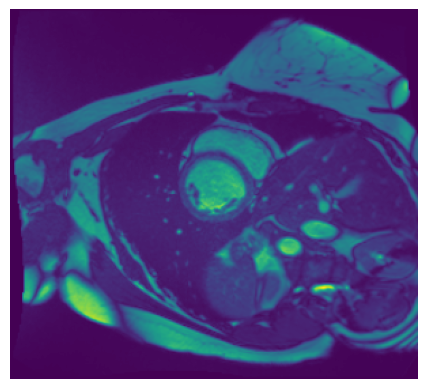

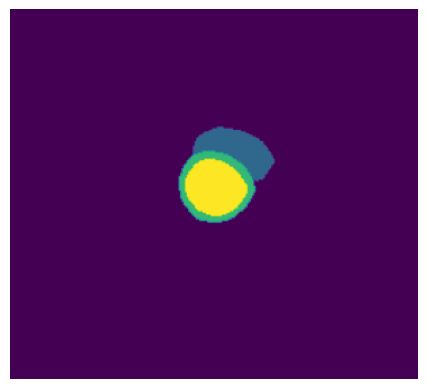

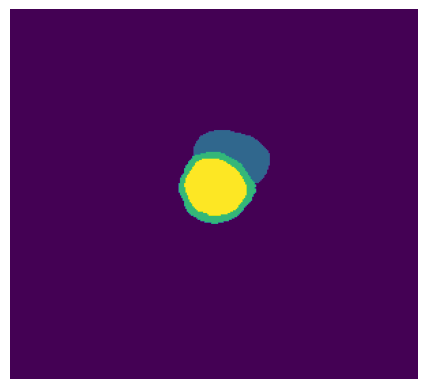

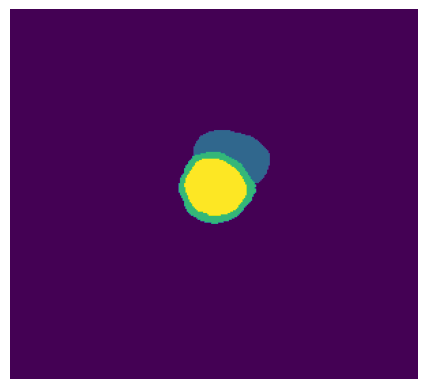

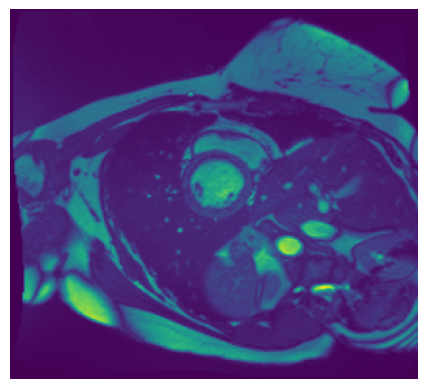

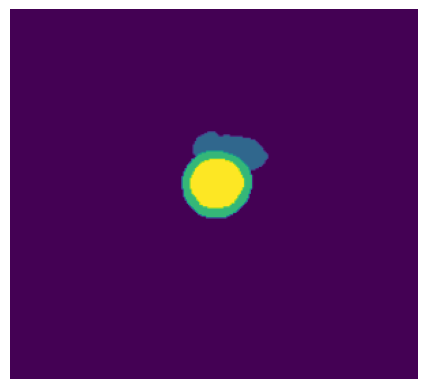

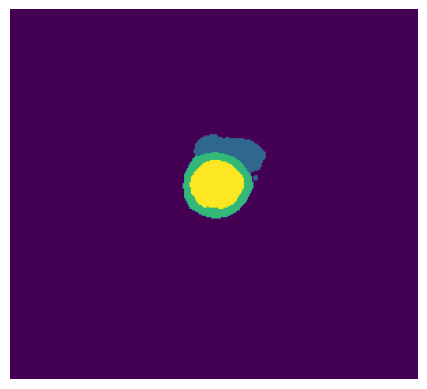

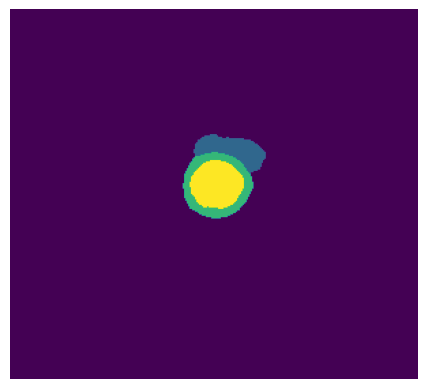

In [53]:
with torch.no_grad():
    import matplotlib.pyplot as plt
    model.eval()
    d = next(iter(test_loader))
    slice_inferer = monai.inferers.SliceInferer(roi_size=(128, 128), spatial_dim=2, sw_batch_size=1, cval=-1, progress=False, overlap=0.6, mode='constant')
    postprocessing = monai.transforms.KeepLargestConnectedComponent(is_onehot=False, applied_labels=[1,2,3], independent=False)

    img = torch.cat([d['MRI_sys'], d['MRI_dias']], dim=1).to(device)
    print(img.shape)

    label_dias = d['Label_dias'].to(device)
    label_sys = d['Label_sys'].to(device)
    print(label_sys.shape)

    # out = model(img)
    out = slice_inferer(img, model)

    out_dias = out[:, 4:]
    out_lcc_dias = torch.argmax(out_dias, dim=1)[None,:,:,:,:]
    out_lcc_dias = postprocessing(out_lcc_dias)

    out_dias = torch.argmax(out_dias, dim=1)
    
    plt.imshow(img[0, 1, :, :, 3].cpu())
    plt.axis('off')
    plt.show()

    plt.imshow(label_dias[0, 0, :, :, 3].cpu())
    plt.axis('off')
    plt.show()

    plt.imshow(out_dias[0,:,:,3].cpu())
    plt.axis('off')
    plt.show()
    
    plt.imshow(out_lcc_dias[0,0,:,:,3].cpu())
    plt.axis('off')
    plt.show()
    # plt.imshow(d['MRI_sys'][0, 0])
    
    
    out_sys = out[:, :4]
    out_lcc_sys = torch.argmax(out_sys, dim=1)[None,:,:,:,:]
    out_lcc_sys = postprocessing(out_lcc_sys)

    out_sys = torch.argmax(out_sys, dim=1)
    
    plt.imshow(img[0, 0, :, :, 3].cpu())
    plt.axis('off')
    plt.show()

    plt.imshow(label_sys[0, 0, :, :, 3].cpu())
    plt.axis('off')
    plt.show()

    plt.imshow(out_sys[0,:,:,3].cpu())
    plt.axis('off')
    plt.show()
    
    plt.imshow(out_lcc_sys[0,0,:,:,3].cpu())
    plt.axis('off')
    plt.show()
    # plt.imshow(d['MRI_sys'][0, 0])


In [22]:
torch.save(model.state_dict(), r'trained_SWIN_UNETR_2ch_best_ISHIFT_warmup_2400_1.pt')

In [26]:
model.load_state_dict(torch.load(r'trained_SWIN_UNETR_2ch_best_7.pt'))
model.eval()



SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(2, 24, kernel_size=(2, 2), stride=(2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=24, out_features=72, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=24, out_features=24, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=24, out_features=96, bias=True)
              (linear2): Linear(in_features=96, out_feat

In [27]:

from monai.transforms import SaveImage



# Save predictions and modified ground truths to specified path
with torch.no_grad():
    for batch_data in test_loader:
        img = torch.cat([batch_data['MRI_sys'], batch_data['MRI_dias']], dim=1).to(device)
        outputs = slice_inferer(img, model)

        out_sys = outputs[:, :4]
        out_dias = outputs[:, 4:]
        
        outputs_sys_lcc = torch.argmax(out_sys, dim=1)[None,:,:,:,:]
        outputs_sys_lcc = postprocessing(outputs_sys_lcc)
        
        # outputs_dias = slice_inferer(batch_data["MRI_dias"].to(device), model)
        outputs_dias_lcc = torch.argmax(out_dias, dim=1)[None,:,:,:,:]
        outputs_dias_lcc = postprocessing(outputs_dias_lcc)
        
        predictions_sys_path = data_path + "predictions/" + batch_data["patient"][0] + "_ES.nii.gz"
        ground_truth_sys_path = data_path + "ground_truth/" + batch_data["patient"][0] + "_ES.nii.gz"
        predictions_dias_path = data_path + "predictions/" + batch_data["patient"][0] + "_ED.nii.gz"
        ground_truth_dias_path = data_path + "ground_truth/" + batch_data["patient"][0] + "_ED.nii.gz"
        nibabel.save(nibabel.Nifti1Image(outputs_sys_lcc[0,:,:,:,:].cpu().numpy(), batch_data["MRI_sys"][0].meta["original_affine"]), predictions_sys_path)
        nibabel.save(nibabel.Nifti1Image(batch_data["Label_sys"][0].numpy(), batch_data["MRI_sys"][0].meta["original_affine"]), ground_truth_sys_path)
        nibabel.save(nibabel.Nifti1Image(outputs_dias_lcc[0,:,:,:,:].cpu().numpy(), batch_data["MRI_dias"][0].meta["original_affine"]), predictions_dias_path)
        nibabel.save(nibabel.Nifti1Image(batch_data["Label_dias"][0].numpy(), batch_data["MRI_dias"][0].meta["original_affine"]), ground_truth_dias_path)


Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().


In [28]:
"""
original author: Clément Zotti (clement.zotti@usherbrooke.ca)
date: April 2017
modified to fit the needs of this notebook

The first option will print in the console the dice and volume of each class for the given image.
The second option wiil ouput a csv file where each images will have the dice and volume of each class.

Link: http://acdc.creatis.insa-lyon.fr

"""

import os
from glob import glob
import time
import re
import argparse
import nibabel as nib
import pandas as pd
from medpy.metric.binary import hd, dc
import numpy as np



HEADER = ["Name", "Dice LV", "Hausdorff LV", "Volume LV", "Err LV(ml)",
          "Dice RV", "Hausdorff RV", "Volume RV", "Err RV(ml)",
          "Dice MYO", "Hausdorff Myo",  "Volume MYO", "Err MYO(ml)"]

#
# Utils functions used to sort strings into a natural order
#
def conv_int(i):
    return int(i) if i.isdigit() else i


def natural_order(sord):
    """
    Sort a (list,tuple) of strings into natural order.

    Ex:

    ['1','10','2'] -> ['1','2','10']

    ['abc1def','ab10d','b2c','ab1d'] -> ['ab1d','ab10d', 'abc1def', 'b2c']

    """
    if isinstance(sord, tuple):
        sord = sord[0]
    return [conv_int(c) for c in re.split(r'(\d+)', sord)]


#
# Utils function to load and save nifti files with the nibabel package
#
def load_nii(img_path):
    """
    Function to load a 'nii' or 'nii.gz' file, The function returns
    everyting needed to save another 'nii' or 'nii.gz'
    in the same dimensional space, i.e. the affine matrix and the header

    Parameters
    ----------

    img_path: string
    String with the path of the 'nii' or 'nii.gz' image file name.

    Returns
    -------
    Three element, the first is a numpy array of the image values,
    the second is the affine transformation of the image, and the
    last one is the header of the image.
    """
    nimg = nib.load(img_path)
    return nimg.get_data(), nimg.affine, nimg.header


def save_nii(img_path, data, affine, header):
    """
    Function to save a 'nii' or 'nii.gz' file.

    Parameters
    ----------

    img_path: string
    Path to save the image should be ending with '.nii' or '.nii.gz'.

    data: np.array
    Numpy array of the image data.

    affine: list of list or np.array
    The affine transformation to save with the image.

    header: nib.Nifti1Header
    The header that define everything about the data
    (pleasecheck nibabel documentation).
    """
    nimg = nib.Nifti1Image(data, affine=affine, header=header)
    nimg.to_filename(img_path)


#
# Functions to process files, directories and metrics
#
def metrics(img_gt, img_pred, voxel_size):
    """
    Function to compute the metrics between two segmentation maps given as input.

    Parameters
    ----------
    img_gt: np.array
    Array of the ground truth segmentation map.

    img_pred: np.array
    Array of the predicted segmentation map.

    voxel_size: list, tuple or np.array
    The size of a voxel of the images used to compute the volumes.

    Return
    ------
    A list of metrics in this order, [Dice LV, Volume LV, Err LV(ml),
    Dice RV, Volume RV, Err RV(ml), Dice MYO, Volume MYO, Err MYO(ml)]
    """

    if img_gt.ndim != img_pred.ndim:
        raise ValueError("The arrays 'img_gt' and 'img_pred' should have the "
                         "same dimension, {} against {}".format(img_gt.ndim,
                                                                img_pred.ndim))

    res = []
    # Loop on each classes of the input images
    for c in [3, 1, 2]:
        # Copy the gt image to not alterate the input
        gt_c_i = np.copy(img_gt)
        gt_c_i[gt_c_i != c] = 0

        # Copy the pred image to not alterate the input
        pred_c_i = np.copy(img_pred)
        pred_c_i[pred_c_i != c] = 0

        # Clip the value to compute the volumes
        gt_c_i = np.clip(gt_c_i, 0, 1)
        pred_c_i = np.clip(pred_c_i, 0, 1)

        # Compute the Dice
        dice = dc(gt_c_i, pred_c_i)
        
        # Compute the Hausdorff distance
        hausdorff = hd(gt_c_i, pred_c_i)

        # Compute volume
        volpred = pred_c_i.sum() * np.prod(voxel_size) / 1000.
        volgt = gt_c_i.sum() * np.prod(voxel_size) / 1000.

        res += [dice, hausdorff, volpred, volpred-volgt]

    return res


def compute_metrics_on_files(path_gt, path_pred):
    """
    Function to give the metrics for two files

    Parameters
    ----------

    path_gt: string
    Path of the ground truth image.

    path_pred: string
    Path of the predicted image.
    """
    gt, _, header = load_nii(path_gt)
    pred, _, _ = load_nii(path_pred)
    zooms = header.get_zooms()

    name = os.path.basename(path_gt)
    name = name.split('.')[0]
    res = metrics(gt, pred, zooms)
    res = ["{:.3f}".format(r) for r in res]

    formatting = "{:>14}, {:>7}, {:>12}, {:>9}, {:>10}, {:>7}, {:>12}, {:>9}, {:>10}, {:>8}, {:>13}, {:>10}, {:>11}"
    print(formatting.format(*HEADER))
    print(formatting.format(name, *res))


def compute_metrics_on_directories(dir_gt, dir_pred):
    """
    Function to generate a csv file for each images of two directories.

    Parameters
    ----------

    path_gt: string
    Directory of the ground truth segmentation maps.

    path_pred: string
    Directory of the predicted segmentation maps.
    """
    lst_gt = sorted(glob(os.path.join(dir_gt, '*')), key=natural_order)
    lst_pred = sorted(glob(os.path.join(dir_pred, '*')), key=natural_order)

    res = []
    for p_gt, p_pred in zip(lst_gt, lst_pred):
        if os.path.basename(p_gt) != os.path.basename(p_pred):
            raise ValueError("The two files don't have the same name"
                             " {}, {}.".format(os.path.basename(p_gt),
                                               os.path.basename(p_pred)))

        gt, _, header = load_nii(p_gt)
        pred, _, _ = load_nii(p_pred)
        zooms = header.get_zooms()
        res.append(metrics(gt, pred, zooms))

    lst_name_gt = [os.path.basename(gt).split(".")[0] for gt in lst_gt]
    res = [[n,] + r for r, n in zip(res, lst_name_gt)]
    df = pd.DataFrame(res, columns=HEADER)
    df.to_csv(os.path.join(data_path, "results_{}.csv".format(time.strftime("%Y%m%d_%H%M%S"))), index=False)

def export_metrics_to_csv(path_gt, path_pred):
    """
    Main function to select which method to apply on the input parameters.
    """
    if os.path.isfile(path_gt) and os.path.isfile(path_pred):
        compute_metrics_on_files(path_gt, path_pred)
    elif os.path.isdir(path_gt) and os.path.isdir(path_pred):
        compute_metrics_on_directories(path_gt, path_pred)
    else:
        raise ValueError(
            "The paths given needs to be two directories or two files.")

export_metrics_to_csv(os.path.join(data_path, 'ground_truth'), os.path.join(data_path, 'predictions'))

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [ ]:
# """
# original author: Clément Zotti (clement.zotti@usherbrooke.ca)
# date: April 2017
# modified to fit the needs of this notebook

# The first option will print in the console the dice and volume of each class for the given image.
# The second option wiil ouput a csv file where each images will have the dice and volume of each class.

# Link: http://acdc.creatis.insa-lyon.fr

# """

# import os
# from glob import glob
# import time
# import re
# import argparse
# import nibabel as nib
# import pandas as pd
# from medpy.metric.binary import hd, dc
# import numpy as np



# HEADER = ["Name", "Dice LV", "Volume LV", "Err LV(ml)",
#           "Dice RV", "Volume RV", "Err RV(ml)",
#           "Dice MYO", "Volume MYO", "Err MYO(ml)"]

# #
# # Utils functions used to sort strings into a natural order
# #
# def conv_int(i):
#     return int(i) if i.isdigit() else i


# def natural_order(sord):
#     """
#     Sort a (list,tuple) of strings into natural order.

#     Ex:

#     ['1','10','2'] -> ['1','2','10']

#     ['abc1def','ab10d','b2c','ab1d'] -> ['ab1d','ab10d', 'abc1def', 'b2c']

#     """
#     if isinstance(sord, tuple):
#         sord = sord[0]
#     return [conv_int(c) for c in re.split(r'(\d+)', sord)]


# #
# # Utils function to load and save nifti files with the nibabel package
# #
# def load_nii(img_path):
#     """
#     Function to load a 'nii' or 'nii.gz' file, The function returns
#     everyting needed to save another 'nii' or 'nii.gz'
#     in the same dimensional space, i.e. the affine matrix and the header

#     Parameters
#     ----------

#     img_path: string
#     String with the path of the 'nii' or 'nii.gz' image file name.

#     Returns
#     -------
#     Three element, the first is a numpy array of the image values,
#     the second is the affine transformation of the image, and the
#     last one is the header of the image.
#     """
#     nimg = nib.load(img_path)
#     return nimg.get_data(), nimg.affine, nimg.header


# def save_nii(img_path, data, affine, header):
#     """
#     Function to save a 'nii' or 'nii.gz' file.

#     Parameters
#     ----------

#     img_path: string
#     Path to save the image should be ending with '.nii' or '.nii.gz'.

#     data: np.array
#     Numpy array of the image data.

#     affine: list of list or np.array
#     The affine transformation to save with the image.

#     header: nib.Nifti1Header
#     The header that define everything about the data
#     (pleasecheck nibabel documentation).
#     """
#     nimg = nib.Nifti1Image(data, affine=affine, header=header)
#     nimg.to_filename(img_path)


# #
# # Functions to process files, directories and metrics
# #
# def metrics(img_gt, img_pred, voxel_size):
#     """
#     Function to compute the metrics between two segmentation maps given as input.

#     Parameters
#     ----------
#     img_gt: np.array
#     Array of the ground truth segmentation map.

#     img_pred: np.array
#     Array of the predicted segmentation map.

#     voxel_size: list, tuple or np.array
#     The size of a voxel of the images used to compute the volumes.

#     Return
#     ------
#     A list of metrics in this order, [Dice LV, Volume LV, Err LV(ml),
#     Dice RV, Volume RV, Err RV(ml), Dice MYO, Volume MYO, Err MYO(ml)]
#     """

#     if img_gt.ndim != img_pred.ndim:
#         raise ValueError("The arrays 'img_gt' and 'img_pred' should have the "
#                          "same dimension, {} against {}".format(img_gt.ndim,
#                                                                 img_pred.ndim))

#     res = []
#     # Loop on each classes of the input images
#     for c in [3, 1, 2]:
#         # Copy the gt image to not alterate the input
#         gt_c_i = np.copy(img_gt)
#         gt_c_i[gt_c_i != c] = 0

#         # Copy the pred image to not alterate the input
#         pred_c_i = np.copy(img_pred)
#         pred_c_i[pred_c_i != c] = 0

#         # Clip the value to compute the volumes
#         gt_c_i = np.clip(gt_c_i, 0, 1)
#         pred_c_i = np.clip(pred_c_i, 0, 1)

#         # Compute the Dice
#         dice = dc(gt_c_i, pred_c_i)

#         # Compute volume
#         volpred = pred_c_i.sum() * np.prod(voxel_size) / 1000.
#         volgt = gt_c_i.sum() * np.prod(voxel_size) / 1000.

#         res += [dice, volpred, volpred-volgt]

#     return res


# def compute_metrics_on_files(path_gt, path_pred):
#     """
#     Function to give the metrics for two files

#     Parameters
#     ----------

#     path_gt: string
#     Path of the ground truth image.

#     path_pred: string
#     Path of the predicted image.
#     """
#     gt, _, header = load_nii(path_gt)
#     pred, _, _ = load_nii(path_pred)
#     zooms = header.get_zooms()

#     name = os.path.basename(path_gt)
#     name = name.split('.')[0]
#     res = metrics(gt, pred, zooms)
#     res = ["{:.3f}".format(r) for r in res]

#     formatting = "{:>14}, {:>7}, {:>9}, {:>10}, {:>7}, {:>9}, {:>10}, {:>8}, {:>10}, {:>11}"
#     print(formatting.format(*HEADER))
#     print(formatting.format(name, *res))


# def compute_metrics_on_directories(dir_gt, dir_pred):
#     """
#     Function to generate a csv file for each images of two directories.

#     Parameters
#     ----------

#     path_gt: string
#     Directory of the ground truth segmentation maps.

#     path_pred: string
#     Directory of the predicted segmentation maps.
#     """
#     lst_gt = sorted(glob(os.path.join(dir_gt, '*')), key=natural_order)
#     lst_pred = sorted(glob(os.path.join(dir_pred, '*')), key=natural_order)

#     res = []
#     for p_gt, p_pred in zip(lst_gt, lst_pred):
#         if os.path.basename(p_gt) != os.path.basename(p_pred):
#             raise ValueError("The two files don't have the same name"
#                              " {}, {}.".format(os.path.basename(p_gt),
#                                                os.path.basename(p_pred)))

#         gt, _, header = load_nii(p_gt)
#         pred, _, _ = load_nii(p_pred)
#         zooms = header.get_zooms()
#         res.append(metrics(gt, pred, zooms))

#     lst_name_gt = [os.path.basename(gt).split(".")[0] for gt in lst_gt]
#     res = [[n,] + r for r, n in zip(res, lst_name_gt)]
#     df = pd.DataFrame(res, columns=HEADER)
#     df.to_csv(os.path.join(data_path, "results_{}.csv".format(time.strftime("%Y%m%d_%H%M%S"))), index=False)

# def export_metrics_to_csv(path_gt, path_pred):
#     """
#     Main function to select which method to apply on the input parameters.
#     """
#     if os.path.isfile(path_gt) and os.path.isfile(path_pred):
#         compute_metrics_on_files(path_gt, path_pred)
#     elif os.path.isdir(path_gt) and os.path.isdir(path_pred):
#         compute_metrics_on_directories(path_gt, path_pred)
#     else:
#         raise ValueError(
#             "The paths given needs to be two directories or two files.")

# export_metrics_to_csv(os.path.join(data_path, 'ground_truth'), os.path.join(data_path, 'predictions'))